In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
from scipy.stats import iqr, shapiro
import scipy.stats as st

In [4]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
import warnings

In [7]:
folder = "D:/Openclassrooms_DataScientist/Projet_3/donnees/"

In [8]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)

# Plan

1. Nettoyage

    - compréhension du dataset
        - classement des variables par type (catégorie, chaine, num, date...), identification de groupes, de variables de même "famille"
    - gestion des doublons
    - gestion des types / unités
    - gestion des valeurs manquantes
    - gestion des valeurs aberrantes --> **enlever en priorité les valeurs extrêmes pour les conso d'énergie relative, qui ont été divisées par la surface**
    - suppressions des données inutiles (colonnes, lignes)
    - création de nouvelles variables  
    
<br>

2. Identification de la problématique

    - identification de la variable cible : **émissions de CO2**, **consommation totale d'énergie**
    - identification des variables importantes
    - détermination des métriques et des scores permettant l'évaluation : 
        - Coefficient de détermination R², proportion de la variance de la variable cible expliquée par le modèle, proportion des variations de la variable cible expliquée par le modèle
        - Erreur quadradique moyenne (RMSE), on la veut minimum
        - Erreur absolue moyenne (MSE), moins sensible aux valeurs aberrantes
        - Erreur médiane moyenne
        - Distribution de ces métriques
    
<br>
  
3. Exploration

    - compréhension du dataset
    - analyse des corrélations : matrice de corrélations, heatmap
    - analyse des variables par rapport aux variables cibles
    - analyses univariées : boxplot et histogramme pour chaque variable qualitative
    - analyses bivariées : quantitatif/qualitatif --> analyse des variables par groupes
        conclusion rapide à chaque fois --> essayer de trouver des pistes
    - analyses bivariées quantitatif/quantitatif --> voir les corrélations
    - analyses bvariées qualitatif/qualitatif --> tableau de contingence
    - si je vois quelque chose --> verifier la signicativité avec un test statistique
        pearson, anova, chi2...  
     

<br>

4. Modification des données

    - détermination des variables très corrélées, qui expriment presque la même et suppression de l'une d'entre elles
    - création de variables à partir d'autres variables

<br>

5. Modélisation

    - Choix des algos : régression linéaire/multiple, KNN, SGDRegressor, RandomForest, SVR, Lasso, ElasticNet en fonction des données
    - Normaliser les données
    - créer jeu entrainement, validation, test
    - utiliser cross validation
    - utiliser gridsearchcv --> optimisation des hyperparamètres
    - mettre en place une évaluation : voir videos ML
    - créer la modélisation sous forme de fonction pour bien mesurer l'évaluation à chaque fois,
        permettant bien le processus itératif
        
<br>
        
6. Evaluation du modèle  

    - Modifier les paramètres à chaque itération
    - Enlever les variables qui expliquent peu les variables cibles
    - Enlever les variables qui se ressemble trop, qui disent presque la même chose.
    - Vérifier les VIF

# Nettoyage

In [9]:
data = pd.read_csv(folder+"2016_Building_Energy_Benchmarking.csv")
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

## Définition des variables cibles

Les variables cibles sont :
- Les émssions de gaz à effet de serre : 'TotalGHGEmissions' renommée plus tard 'EmissionGES'.
- Les consommations totales d'énergie : 'SiteEnergyUse(kBtu)' renommée plus tard 'ConsoSiteTot(kBtu)'.

In [10]:
# variable cible emission de CO2
target_emission_co2 = ['TotalGHGEmissions']
# variable cible energie totale annuelle
target_energie = ['SiteEnergyUse(kBtu)']

## Réduction des lignes
Nos prédictions concernent les batiments non destinés à l'habitation, on garde donc uniquement ceux là dans l'analyse.

In [11]:
non_residential = data['BuildingType'].isin(['NonResidential', 'Nonresidential COS', 'Nonresidential WA'])

In [12]:
data = data.loc[non_residential,:]
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1546 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1546 non-null   int64  
 1   DataYear                         1546 non-null   int64  
 2   BuildingType                     1546 non-null   object 
 3   PrimaryPropertyType              1546 non-null   object 
 4   PropertyName                     1546 non-null   object 
 5   Address                          1546 non-null   object 
 6   City                             1546 non-null   object 
 7   State                            1546 non-null   object 
 8   ZipCode                          1530 non-null   float64
 9   TaxParcelIdentificationNumber    1546 non-null   object 
 10  CouncilDistrictCode              1546 non-null   int64  
 11  Neighborhood                     1546 non-null   object 
 12  Latitude            

#### Données ou il y a des données par défaut présentes
Ces données ne correspondent par forcément à la réalité elles peuvent brouiller les prédictions, autant les supprimer

In [14]:
data[data['DefaultData']==True]

OSEBuildingID  DataYear        BuildingType  \
276             405      2016      NonResidential   
457             618      2016      NonResidential   
1045          20617      2016      NonResidential   
1466          21898      2016      NonResidential   
1467          21902      2016      NonResidential   
1641          22953      2016      NonResidential   
1656          23011      2016      NonResidential   
1977          24030      2016      NonResidential   
2076          24374      2016      NonResidential   
2682          26593      2016      NonResidential   
3366          50210      2016  Nonresidential COS   
3369          50220      2016  Nonresidential COS   
3371          50222      2016  Nonresidential COS   

              PrimaryPropertyType                  PropertyName  \
276                  Large Office                   The Decatur   
457   Small- and Mid-Sized Office                   Prefontaine   
1045                 Retail Store         Seattle Habitat Store   
1466                    Warehouse          Halfon Candy Company   
1467                    Warehouse                        Samson   
1641                 Retail Store                      Tux Shop   
1656                 Retail Store                         Bevmo   
1977                 Retail Store               King Plaza 6951   
2076                 Retail Store      Jumbo chinese restaurant   
2682  Small- and Mid-Sized Office               Delmar Building   
3366                       Office  Central West HQ / Brown Bear   
3369                       Office              Genesee/SC SE HQ   
3371                       Office         Horticulture building   

                               Address     City State  ZipCode  \
276                    1511 6th Avenue  Seattle    WA  98101.0   
457               110 Prefontaine Pl S  Seattle    WA  98104.0   
1045                    21 S Nevada St  Seattle    WA  98134.0   
1466            9229 10th Avenue South  Seattle    WA  98108.0   
1467               9928 10th Ave South  Seattle    WA  98108.0   
1641                  10716 5th Ave NE  Seattle    WA  98125.0   
1656                  10700 5th Ave NE  Seattle    WA  98125.0   
1977  6951 Martin Luther King Jr Way S  Seattle    WA  98118.0   
2076              4208 rainier ave so.  Seattle    WA  98118.0   
2682           108 South Washington St  Seattle    WA  98104.0   
3366                       1403 w howe  Seattle    WA      NaN   
3369                    4420 S Genesee  Seattle    WA      NaN   
3371                  1600 S Dakota St  Seattle    WA      NaN   

     TaxParcelIdentificationNumber  CouncilDistrictCode  \
276                     1975700125                    7   
457                     5247801045                    7   
1045                    1824049074                    2   
1466                    2433700076                    1   
1467                    2433700165                    1   
1641                    2926049039                    5   
1656                    2926049223                    5   
1977                    3333002890                    2   
2076                    7950301480                    2   
2682                    5247800481                    7   
3366                    2425039137                    7   
3369                    4154300585                    2   
3371                    1624049080                    2   

               Neighborhood  Latitude  Longitude  YearBuilt  \
276                DOWNTOWN  47.61166 -122.33528       1921   
457                DOWNTOWN  47.60159 -122.32915       1909   
1045       GREATER DUWAMISH  47.56535 -122.34054       1953   
1466       GREATER DUWAMISH  47.51968 -122.32120       1978   
1467       GREATER DUWAMISH  47.51918 -122.31957       1979   
1641                  NORTH  47.70747 -122.32249       1965   
1656                  NORTH  47.70708 -122.32251       1966   
1977       GREATER DUWAMISH  47.53922 -122.28295       2002   
2076 

In [15]:
data = data.drop(data[data['DefaultData']==True].index)
data

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0                 1      2016      NonResidential               Hotel   
1                 2      2016      NonResidential               Hotel   
2                 3      2016      NonResidential               Hotel   
3                 5      2016      NonResidential               Hotel   
4                 8      2016      NonResidential               Hotel   
...             ...       ...                 ...                 ...   
3370          50221      2016  Nonresidential COS               Other   
3372          50223      2016  Nonresidential COS               Other   
3373          50224      2016  Nonresidential COS               Other   
3374          50225      2016  Nonresidential COS  Mixed Use Property   
3375          50226      2016  Nonresidential COS  Mixed Use Property   

                             PropertyName           Address     City State  \
0                    Mayflower park hotel     405 Olive way  Seattle    WA   
1                         Paramount Hotel   724 Pine street  Seattle    WA   
2                 5673-The Westin Seattle   1900 5th Avenue  Seattle    WA   
3                               HOTEL MAX    620 STEWART ST  Seattle    WA   
4             WARWICK SEATTLE HOTEL (ID8)     401 LENORA ST  Seattle    WA   
...                                   ...               ...      ...   ...   
3370          High Point Community Center  6920 34th Ave SW  Seattle    WA   
3372  International district/Chinatown CC     719 8th Ave S  Seattle    WA   
3373                      Queen Anne Pool    1920 1st Ave W  Seattle    WA   
3374          South Park Community Center    8319 8th Ave S  Seattle    WA   
3375          Van Asselt Community Center  2820 S Myrtle St  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
0     98101.0                    0659000030                    7   
1     98101.0                    0659000220                    7   
2     98101.0                    0659000475                    7   
3     98101.0                    0659000640                    7   
4     98121.0                    0659000970                    7   
...       ...                           ...                  ...   
3370      NaN                    2524039059                    1   
3372      NaN                    3558300000                    2   
3373      NaN                    1794501150                    7   
3374      NaN                    7883603155                    1   
3375      NaN                    7857002030                    2   

                Neighborhood  Latitude  Longitude  YearBuilt  \
0                   DOWNTOWN  47.61220 -122.33799       1927   
1                   DOWNTOWN  47.61317 -122.33393       1996   
2                   DOWNTOWN  47.61393 -122.33810       1969   
3                   DOWNTOWN  47.61412 -122.33664       1926   
4                   DOWNTOWN  47.61375 -122.34047       1980   
...                      ...       ...        ...        ...   
3370  DELRIDGE NEIGHBORHOODS  47.54067 -122.37441       1982   
3372                DOWNTOWN  47.59625 -122.32283       2004   
3373   MAGNOLIA / QUEEN ANNE  47.63644 -122.35784       1974   
3374        GREATER DUWAMISH  47.52832 -122.32431       1989   
3375        GREATER DUWAMISH  47.53939 -122.29536       1938   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                   1.0              12             88434                   0   
1                   1.0              11            103566               15064   
2                   1.0              41            956110              196718   
3                   1.0              10             61320                   0   
4                   1.0              18            175580               62000   
...                 ...             ...               ...                 ...   
3370                1.0               1

#### Données avec toutes les valeurs manquantes sur l'énergie
Suppression de cette ligne

In [16]:
data[data['ComplianceStatus']=='Missing Data']

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
746          19776      2016  NonResidential               Other   

                       PropertyName             Address     City State  \
746  Welcome Home Society - PriceCo  13537 Aurora Ave N  Seattle    WA   

     ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
746  98133.0                    0164000020                    5    NORTHWEST   

     Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
746  47.72777 -122.34503       2002                1.0               1   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
746             29924                   0                   29924   

    ListOfAllPropertyUseTypes LargestPropertyUseType  \
746         Other - Education      Other - Education   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
746                    29924.0                          NaN   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
746                              NaN                         NaN   

     ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
746                             NaN                      NaN              NaN   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
746               0.0                 0.0                 0.0   

     SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
746                   0.0                  0.0                    0.0   

     SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
746             0.0               0.0                0.0                 0.0   

     NaturalGas(kBtu)  DefaultData  Comments ComplianceStatus Outlier  \
746               0.0        False       NaN     Missing Data     NaN   

     TotalGHGEmissions  GHGEmissionsIntensity  
746                0.0                    0.0

In [17]:
data = data.drop(data[data['ComplianceStatus']=='Missing Data'].index)
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

## Traitement des valeurs manquantes

<Axes: >

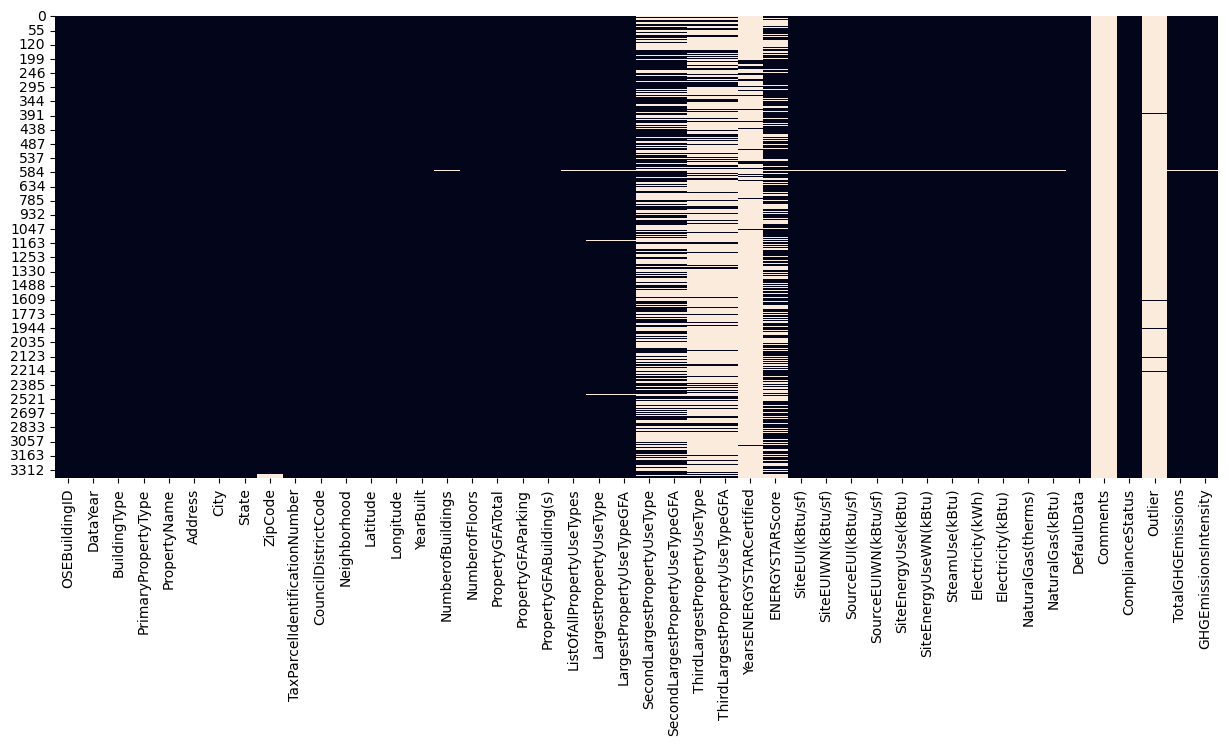

In [18]:
plt.figure(figsize=(15,6))
sns.heatmap(data.isna(), cbar=False)

In [19]:
# 1eres colonnes à supprimer
drop_columns1 = ['Comments', 'Outlier', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'ZipCode', 'DefaultData']

In [20]:
# enregistrement energy_star_score
energy_star_score = data['ENERGYSTARScore']

In [21]:
# stockage des nommés "outliers" pour futur suppression de la variable
outliers = data[data['Outlier'].notna()].head()
outliers

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
226             350      2016  NonResidential                 Large Office   
384             539      2016  NonResidential                 Retail Store   
448             608      2016  NonResidential                 Large Office   
517             704      2016  NonResidential                 Large Office   
1229          21315      2016  NonResidential  Small- and Mid-Sized Office   

                    PropertyName                Address     City State  \
226   Second And Spring Building     1100 Second Avenue  Seattle    WA   
384            University Center  4501 Roosevelt Way NE  Seattle    WA   
448       411 1ST AVE  S (ID608)          411 1ST AVE S  Seattle    WA   
517         401 Elliott Ave West    401 Elliot Ave West  Seattle    WA   
1229             1518 Fifith Ave         1520 Fifth Ave  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
226   98101.0                    0942000045                    7   
384   98105.0                    5335200380                    4   
448   98104.0                    5247800200                    2   
517   98119.0                    7666202110                    7   
1229  98101.0                    1975700135                    7   

               Neighborhood  Latitude  Longitude  YearBuilt  \
226                DOWNTOWN  47.60642 -122.33581       1958   
384               NORTHEAST  47.66178 -122.31812       1987   
448                DOWNTOWN  47.59878 -122.33458       1913   
517   MAGNOLIA / QUEEN ANNE  47.62235 -122.36378       2000   
1229               DOWNTOWN  47.61119 -122.33581       1903   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
226                 1.0               6            172842               25920   
384                 1.0               2             69492                   0   
448                 5.0               7            154159                   0   
517                 1.0               4            129551               42500   
1229                1.0               3             57720                   0   

      PropertyGFABuilding(s)     ListOfAllPropertyUseTypes  \
226                   146922  Data Center, Office, Parking   
384                    69492                  Retail Store   
448                   154159                        Office   
517                    87051  Data Center, Office, Parking   
1229                   57720                        Office   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
226                  Office                    99890.0   
384            Retail Store                    69800.0   
448                  Office                   193154.0   
517                  Office                    82273.0   
1229                 Office                    25000.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
226                   Data Center                          39336.0   
384                         Other                              0.0   
448                           NaN                              NaN   
517                       Parking                          42500.0   
1229                          NaN                              NaN   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
226                      Parking                         25000.0   
384                          NaN                             NaN   
448                          NaN                             NaN   
517                  Data Center                          4778.0   
1229                         NaN                             NaN   

     YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
226                       NaN              NaN        297.399994   
384                       NaN            100.0          4.600000   
448                       NaN            100.0         58.000

In [22]:
data.isna().sum().sort_values(ascending=False)/data.shape[0]

Comments                           1.000000
Outlier                            0.990209
YearsENERGYSTARCertified           0.940601
ThirdLargestPropertyUseType        0.776762
ThirdLargestPropertyUseTypeGFA     0.776762
SecondLargestPropertyUseType       0.454308
SecondLargestPropertyUseTypeGFA    0.454308
ENERGYSTARScore                    0.351828
ZipCode                            0.008486
LargestPropertyUseType             0.003916
LargestPropertyUseTypeGFA          0.003916
SiteEUIWN(kBtu/sf)                 0.001958
SiteEUI(kBtu/sf)                   0.001958
SiteEnergyUseWN(kBtu)              0.001958
SteamUse(kBtu)                     0.001305
SiteEnergyUse(kBtu)                0.001305
SourceEUIWN(kBtu/sf)               0.001305
SourceEUI(kBtu/sf)                 0.001305
Electricity(kWh)                   0.001305
Electricity(kBtu)                  0.001305
NaturalGas(therms)                 0.001305
NaturalGas(kBtu)                   0.001305
TotalGHGEmissions               

In [23]:
# Aucun
data[data['Comments'].notna()].head()

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, Comments, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

In [24]:
# 1ere suppression colonne
data = data.drop(columns=drop_columns1)
data

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0                 1      2016      NonResidential               Hotel   
1                 2      2016      NonResidential               Hotel   
2                 3      2016      NonResidential               Hotel   
3                 5      2016      NonResidential               Hotel   
4                 8      2016      NonResidential               Hotel   
...             ...       ...                 ...                 ...   
3370          50221      2016  Nonresidential COS               Other   
3372          50223      2016  Nonresidential COS               Other   
3373          50224      2016  Nonresidential COS               Other   
3374          50225      2016  Nonresidential COS  Mixed Use Property   
3375          50226      2016  Nonresidential COS  Mixed Use Property   

                             PropertyName           Address     City State  \
0                    Mayflower park hotel     405 Olive way  Seattle    WA   
1                         Paramount Hotel   724 Pine street  Seattle    WA   
2                 5673-The Westin Seattle   1900 5th Avenue  Seattle    WA   
3                               HOTEL MAX    620 STEWART ST  Seattle    WA   
4             WARWICK SEATTLE HOTEL (ID8)     401 LENORA ST  Seattle    WA   
...                                   ...               ...      ...   ...   
3370          High Point Community Center  6920 34th Ave SW  Seattle    WA   
3372  International district/Chinatown CC     719 8th Ave S  Seattle    WA   
3373                      Queen Anne Pool    1920 1st Ave W  Seattle    WA   
3374          South Park Community Center    8319 8th Ave S  Seattle    WA   
3375          Van Asselt Community Center  2820 S Myrtle St  Seattle    WA   

     TaxParcelIdentificationNumber  CouncilDistrictCode  \
0                       0659000030                    7   
1                       0659000220                    7   
2                       0659000475                    7   
3                       0659000640                    7   
4                       0659000970                    7   
...                            ...                  ...   
3370                    2524039059                    1   
3372                    3558300000                    2   
3373                    1794501150                    7   
3374                    7883603155                    1   
3375                    7857002030                    2   

                Neighborhood  Latitude  Longitude  YearBuilt  \
0                   DOWNTOWN  47.61220 -122.33799       1927   
1                   DOWNTOWN  47.61317 -122.33393       1996   
2                   DOWNTOWN  47.61393 -122.33810       1969   
3                   DOWNTOWN  47.61412 -122.33664       1926   
4                   DOWNTOWN  47.61375 -122.34047       1980   
...                      ...       ...        ...        ...   
3370  DELRIDGE NEIGHBORHOODS  47.54067 -122.37441       1982   
3372                DOWNTOWN  47.59625 -122.32283       2004   
3373   MAGNOLIA / QUEEN ANNE  47.63644 -122.35784       1974   
3374        GREATER DUWAMISH  47.52832 -122.32431       1989   
3375        GREATER DUWAMISH  47.53939 -122.29536       1938   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                   1.0              12             88434                   0   
1                   1.0              11            103566               15064   
2                   1.0              41            956110              196718   
3                   1.0              10             61320                   0   
4                   1.0              18            175580               62000   
...                 ...             ...               ...                 ...   
3370                1.0               1             18261                   0   
3372                1.0               1             16000         

## Doublons

In [25]:
data[data.duplicated()]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), ComplianceStatus, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

Pas de doublons

## Divers

Certains quartiers sont en minuscules, je les remets en majuscule pour éviter les doublons.

In [26]:
data['Neighborhood'] = data['Neighborhood'].str.upper()

## Types de données, compréhension du dataset

In [27]:
data.dtypes.value_counts()

float64    19
object     13
int64       8
dtype: int64

#### Colonnes "objet"

In [28]:
# colonnes objet -> catégorielles ou str
data.select_dtypes(include='object').head()

BuildingType PrimaryPropertyType                 PropertyName  \
0  NonResidential               Hotel         Mayflower park hotel   
1  NonResidential               Hotel              Paramount Hotel   
2  NonResidential               Hotel      5673-The Westin Seattle   
3  NonResidential               Hotel                    HOTEL MAX   
4  NonResidential               Hotel  WARWICK SEATTLE HOTEL (ID8)   

           Address     City State TaxParcelIdentificationNumber Neighborhood  \
0    405 Olive way  Seattle    WA                    0659000030     DOWNTOWN   
1  724 Pine street  Seattle    WA                    0659000220     DOWNTOWN   
2  1900 5th Avenue  Seattle    WA                    0659000475     DOWNTOWN   
3   620 STEWART ST  Seattle    WA                    0659000640     DOWNTOWN   
4    401 LENORA ST  Seattle    WA                    0659000970     DOWNTOWN   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2                          Hotel                  Hotel   
3                          Hotel                  Hotel   
4  Hotel, Parking, Swimming Pool                  Hotel   

  SecondLargestPropertyUseType ThirdLargestPropertyUseType ComplianceStatus  
0                          NaN                         NaN        Compliant  
1                      Parking                  Restaurant        Compliant  
2                          NaN                         NaN        Compliant  
3                          NaN                         NaN        Compliant  
4                      Parking               Swimming Pool        Compliant

In [29]:
# variables catégorielles
var_objet_inutiles = ['BuildingType', 'PropertyName', 'Address', 'City', 'State', 'TaxParcelIdentificationNumber']

Suppression des colonnes objets inutiles  

Plusieurs champs concernant l'adresse ne fournissent aucune information, on gardera juste le quartier.

On a gardé que les batiments non résidentiels, on supprime donc la colonnes BuildingType

In [30]:
data = data.drop(columns=var_objet_inutiles)

#### Coordonnées GPS

In [31]:
df_gps = data[['Latitude', 'Longitude']]

#### Colonnes numériques

In [32]:
# colonnes objet -> catégorielles ou str
data.select_dtypes(exclude='object').head()

OSEBuildingID  DataYear  CouncilDistrictCode  Latitude  Longitude  \
0              1      2016                    7  47.61220 -122.33799   
1              2      2016                    7  47.61317 -122.33393   
2              3      2016                    7  47.61393 -122.33810   
3              5      2016                    7  47.61412 -122.33664   
4              8      2016                    7  47.61375 -122.34047   

   YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0       1927                1.0              12             88434   
1       1996                1.0              11            103566   
2       1969                1.0              41            956110   
3       1926                1.0              10             61320   
4       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
0                   0                   88434                    88434.0   
1               15064                   88502                    83880.0   
2              196718                  759392                   756493.0   
3                   0                   61320                    61320.0   
4               62000                  113580                   123445.0   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
0                              NaN                             NaN   
1                          15064.0                          4622.0   
2                              NaN                             NaN   
3                              NaN                             NaN   
4                          68009.0                             0.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0         81.699997           84.300003          182.500000   
1         94.800003           97.900002          176.100006   
2         96.000000           97.699997          241.899994   
3        110.800003          113.300003          216.199997   
4        114.800003          118.699997          211.399994   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0            189.000000            7226362.5              7456910.0   
1            179.399994            8387933.0              8664479.0   
2            244.100006           72587024.0             73937112.0   
3            224.000000            6794584.0              6946800.5   
4            215.600006           14172606.0             14656503.0   

   SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
0      2003882.00      1.156514e+06          3946027.0         12764.52930   
1            0.00      9.504252e+05          3242851.0         51450.81641   
2     21566554.00      1.451544e+07         49526664.0         14938.00000   
3      2214446.25      8.115253e+05          2768924.0         18112.13086   
4            0.00      1.573449e+06          5368607.0         88039.98438   

   NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  
0         1276453.0             249.98                   2.83  
1         5145082.0             295.86                   2.86  
2         1493800.0            2089.28                   2.19  
3         1811213.0             286.43                   4.67  
4         8803998.0             505.01                   2.88

In [33]:
var_num_inutiles = ['OSEBuildingID', 'DataYear', 'CouncilDistrictCode', 'Latitude', 'Longitude']

In [34]:
# suppression des colonnes numeriques inutiles
data = data.drop(columns=var_num_inutiles)

In [35]:
data.head()

PrimaryPropertyType Neighborhood  YearBuilt  NumberofBuildings  \
0               Hotel     DOWNTOWN       1927                1.0   
1               Hotel     DOWNTOWN       1996                1.0   
2               Hotel     DOWNTOWN       1969                1.0   
3               Hotel     DOWNTOWN       1926                1.0   
4               Hotel     DOWNTOWN       1980                1.0   

   NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0              12             88434                   0   
1              11            103566               15064   
2              41            956110              196718   
3              10             61320                   0   
4              18            175580               62000   

   PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   88434                          Hotel   
1                   88502     Hotel, Parking, Restaurant   
2                  759392                          Hotel   
3                   61320                          Hotel   
4                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0         81.699997           84.300003          182.500000   
1         94.800003           97.900002          176.100006   
2         96.000000           97.699997          241.899994   
3        110.800003          113.300003          216.199997   
4        114.800003          118.699997          211.399994   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0            189.000000            7226362.5              7456910.0   
1            179.399994            8387933.0              8664479.0   
2            244.100006           72587024.0             73937112.0   
3            224.000000            6794584.0              6946800.5   
4            215.600006           14172606.0             14656503.0   

   SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
0      2003882.00      1.156514e+06          3946027.0         12764.52930   
1            0.00      9.504252e+05          3242851.0         51450.81641   
2     21566554.00      1.451544e+07         49526664.0         14938.00000   
3      2214446.25      8.115253e+05          2768924.0         18112.13086   
4            0.00      1.573449e+06          5368607.0         88039.98438   

   NaturalGas(kBtu) ComplianceStatus  TotalGHGEmissions  GHGEmissionsIntensity  
0         1276453.0        Compliant             249.98                   2.83  
1         5145082.0        Compliant             295.86                   2.86  
2         1493800.0        Compliant            2089.28                   2.19  
3         1811213.0        Compliant             286.43                   4.67  
4         8803998.0        Compliant             505.01                 

## Type d'utilisation des batiments

Choix à faire pour le traitement des différents types d'utilisation des batiments et de leur superficie.

On a des valeurs manquantes pour les 2e et 3e type d'utilisation de certains batiment ainsi que leur superficie associé si le batiment n'a qu'une seule utilisation.

Ici la valeur manquante est une information.

Choix 1 : avantage : on garde le max d'infos  
On va assigner la valeur "aucune" pour les 2e et 3e types d'utilisations manquantes et 0 pour leur valeur de superficie associée.

Choix 2 : avantage : plus simple  
On supprime les 2e et 3e type d'utilisation, on garde juste le premier et on résonne en superficie totale

In [36]:
# data type d'utilisation
data[['PrimaryPropertyType', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']]

PrimaryPropertyType  PropertyGFATotal  PropertyGFAParking  \
0                  Hotel             88434                   0   
1                  Hotel            103566               15064   
2                  Hotel            956110              196718   
3                  Hotel             61320                   0   
4                  Hotel            175580               62000   
...                  ...               ...                 ...   
3370               Other             18261                   0   
3372               Other             16000                   0   
3373               Other             13157                   0   
3374  Mixed Use Property             14101                   0   
3375  Mixed Use Property             18258                   0   

      PropertyGFABuilding(s)  \
0                      88434   
1                      88502   
2                     759392   
3                      61320   
4                     113580   
...                      ...   
3370                   18261   
3372                   16000   
3373                   13157   
3374                   14101   
3375                   18258   

                              ListOfAllPropertyUseTypes  \
0                                                 Hotel   
1                            Hotel, Parking, Restaurant   
2                                                 Hotel   
3                                                 Hotel   
4                         Hotel, Parking, Swimming Pool   
...                                                 ...   
3370                                 Other - Recreation   
3372                                 Other - Recreation   
3373  Fitness Center/Health Club/Gym, Other - Recrea...   
3374  Fitness Center/Health Club/Gym, Food Service, ...   
3375  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                     Hotel                    88434.0   
1                     Hotel                    83880.0   
2                     Hotel                   756493.0   
3                     Hotel                    61320.0   
4                     Hotel                   123445.0   
...                     ...                        ...   
3370     Other - Recreation                    18261.0   
3372     Other - Recreation                    16000.0   
3373     Other - Recreation                     7583.0   
3374     Other - Recreation                     6601.0   
3375     Other - Recreation                     8271.0   

        SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                                NaN                              NaN   
1                            Parking                          15064.0   
2                                NaN                              NaN   
3                                NaN                              NaN   
4                            Parking                          68009.0   
...                              ...                              ...   
3370                             NaN                              NaN   
3372                             NaN                              NaN   
3373  Fitness Center/Health Club/Gym                           5574.0   
3374  Fitness Center/Health Club/Gym                           6501.0   
3375  Fitness Center/Health Club/Gym                           8000.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  
0                            NaN                             NaN  
1                     Restaurant                          4622.0  
2                            NaN                             NaN  
3                            NaN                             NaN  
4                  Swimming Pool                             0.0  
...                          ...                             ...  
3370                         NaN                             NaN  
3372    

In [37]:
data

PrimaryPropertyType            Neighborhood  YearBuilt  \
0                  Hotel                DOWNTOWN       1927   
1                  Hotel                DOWNTOWN       1996   
2                  Hotel                DOWNTOWN       1969   
3                  Hotel                DOWNTOWN       1926   
4                  Hotel                DOWNTOWN       1980   
...                  ...                     ...        ...   
3370               Other  DELRIDGE NEIGHBORHOODS       1982   
3372               Other                DOWNTOWN       2004   
3373               Other   MAGNOLIA / QUEEN ANNE       1974   
3374  Mixed Use Property        GREATER DUWAMISH       1989   
3375  Mixed Use Property        GREATER DUWAMISH       1938   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                   1.0              12             88434                   0   
1                   1.0              11            103566               15064   
2                   1.0              41            956110              196718   
3                   1.0              10             61320                   0   
4                   1.0              18            175580               62000   
...                 ...             ...               ...                 ...   
3370                1.0               1             18261                   0   
3372                1.0               1             16000                   0   
3373                1.0               1             13157                   0   
3374                1.0               1             14101                   0   
3375                1.0               1             18258                   0   

      PropertyGFABuilding(s)  \
0                      88434   
1                      88502   
2                     759392   
3                      61320   
4                     113580   
...                      ...   
3370                   18261   
3372                   16000   
3373                   13157   
3374                   14101   
3375                   18258   

                              ListOfAllPropertyUseTypes  \
0                                                 Hotel   
1                            Hotel, Parking, Restaurant   
2                                                 Hotel   
3                                                 Hotel   
4                         Hotel, Parking, Swimming Pool   
...                                                 ...   
3370                                 Other - Recreation   
3372                                 Other - Recreation   
3373  Fitness Center/Health Club/Gym, Other - Recrea...   
3374  Fitness Center/Health Club/Gym, Food Service, ...   
3375  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                     Hotel                    88434.0   
1                     Hotel                    83880.0   
2                     Hotel                   756493.0   
3                     Hotel                    61320.0   
4                     Hotel                   123445.0   
...                     ...                        ...   
3370     Other - Recreation                    18261.0   
3372     Other - Recreation                    16000.0   
3373     Other - Recreation                     7583.0   
3374     Other - Recreation                     6601.0   
3375     Other - Recreation                     8271.0   

        SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                                NaN                              NaN   
1                            Parking                          15064.0   
2                                NaN                              NaN   
3                                NaN                              NaN   
4                            Parking                          68009.0   
...                              ...          

## Explication des colonnes et traduction

Les Conso correspondent aux consommations divisées par sa surface de plancher.

Les Conso Sites sont les consommations annuelles facturées.

Les Conso Sources sont les consommations pour faire fonctionner la propriété, y compris les pertes de production, de transmission et de distribution.

Les consommations suivient de Norm correspondent aux consommations avec des conditions météorologiques moyennes depuis 30 ans.


La surface au plancher est la surface totale, de tous les étages réunis.

In [38]:
col_trad = ['PremierTypePropriete', 'Quartier', 'AnnéeConstruction', 'NombreBatiments',
       'NombreEtages', 'SurfacePlancherTotal', 'SurfaceTotaleParking',
       'SurfaceTotaleHorsParking', 'ListeUtilisationsBatiment',
       'UtilisationPrincipale', 'SurfaceUtilisationPrincipale',
       'UtilisationSecondaire', 'SurfaceUtilisationSecondaire',
       'UtilisationTertiaire', 'SurfaceUtilisationTertiaire',
       'ConsoSite/S(kBtu/sf)', 'ConsoSiteNorm/S(kBtu/sf)', 'ConsoSource/S(kBtu/sf)',
       'ConsoSourceNorm/S(kBtu/sf)', 'ConsoSiteTot(kBtu)', 'ConsoSiteTotNorm(kBtu)',
       'Vapeur(kBtu)', 'Électricité(kWh)', 'Électricité(kBtu)',
       'GazNaturel(thermique)', 'GazNaturel(kBtu)', 'Conformité',
       'EmissionGES', 'IntensiteGES/S']

In [39]:
# traduction des colonnes
data.columns = col_trad

In [40]:
data.head()

PremierTypePropriete  Quartier  AnnéeConstruction  NombreBatiments  \
0                Hotel  DOWNTOWN               1927              1.0   
1                Hotel  DOWNTOWN               1996              1.0   
2                Hotel  DOWNTOWN               1969              1.0   
3                Hotel  DOWNTOWN               1926              1.0   
4                Hotel  DOWNTOWN               1980              1.0   

   NombreEtages  SurfacePlancherTotal  SurfaceTotaleParking  \
0            12                 88434                     0   
1            11                103566                 15064   
2            41                956110                196718   
3            10                 61320                     0   
4            18                175580                 62000   

   SurfaceTotaleHorsParking      ListeUtilisationsBatiment  \
0                     88434                          Hotel   
1                     88502     Hotel, Parking, Restaurant   
2                    759392                          Hotel   
3                     61320                          Hotel   
4                    113580  Hotel, Parking, Swimming Pool   

  UtilisationPrincipale  SurfaceUtilisationPrincipale UtilisationSecondaire  \
0                 Hotel                       88434.0                   NaN   
1                 Hotel                       83880.0               Parking   
2                 Hotel                      756493.0                   NaN   
3                 Hotel                       61320.0                   NaN   
4                 Hotel                      123445.0               Parking   

   SurfaceUtilisationSecondaire UtilisationTertiaire  \
0                           NaN                  NaN   
1                       15064.0           Restaurant   
2                           NaN                  NaN   
3                           NaN                  NaN   
4                       68009.0        Swimming Pool   

   SurfaceUtilisationTertiaire  ConsoSite/S(kBtu/sf)  \
0                          NaN             81.699997   
1                       4622.0             94.800003   
2                          NaN             96.000000   
3                          NaN            110.800003   
4                          0.0            114.800003   

   ConsoSiteNorm/S(kBtu/sf)  ConsoSource/S(kBtu/sf)  \
0                 84.300003              182.500000   
1                 97.900002              176.100006   
2                 97.699997              241.899994   
3                113.300003              216.199997   
4                118.699997              211.399994   

   ConsoSourceNorm/S(kBtu/sf)  ConsoSiteTot(kBtu)  ConsoSiteTotNorm(kBtu)  \
0                  189.000000           7226362.5               7456910.0   
1                  179.399994           8387933.0               8664479.0   
2                  244.100006          72587024.0              73937112.0   
3                  224.000000           6794584.0               6946800.5   
4                  215.600006          14172606.0              14656503.0   

   Vapeur(kBtu)  Électricité(kWh)  Électricité(kBtu)  GazNaturel(thermique)  \
0    2003882.00      1.156514e+06          3946027.0            12764.52930   
1          0.00      9.504252e+05          3242851.0            51450.81641   
2   21566554.00      1.451544e+07         49526664.0            14938.00000   
3    2214446.25      8.115253e+05          2768924.0            18112.13086   
4          0.00      1.573449e+06          5368607.0            88039.98438   

   GazNaturel(kBtu) Conformité  EmissionGES  IntensiteGES/S  
0         1276453.0  Compliant       249.98            2.83  
1         5145082.0  Compliant       295.86            2.86  
2         1493800.0  Compliant      2089.28            2.19  
3         1811213.0  Compliant       286.43            4.67  
4         8803998.0  Compliant       505.01            2.88

## Modifications diverses

A faire :  
Modifier annee de construction --> age batiment  
Remplacer liste2,3 et surface associé par aucun et 0  
enlever les energies/colonnes avec repetition unités (kwh et thermique)
derniere valeur nulles
pour 'ListeUtilisationsBatiment' compter le nombre d'activités différentes pour chaque batiment

In [41]:
# creation AgeBatiment et suppression AnneeConstruction
data['AgeBatiment'] = 2016 - data['AnnéeConstruction']
data = data.drop(columns='AnnéeConstruction')

In [42]:
# suppression Électricité(kWh) et GazNaturel(thermique)
data = data.drop(columns=['Électricité(kWh)', 'GazNaturel(thermique)'])

### Gestion des valeurs nulles pour les utilisations et leurs surfaces

In [43]:
data.head()

PremierTypePropriete  Quartier  NombreBatiments  NombreEtages  \
0                Hotel  DOWNTOWN              1.0            12   
1                Hotel  DOWNTOWN              1.0            11   
2                Hotel  DOWNTOWN              1.0            41   
3                Hotel  DOWNTOWN              1.0            10   
4                Hotel  DOWNTOWN              1.0            18   

   SurfacePlancherTotal  SurfaceTotaleParking  SurfaceTotaleHorsParking  \
0                 88434                     0                     88434   
1                103566                 15064                     88502   
2                956110                196718                    759392   
3                 61320                     0                     61320   
4                175580                 62000                    113580   

       ListeUtilisationsBatiment UtilisationPrincipale  \
0                          Hotel                 Hotel   
1     Hotel, Parking, Restaurant                 Hotel   
2                          Hotel                 Hotel   
3                          Hotel                 Hotel   
4  Hotel, Parking, Swimming Pool                 Hotel   

   SurfaceUtilisationPrincipale UtilisationSecondaire  \
0                       88434.0                   NaN   
1                       83880.0               Parking   
2                      756493.0                   NaN   
3                       61320.0                   NaN   
4                      123445.0               Parking   

   SurfaceUtilisationSecondaire UtilisationTertiaire  \
0                           NaN                  NaN   
1                       15064.0           Restaurant   
2                           NaN                  NaN   
3                           NaN                  NaN   
4                       68009.0        Swimming Pool   

   SurfaceUtilisationTertiaire  ConsoSite/S(kBtu/sf)  \
0                          NaN             81.699997   
1                       4622.0             94.800003   
2                          NaN             96.000000   
3                          NaN            110.800003   
4                          0.0            114.800003   

   ConsoSiteNorm/S(kBtu/sf)  ConsoSource/S(kBtu/sf)  \
0                 84.300003              182.500000   
1                 97.900002              176.100006   
2                 97.699997              241.899994   
3                113.300003              216.199997   
4                118.699997              211.399994   

   ConsoSourceNorm/S(kBtu/sf)  ConsoSiteTot(kBtu)  ConsoSiteTotNorm(kBtu)  \
0                  189.000000           7226362.5               7456910.0   
1                  179.399994           8387933.0               8664479.0   
2                  244.100006          72587024.0              73937112.0   
3                  224.000000           6794584.0               6946800.5   
4                  215.600006          14172606.0              14656503.0   

   Vapeur(kBtu)  Électricité(kBtu)  GazNaturel(kBtu) Conformité  EmissionGES  \
0    2003882.00          3946027.0         1276453.0  Compliant       249.98   
1          0.00          3242851.0         5145082.0  Compliant       295.86   
2   21566554.00         49526664.0         1493800.0  Compliant      2089.28   
3    2214446.25          2768924.0         1811213.0  Compliant       286.43   
4          0.00          5368607.0         8803998.0  Compliant       505.01   

   IntensiteGES/S  AgeBatiment  
0            2.83           89  
1            2.86           20  
2            2.19           47  
3            4.67           90  
4            2.88           36

In [44]:
# Utilisation principales vides
data.loc[data['UtilisationPrincipale'].isna(), 'UtilisationPrincipale'] = data.loc[data['UtilisationPrincipale'].isna(),
                                                                                   'PremierTypePropriete']

In [45]:
# SurfaceUtilisationPrincipale vides
data.loc[data['SurfaceUtilisationPrincipale'].isna(),
         'SurfaceUtilisationPrincipale'] = data.loc[data['SurfaceUtilisationPrincipale'].isna(), 'SurfacePlancherTotal']

In [46]:
# Utilisation secondaire et tertiaire vide
data.loc[data['UtilisationSecondaire'].isna(), 'UtilisationSecondaire'] = 'Aucune'
data.loc[data['UtilisationTertiaire'].isna(), 'UtilisationTertiaire'] = 'Aucune'

In [47]:
# Surface utilisation secondaire et tertiaire vide
data.loc[data['SurfaceUtilisationSecondaire'].isna(), 'SurfaceUtilisationSecondaire'] = 0
data.loc[data['SurfaceUtilisationTertiaire'].isna(), 'SurfaceUtilisationTertiaire'] = 0

### Suppression des dernières lignes avec des valeurs manquantes
Trop de valeurs manquantes pour ces lignes --> pas utilisables, seulement 4 lignes à supprimer

In [48]:
data.isna().sum(axis=0)

PremierTypePropriete            0
Quartier                        0
NombreBatiments                 2
NombreEtages                    0
SurfacePlancherTotal            0
SurfaceTotaleParking            0
SurfaceTotaleHorsParking        0
ListeUtilisationsBatiment       2
UtilisationPrincipale           0
SurfaceUtilisationPrincipale    0
UtilisationSecondaire           0
SurfaceUtilisationSecondaire    0
UtilisationTertiaire            0
SurfaceUtilisationTertiaire     0
ConsoSite/S(kBtu/sf)            3
ConsoSiteNorm/S(kBtu/sf)        3
ConsoSource/S(kBtu/sf)          2
ConsoSourceNorm/S(kBtu/sf)      2
ConsoSiteTot(kBtu)              2
ConsoSiteTotNorm(kBtu)          3
Vapeur(kBtu)                    2
Électricité(kBtu)               2
GazNaturel(kBtu)                2
Conformité                      0
EmissionGES                     2
IntensiteGES/S                  2
AgeBatiment                     0
dtype: int64

In [49]:
# supression des 4 lignes
data = data.drop(data[data.isna().any(axis=1)].index)

### Liste utilisations des bâtiments

In [50]:
# fonction pour enlever les parenthèses et les valeurs entre parenthèse
def retirer_parenthese(value):
    return re.sub(r'\s*\([^)]*\)', '', value)

In [51]:
data['NombreUtilisations'] = data['ListeUtilisationsBatiment'].apply(retirer_parenthese)

In [52]:
# compte le nombre d'utilisations de chaque batiment
def nombre_element(value):
    return len(value)

In [53]:
data['NombreUtilisations'] = data['NombreUtilisations'].str.split(pat=',').apply(nombre_element)

In [54]:
data['NombreUtilisations'].value_counts()

1     698
2     492
3     205
4      77
5      36
6      14
9       2
7       2
11      1
8       1
Name: NombreUtilisations, dtype: int64

# Exploration

In [55]:
warnings.simplefilter('ignore')

In [56]:
data = data[['Quartier', 'AgeBatiment', 'NombreUtilisations',
                'PremierTypePropriete', 'NombreBatiments', 'NombreEtages',
       'SurfacePlancherTotal', 'SurfaceTotaleParking',
       'SurfaceTotaleHorsParking', 'ListeUtilisationsBatiment',
       'UtilisationPrincipale', 'SurfaceUtilisationPrincipale',
       'UtilisationSecondaire', 'SurfaceUtilisationSecondaire',
       'UtilisationTertiaire', 'SurfaceUtilisationTertiaire', 'Conformité',
       'ConsoSite/S(kBtu/sf)', 'ConsoSiteNorm/S(kBtu/sf)',
       'ConsoSource/S(kBtu/sf)', 'ConsoSourceNorm/S(kBtu/sf)',
       'ConsoSiteTot(kBtu)', 'ConsoSiteTotNorm(kBtu)', 'Vapeur(kBtu)',
       'Électricité(kBtu)', 'GazNaturel(kBtu)', 'EmissionGES',
       'IntensiteGES/S']]

## Analyse des variables cibles

### Analyse par quartier

#### Emissions des GES par Quartier

In [57]:
# boite à moustache d'une variable quantitative en prenant en compte une variable quantitative
# affichée par ordre croissant de la variable quantitative
def boxplot(data, var_quali, var_quanti):
    median = data.groupby(var_quali)[var_quanti].median().sort_values().reset_index()
    boxplot = sns.boxplot(data=data, x=var_quanti, y=var_quali, showfliers=False, order=median[var_quali],
                         showmeans=True, meanprops={"markeredgecolor": "red", "markerfacecolor":"red"})
    plt.ylabel(None)
    return boxplot

<Axes: xlabel='IntensiteGES/S'>

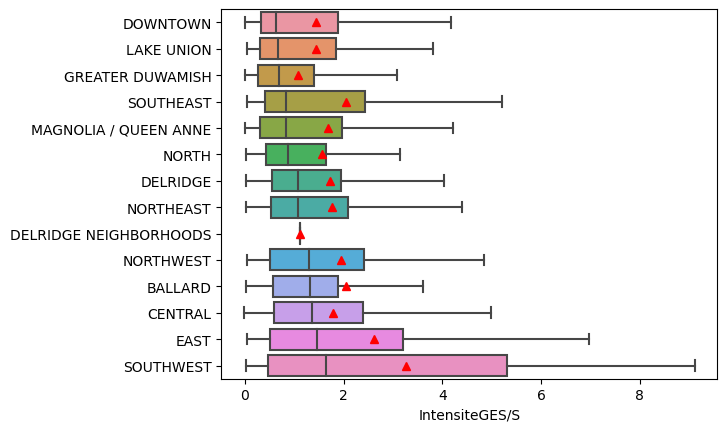

In [58]:
boxplot(data=data, var_quali='Quartier', var_quanti='IntensiteGES/S')

<Axes: xlabel='EmissionGES'>

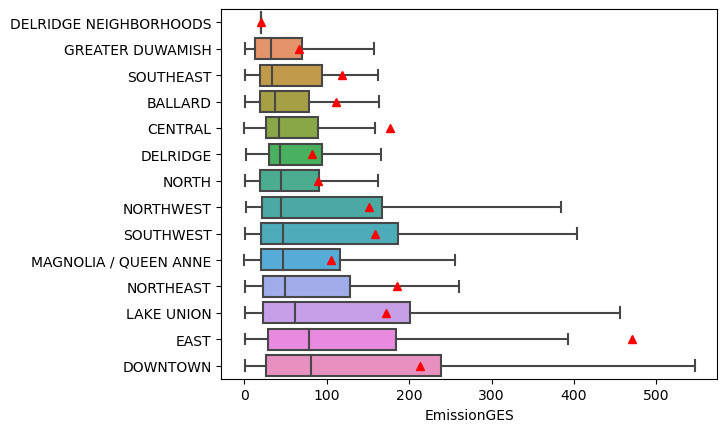

In [59]:
boxplot(data=data, var_quali='Quartier', var_quanti='EmissionGES')

#### Consommation d'énergie totale par Quartier

<Axes: xlabel='ConsoSite/S(kBtu/sf)'>

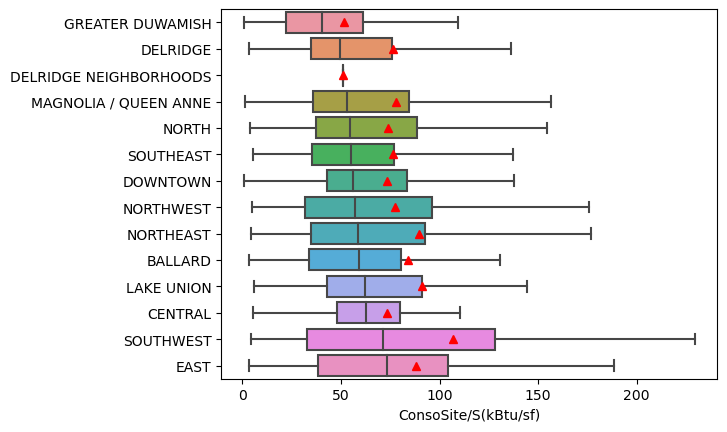

In [60]:
boxplot(data=data, var_quali='Quartier', var_quanti='ConsoSite/S(kBtu/sf)')

<Axes: xlabel='ConsoSiteTot(kBtu)'>

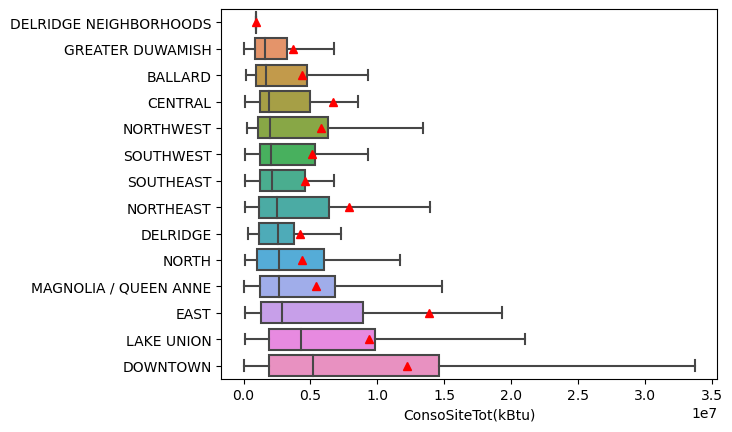

In [61]:
boxplot(data=data, var_quali='Quartier', var_quanti='ConsoSiteTot(kBtu)')

### Analyse par Utilisation

In [62]:
var_cibles = ['ConsoSite/S(kBtu/sf)', 'ConsoSiteTot(kBtu)', 'EmissionGES', 'IntensiteGES/S']

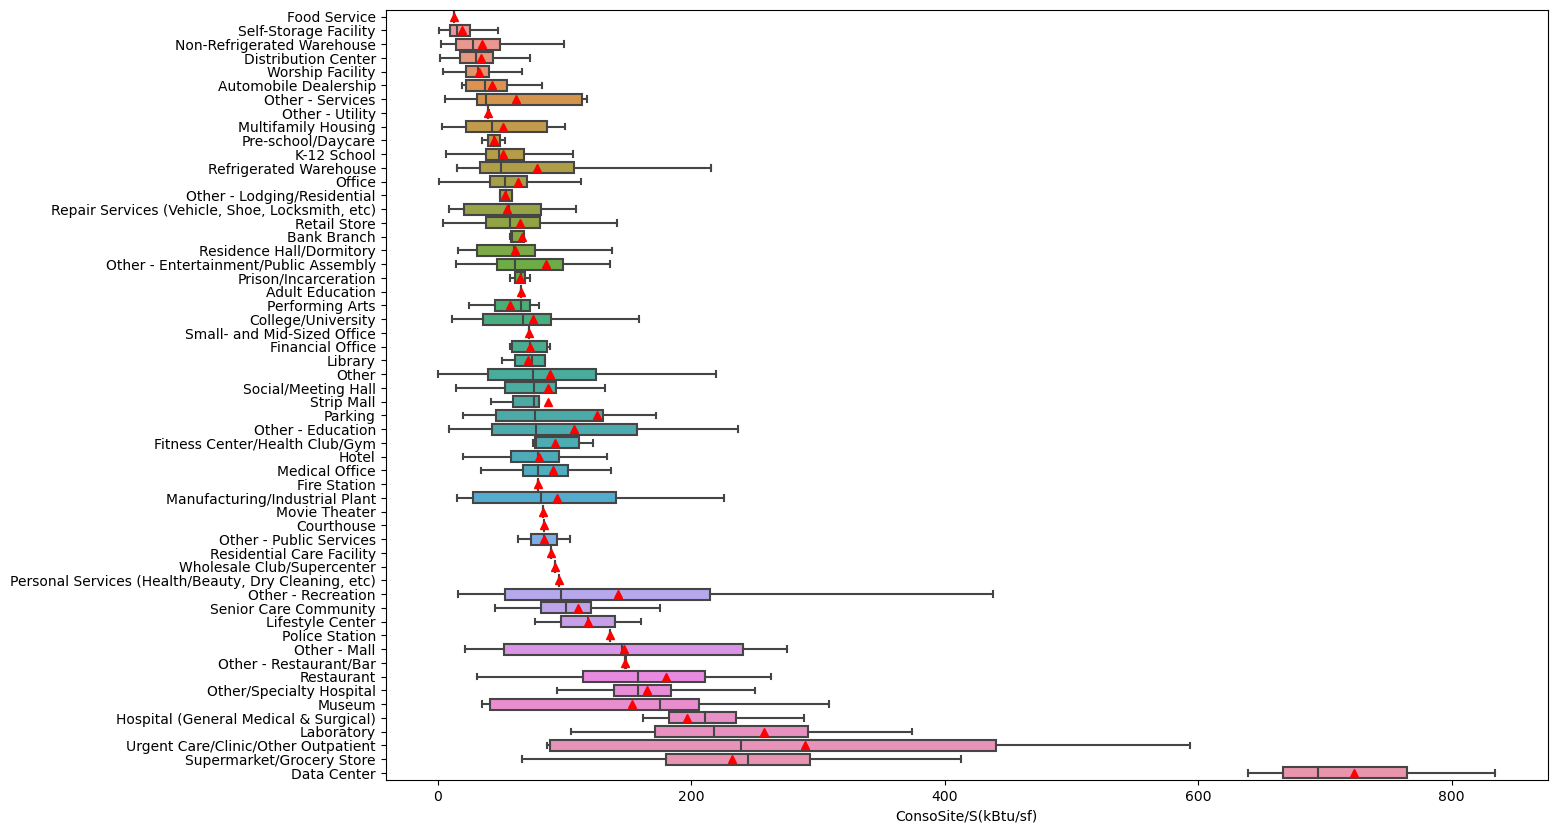

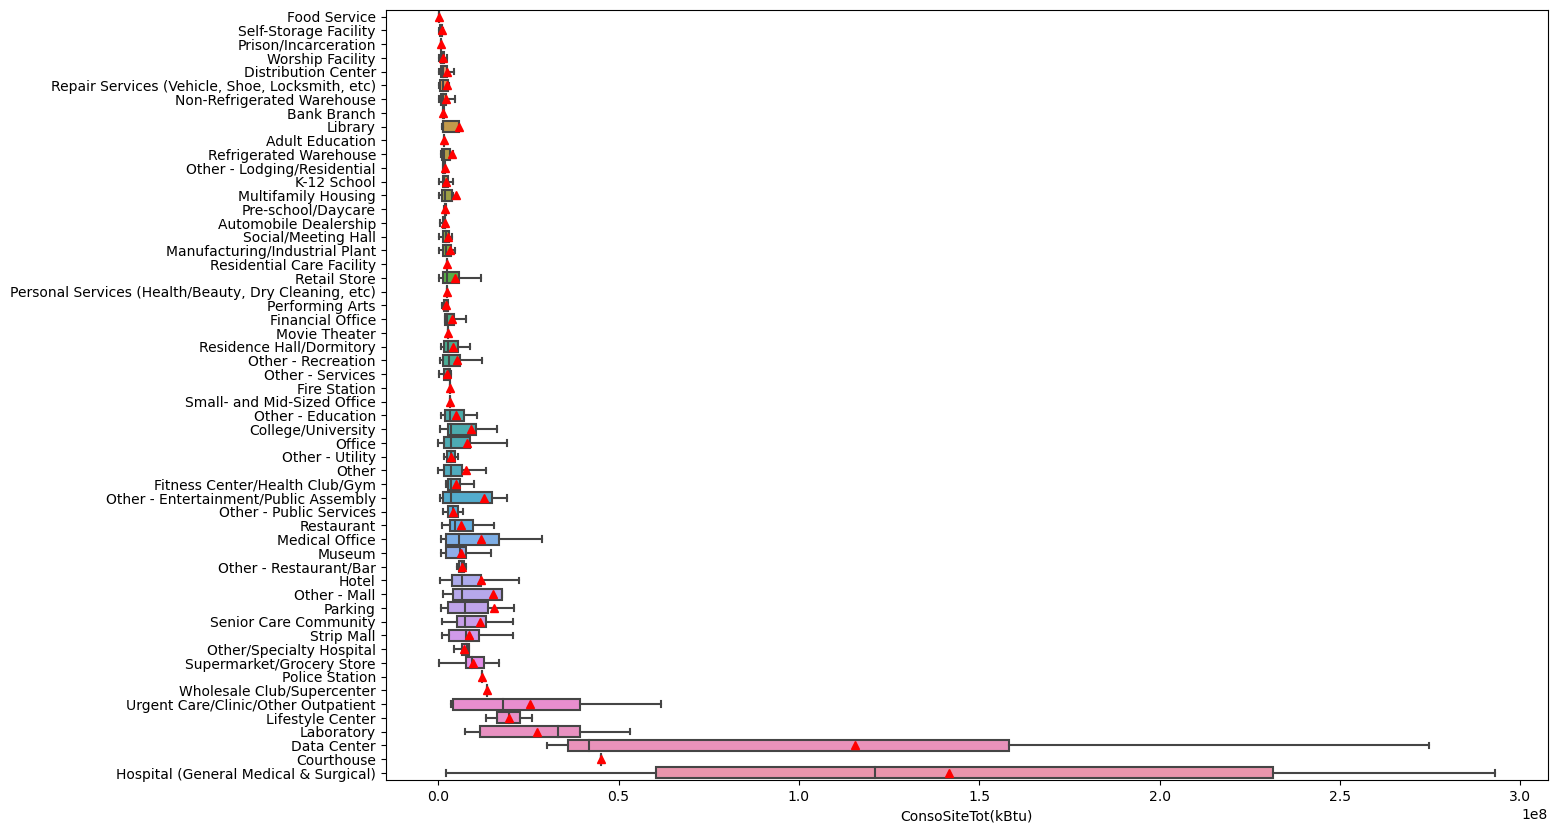

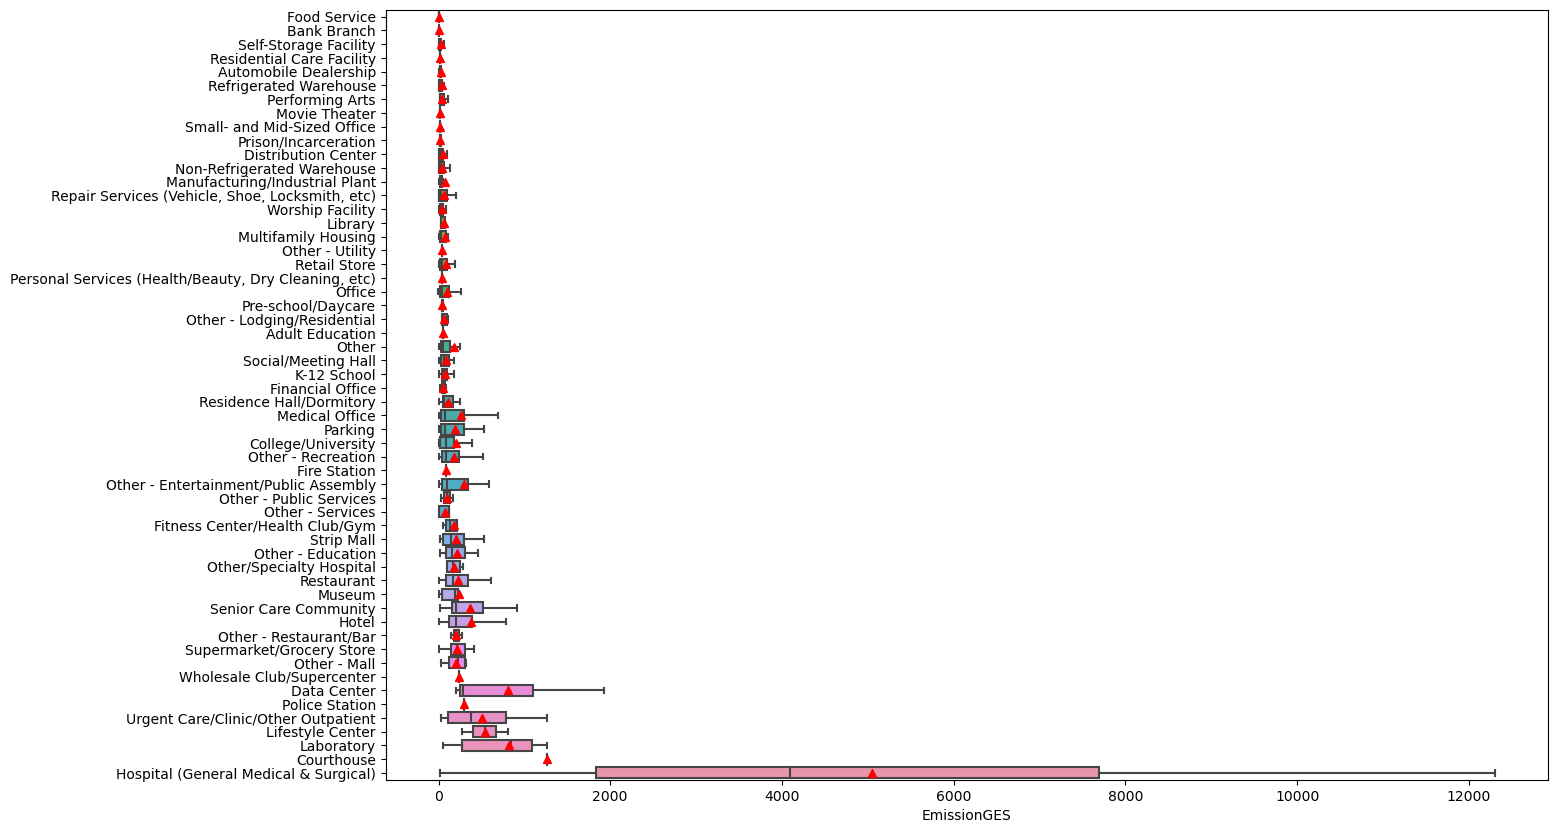

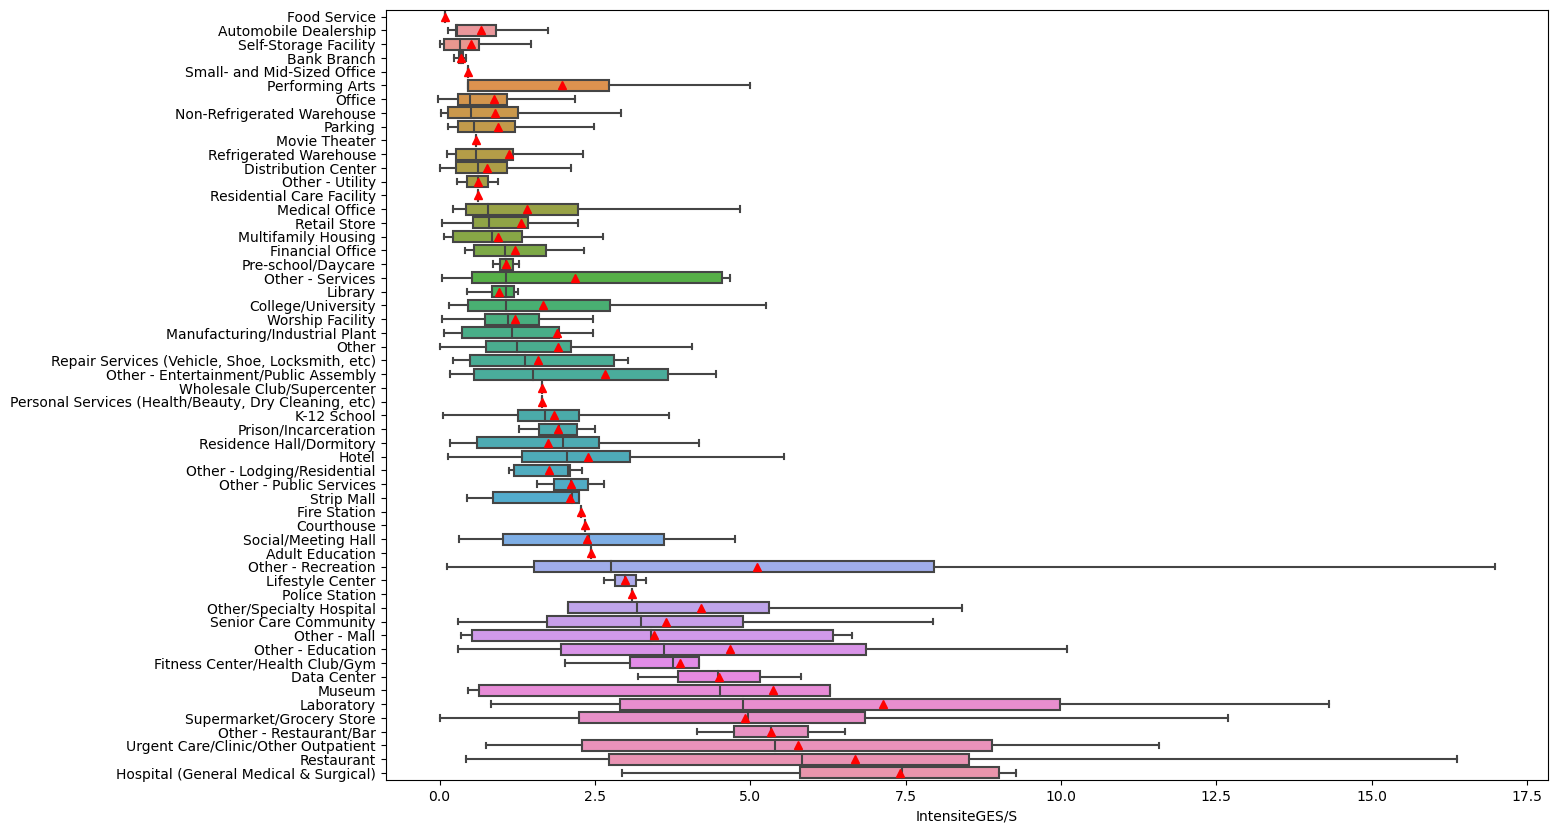

In [63]:
for var in var_cibles : 
    plt.figure(figsize=(15,10))
    boxplot(data=data, var_quali='UtilisationPrincipale', var_quanti=var)

### Analyse par rapport à l'âge du bâtiment

In [64]:
# création de 4 tranches d'age d'ancienneté des bâtiments
def tranche_age(value):
    if value < data['AgeBatiment'].max()/4 : 
        return '[0,29['
    if (value >= data['AgeBatiment'].max()/4) & (value < 2*(data['AgeBatiment'].max()/4)) : 
        return '[29,58['  
    if (value >= 2*(data['AgeBatiment'].max()/4)) & (value < 3*(data['AgeBatiment'].max()/4)) : 
        return '[58,87[' 
    if (value >= 3*(data['AgeBatiment'].max()/4)) : 
        return '[87,116[' 

In [65]:
data['TrancheAge'] = data['AgeBatiment'].apply(tranche_age)

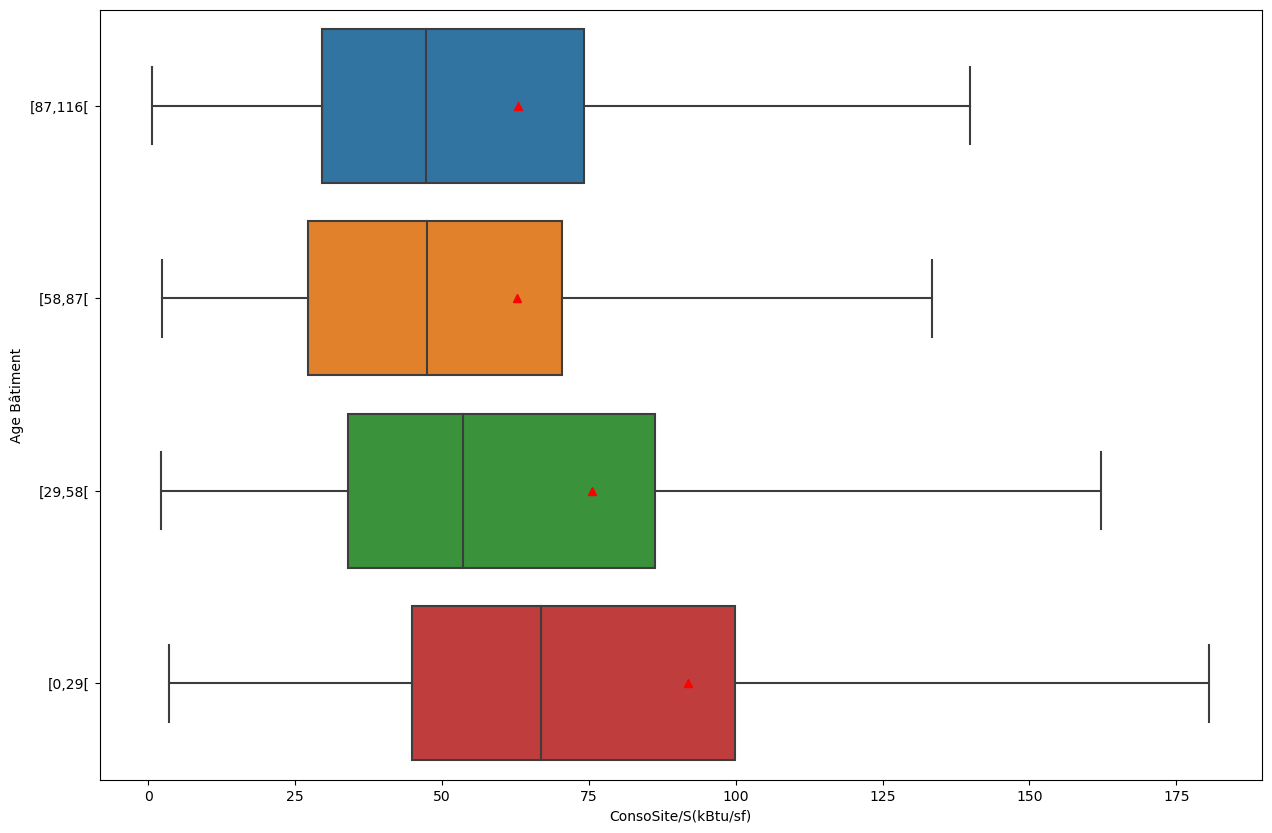

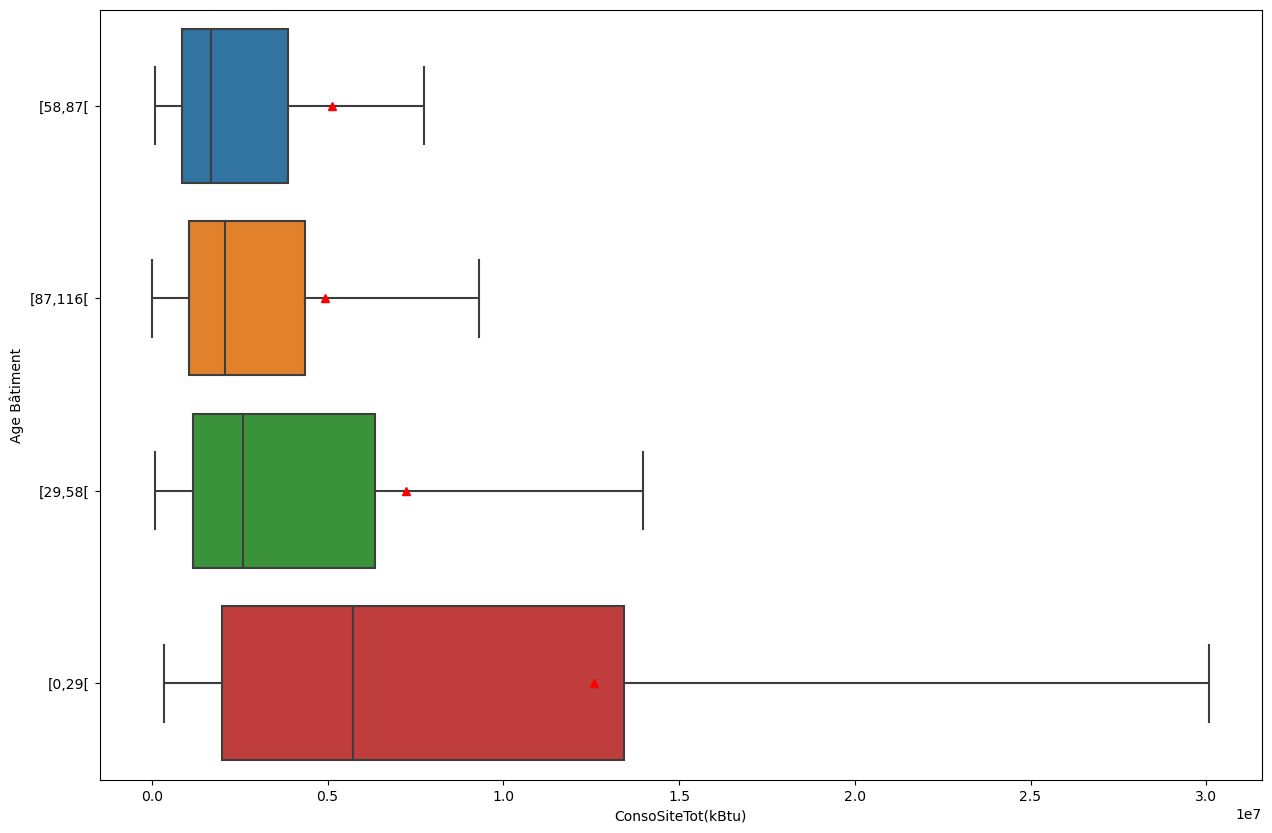

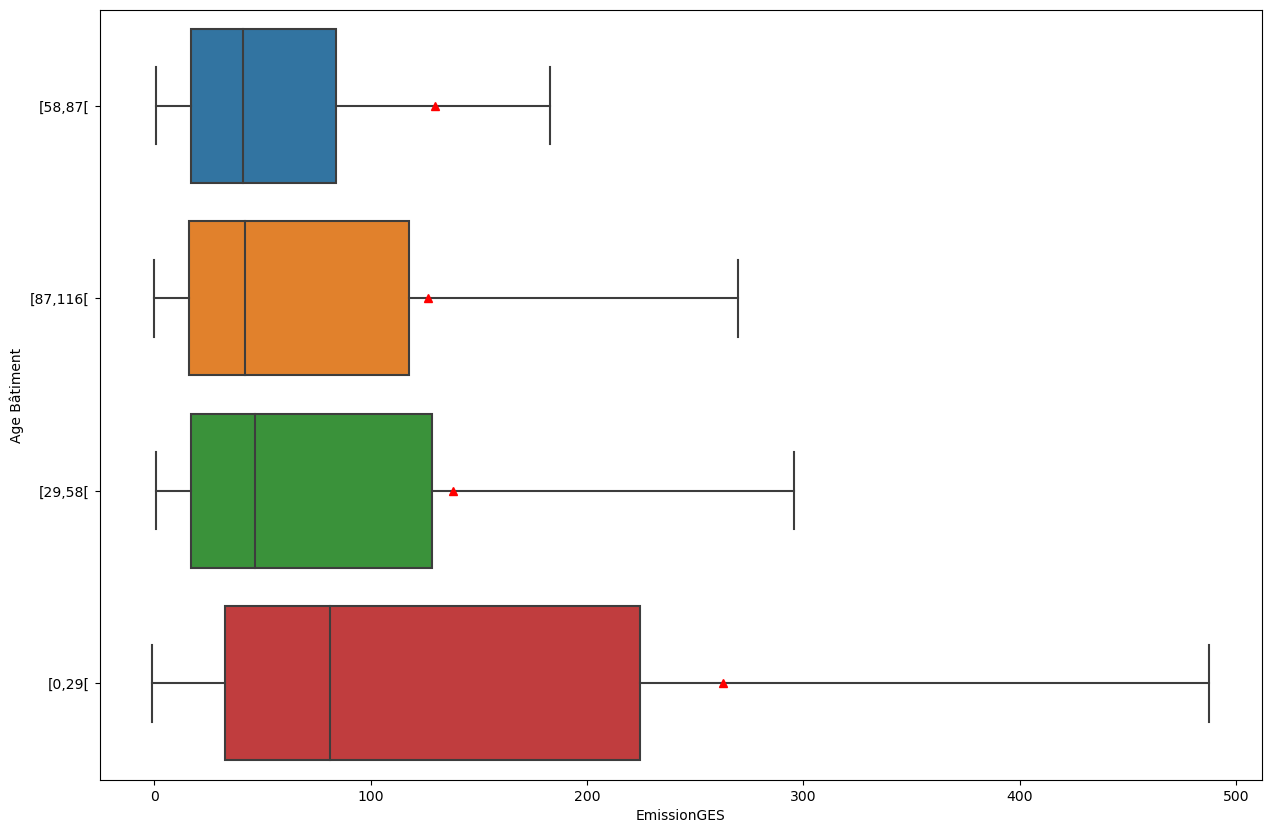

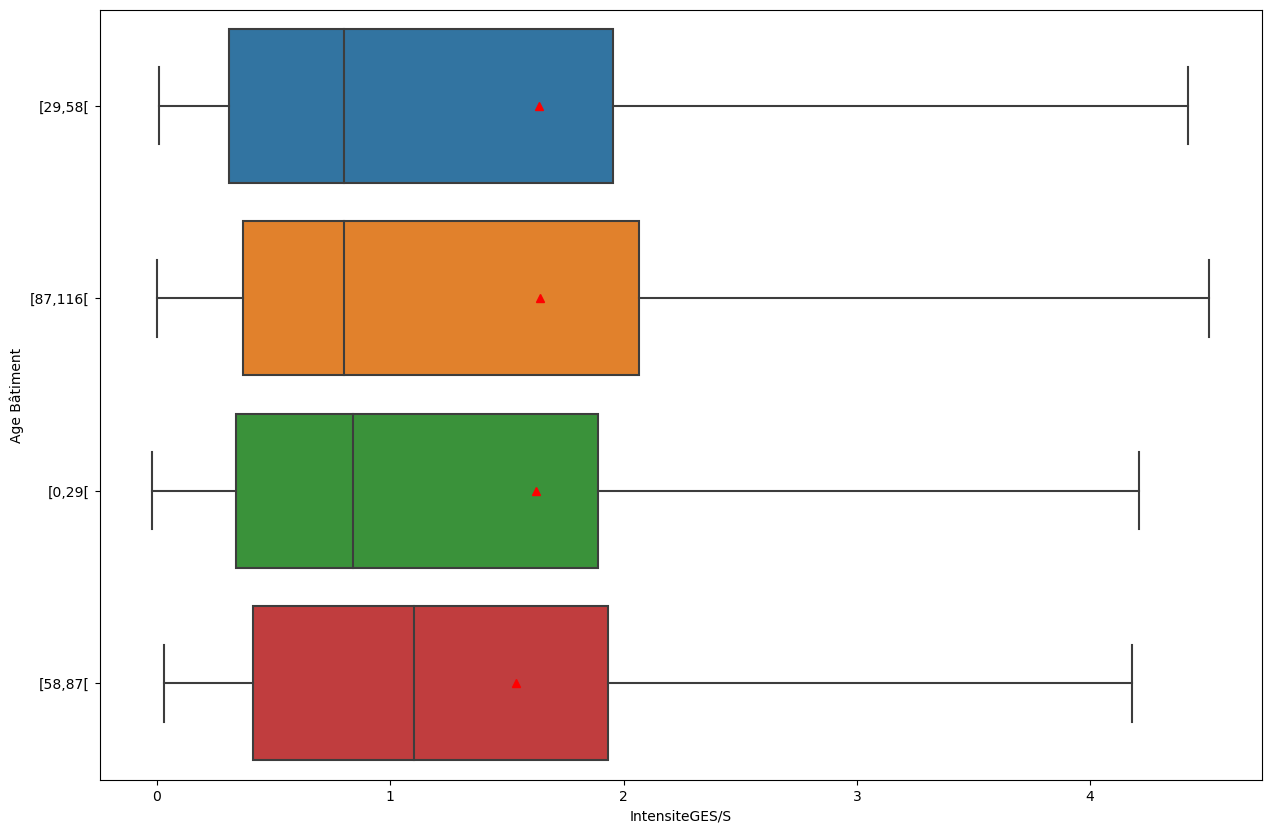

In [66]:
for var in var_cibles : 
    plt.figure(figsize=(15,10))
    boxplot(data=data, var_quali='TrancheAge', var_quanti=var)
    plt.ylabel('Age Bâtiment')

Ces graphiques indiquent que les bâtiments récents consomment plus d'énergie que les anciens bâtiments et il semblerait qu'il soit plus volumineux globalement.  
On voit aussi que les batiments récents émettent plus de GES en relatif mais surtout en absolu potentiellement à cause du volume des nouveaux batiments.

### Analyse par rapport aux nombres d'utilisations par bâtiment

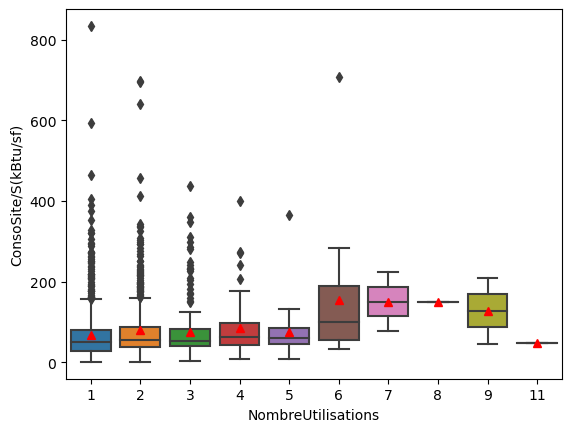

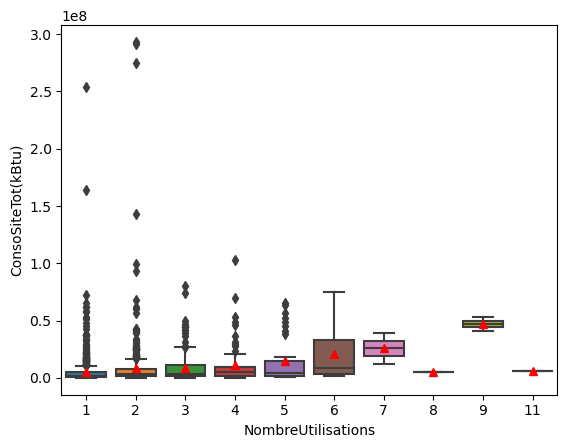

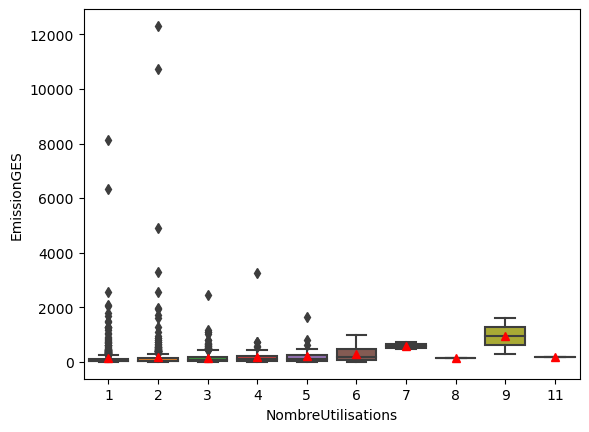

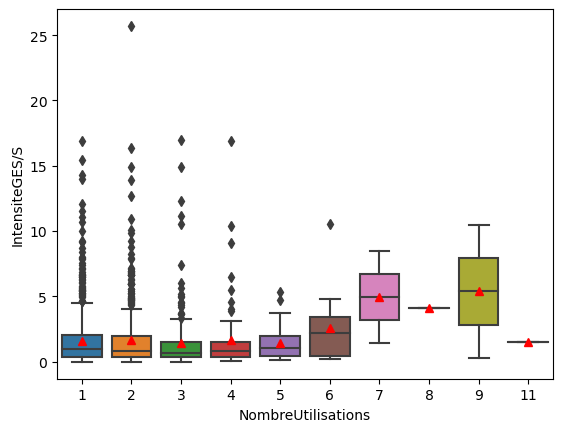

In [67]:
for var in var_cibles:
    sns.boxplot(data=data, x='NombreUtilisations', y=var, showmeans=True,
                meanprops={"markeredgecolor": "red", "markerfacecolor":"red"})
    plt.show()

Il semblerait que les buildings aux utilisations diversifiées consommeraient plus d'énergie et émetterait plus de gaz à effet de serre.  
La tendance semble cependant légère.

### Analyse par rapport à la Conformité

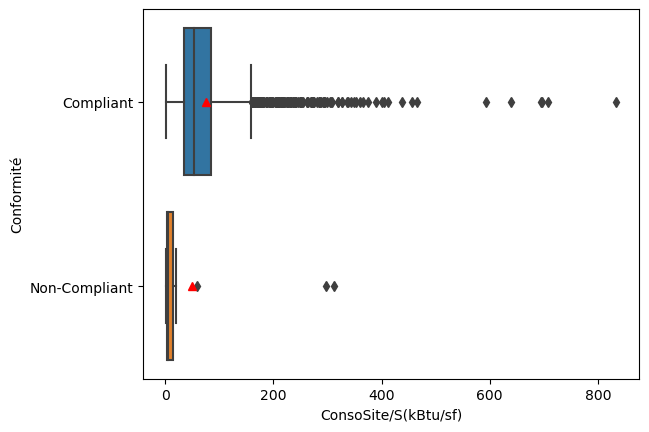

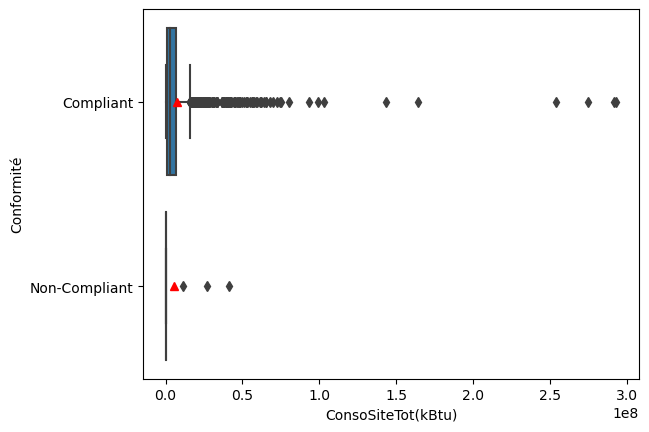

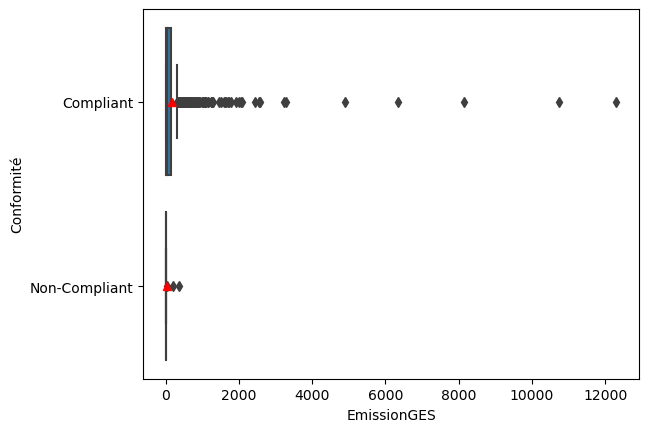

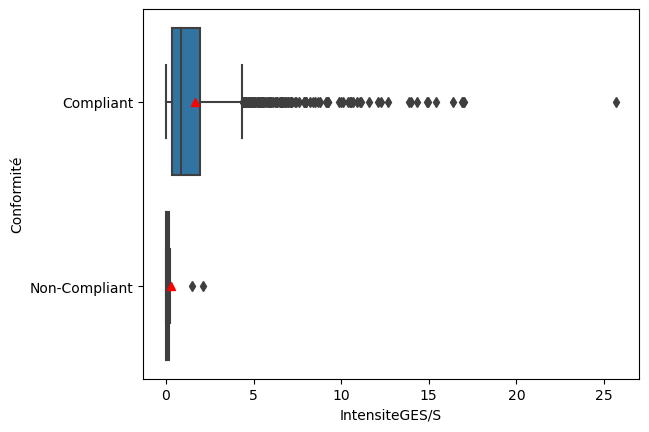

In [68]:
for var in var_cibles:
    sns.boxplot(data=data, y='Conformité', x=var, showmeans=True, orient='h',
                meanprops={"markeredgecolor": "red", "markerfacecolor":"red"})
    plt.show()

Les buildings conforme rejetteraient plus de GES et consommeraient plus d'énergie.  
Ce résultat est biaisé car beaucoup de buildings sonr conformes.

Ces graphiques révèlent aussi la présence de beaucoup de valeurs aberrantes.

### Nombre étages

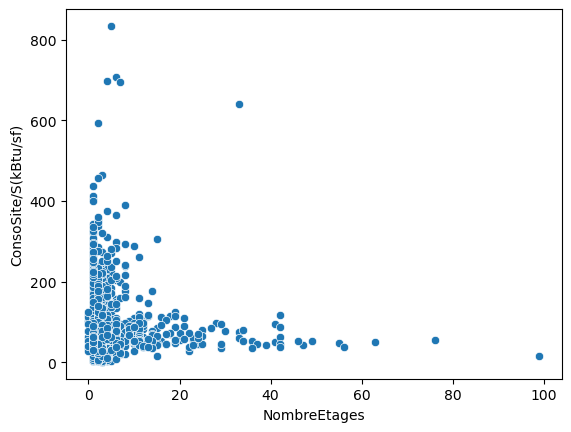

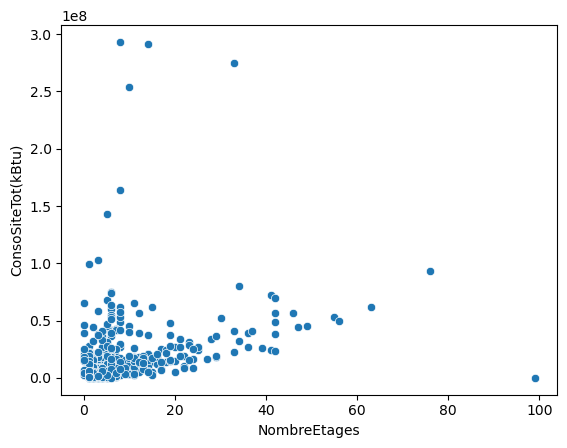

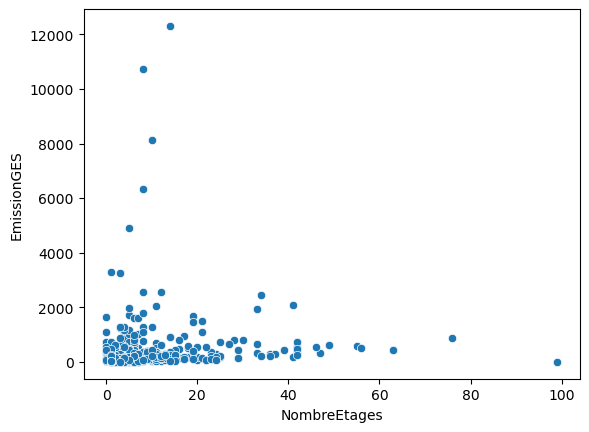

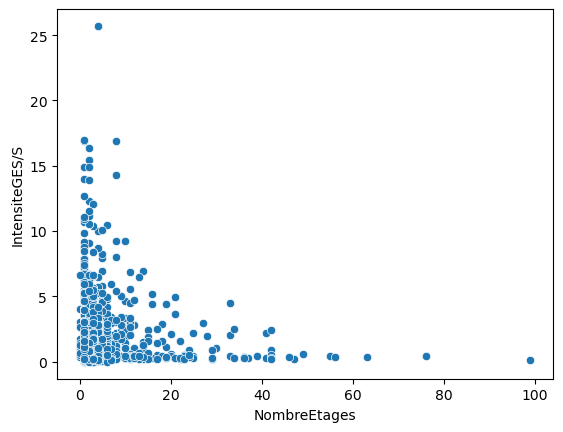

In [69]:
for var in var_cibles:    
    sns.scatterplot(data, x='NombreEtages', y=var)
    plt.show()

In [70]:
data.corr()['NombreEtages'][var_cibles]

ConsoSite/S(kBtu/sf)    0.013790
ConsoSiteTot(kBtu)      0.390150
EmissionGES             0.188643
IntensiteGES/S         -0.056322
Name: NombreEtages, dtype: float64

Il semblerait que le nombre d'étages soit décorrélé des variables cibles si on les rapporte à la surface.  
Il y a une légère corrélation entre le nombre d'étage et la quantité totale d'émission de gaz à effet de serre et une corrélation qui semble significative avec les consommations totales d'énergie.

### Nombre de batiment

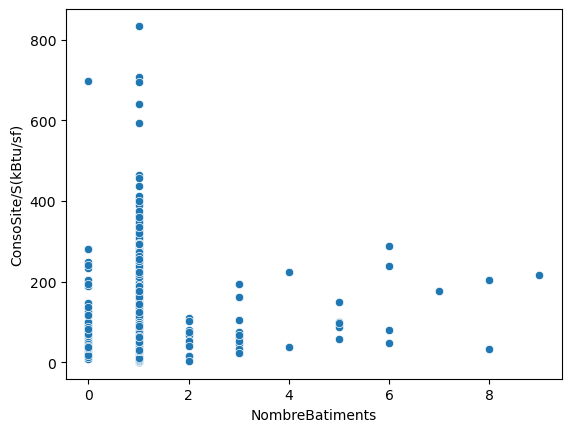

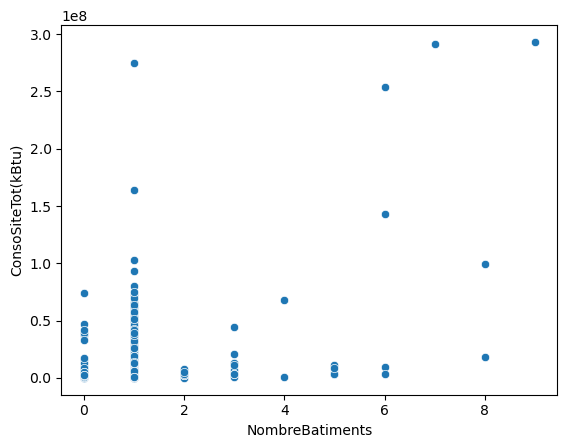

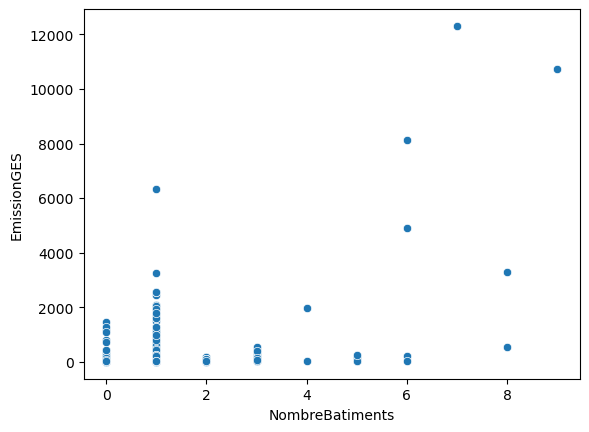

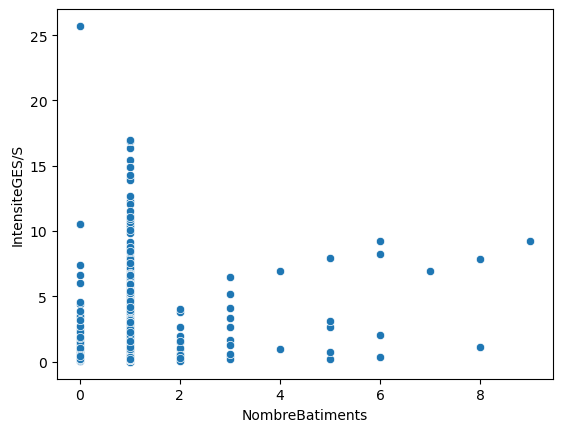

In [71]:
for var in var_cibles:    
    sns.scatterplot(data, x='NombreBatiments', y=var)
    plt.show()

Il y a peu de données à partie de 4 bâtiments et plus, peu significatif donc pour comparer avec le reste.

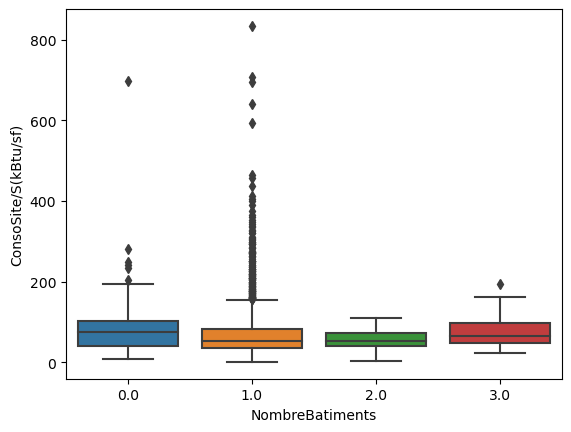

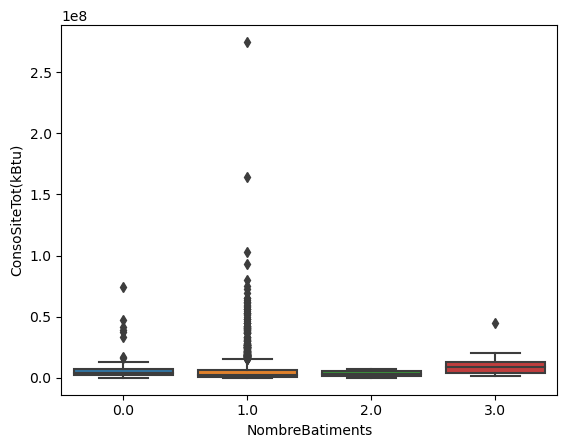

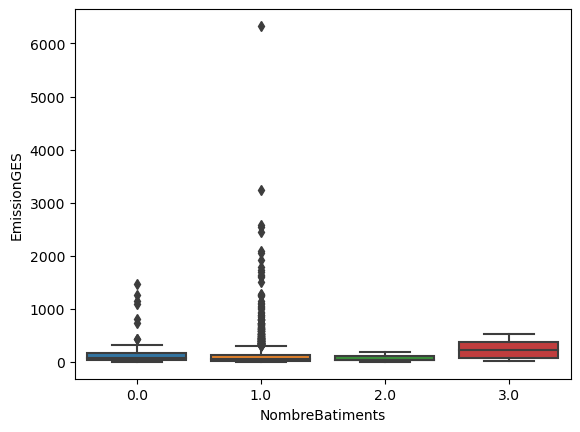

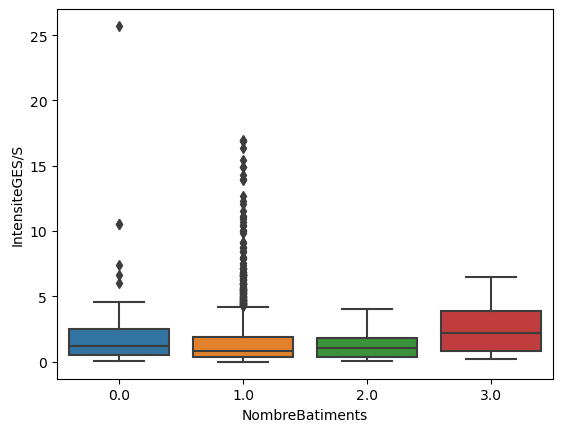

In [72]:
for var in var_cibles:    
    sns.boxplot(data[data['NombreBatiments']<4], x='NombreBatiments', y=var)
    plt.show()

Concernant les buildings avec 3 bâtiments et moins, il est difficile d'observer une tendance entre les groupes.

## Analyses univariées

### Analyse univariée des variables cibles

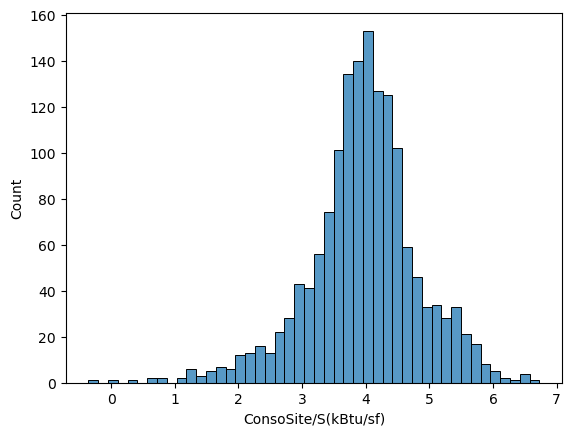

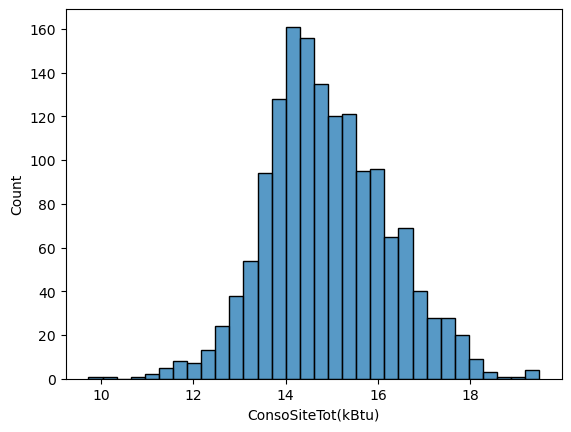

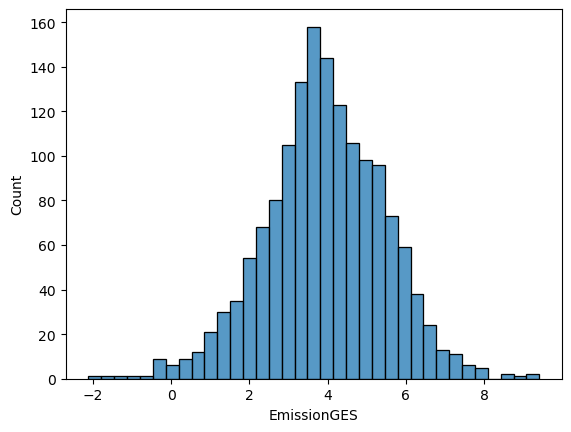

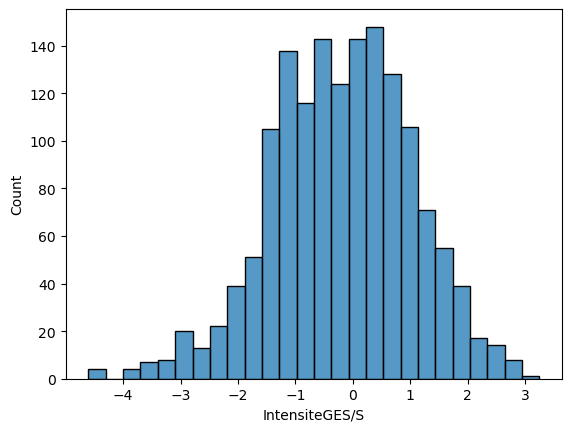

In [73]:
for var in var_cibles:
    sns.histplot(np.log(data[var]))
    plt.show()

Les variables cibles sont étalées à droite et présentent plusieurs outliers.  
Une transformation fonctionnerai pour rendre normale la distribution.

### Analyse univariées des variables numériques

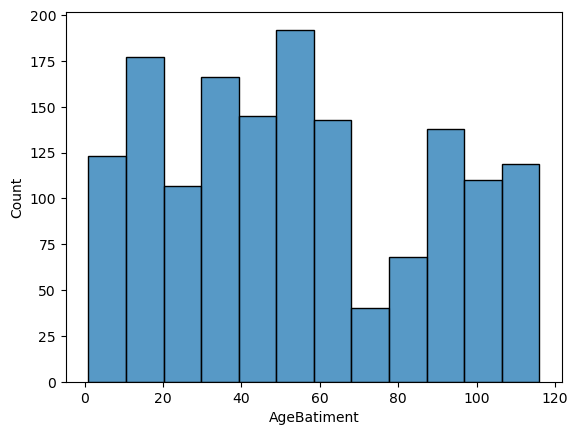

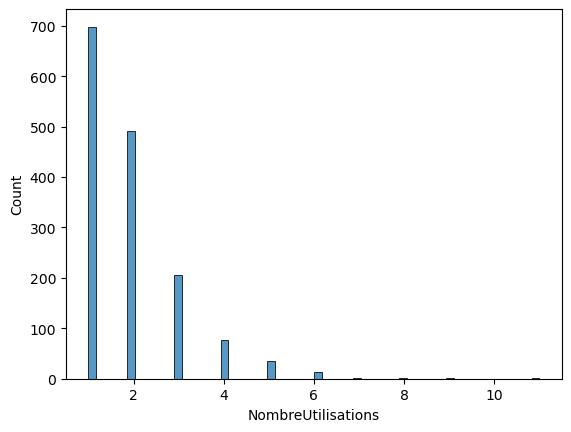

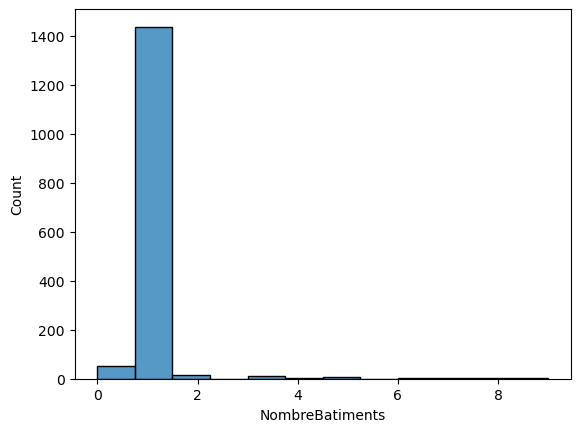

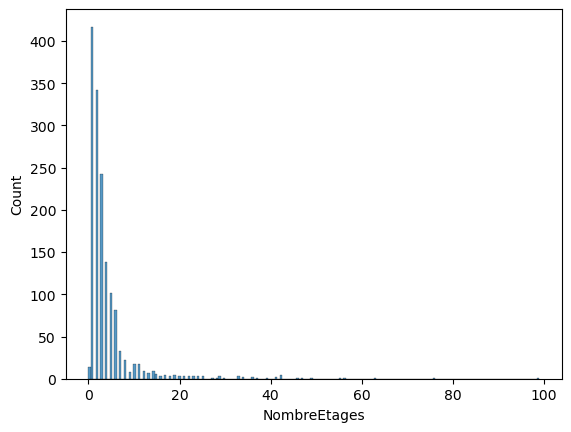

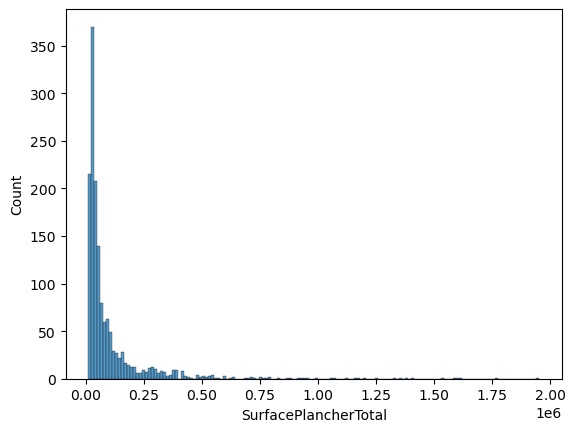

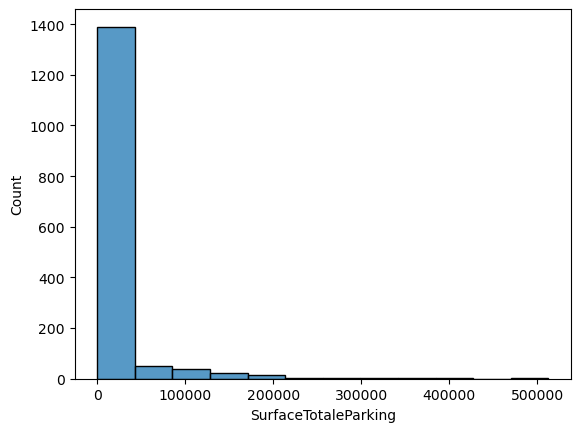

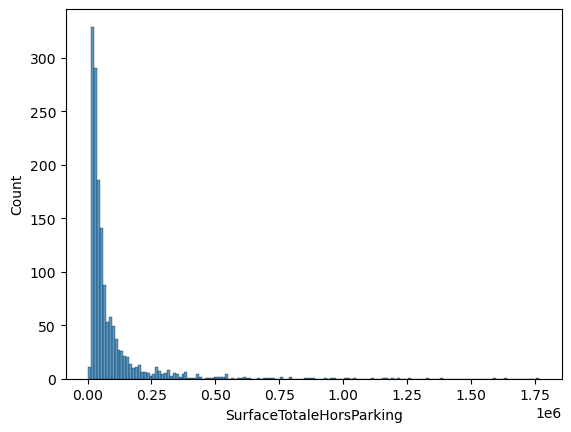

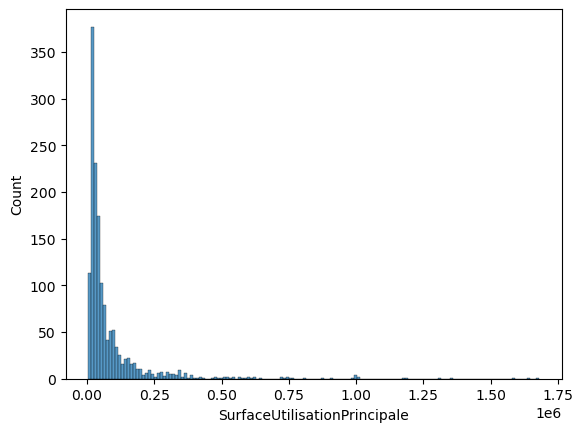

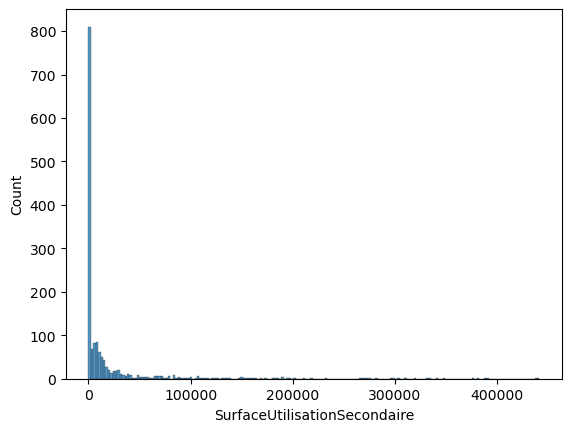

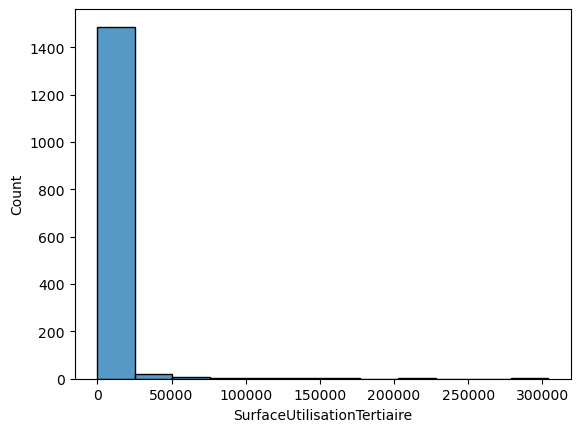

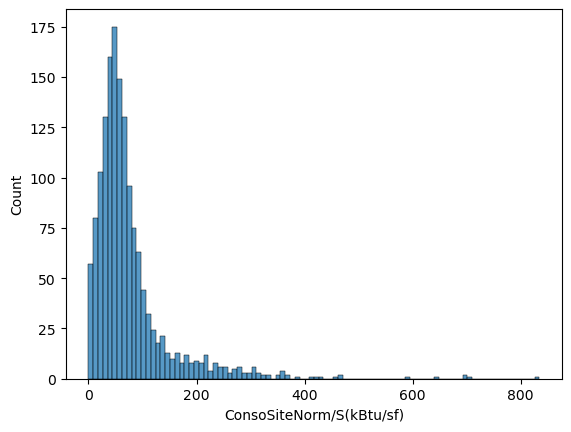

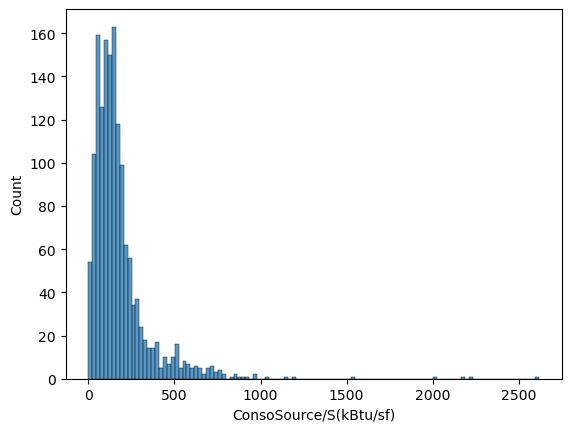

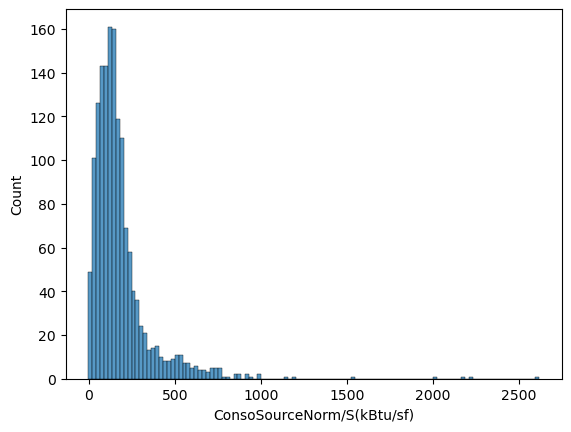

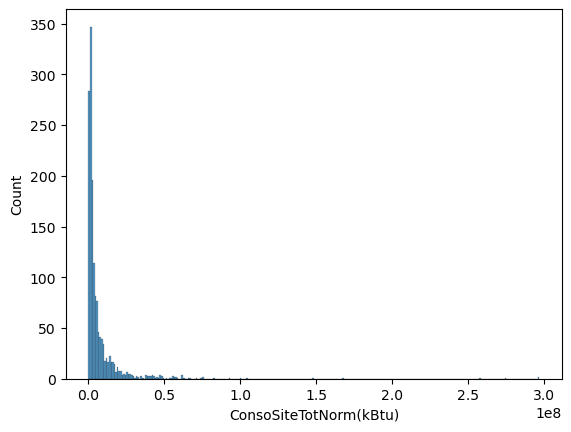

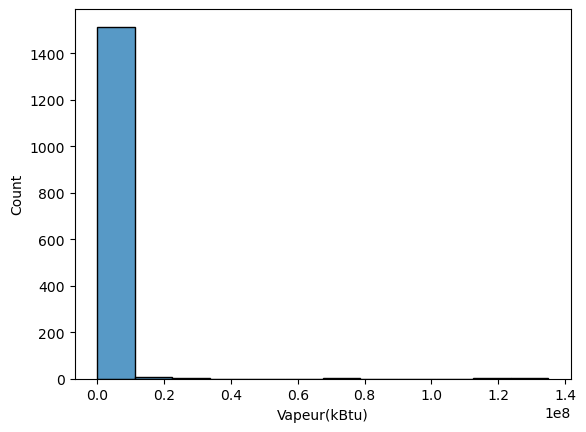

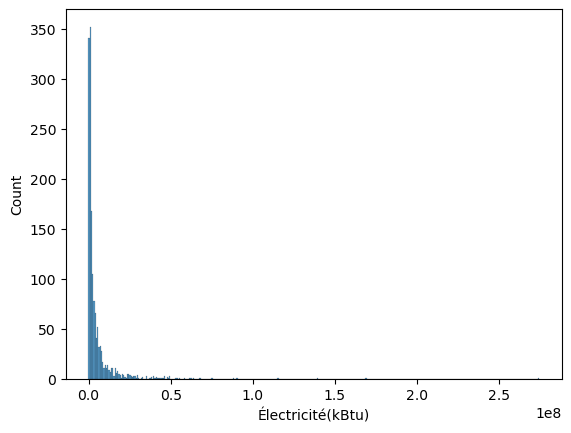

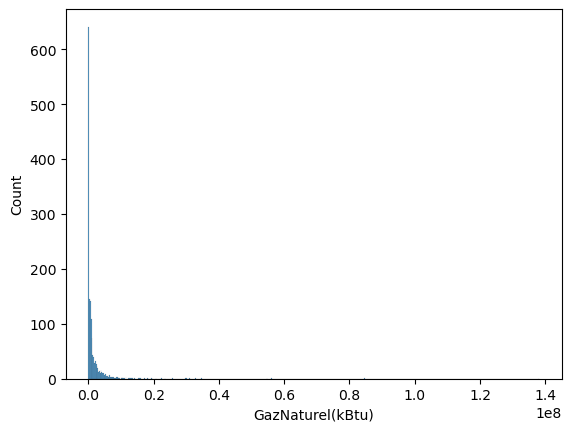

In [74]:
var_num = data.select_dtypes(exclude='object').drop(columns=var_cibles).columns

for var in var_num : 
    sns.histplot(data[var])
    plt.show()

Pour toutes les variables, on a un pic proche de 0, puis la distribution de la variable s'étale ensuite vers la droite plus ou moins.  
Cet étalement est d'autant plus important que les valeurs aberrantes sont significatives par rapport au reste des données.

Une transformation au logarithme normaliserait la distribution de ces variables.

### Matrice de corrélation

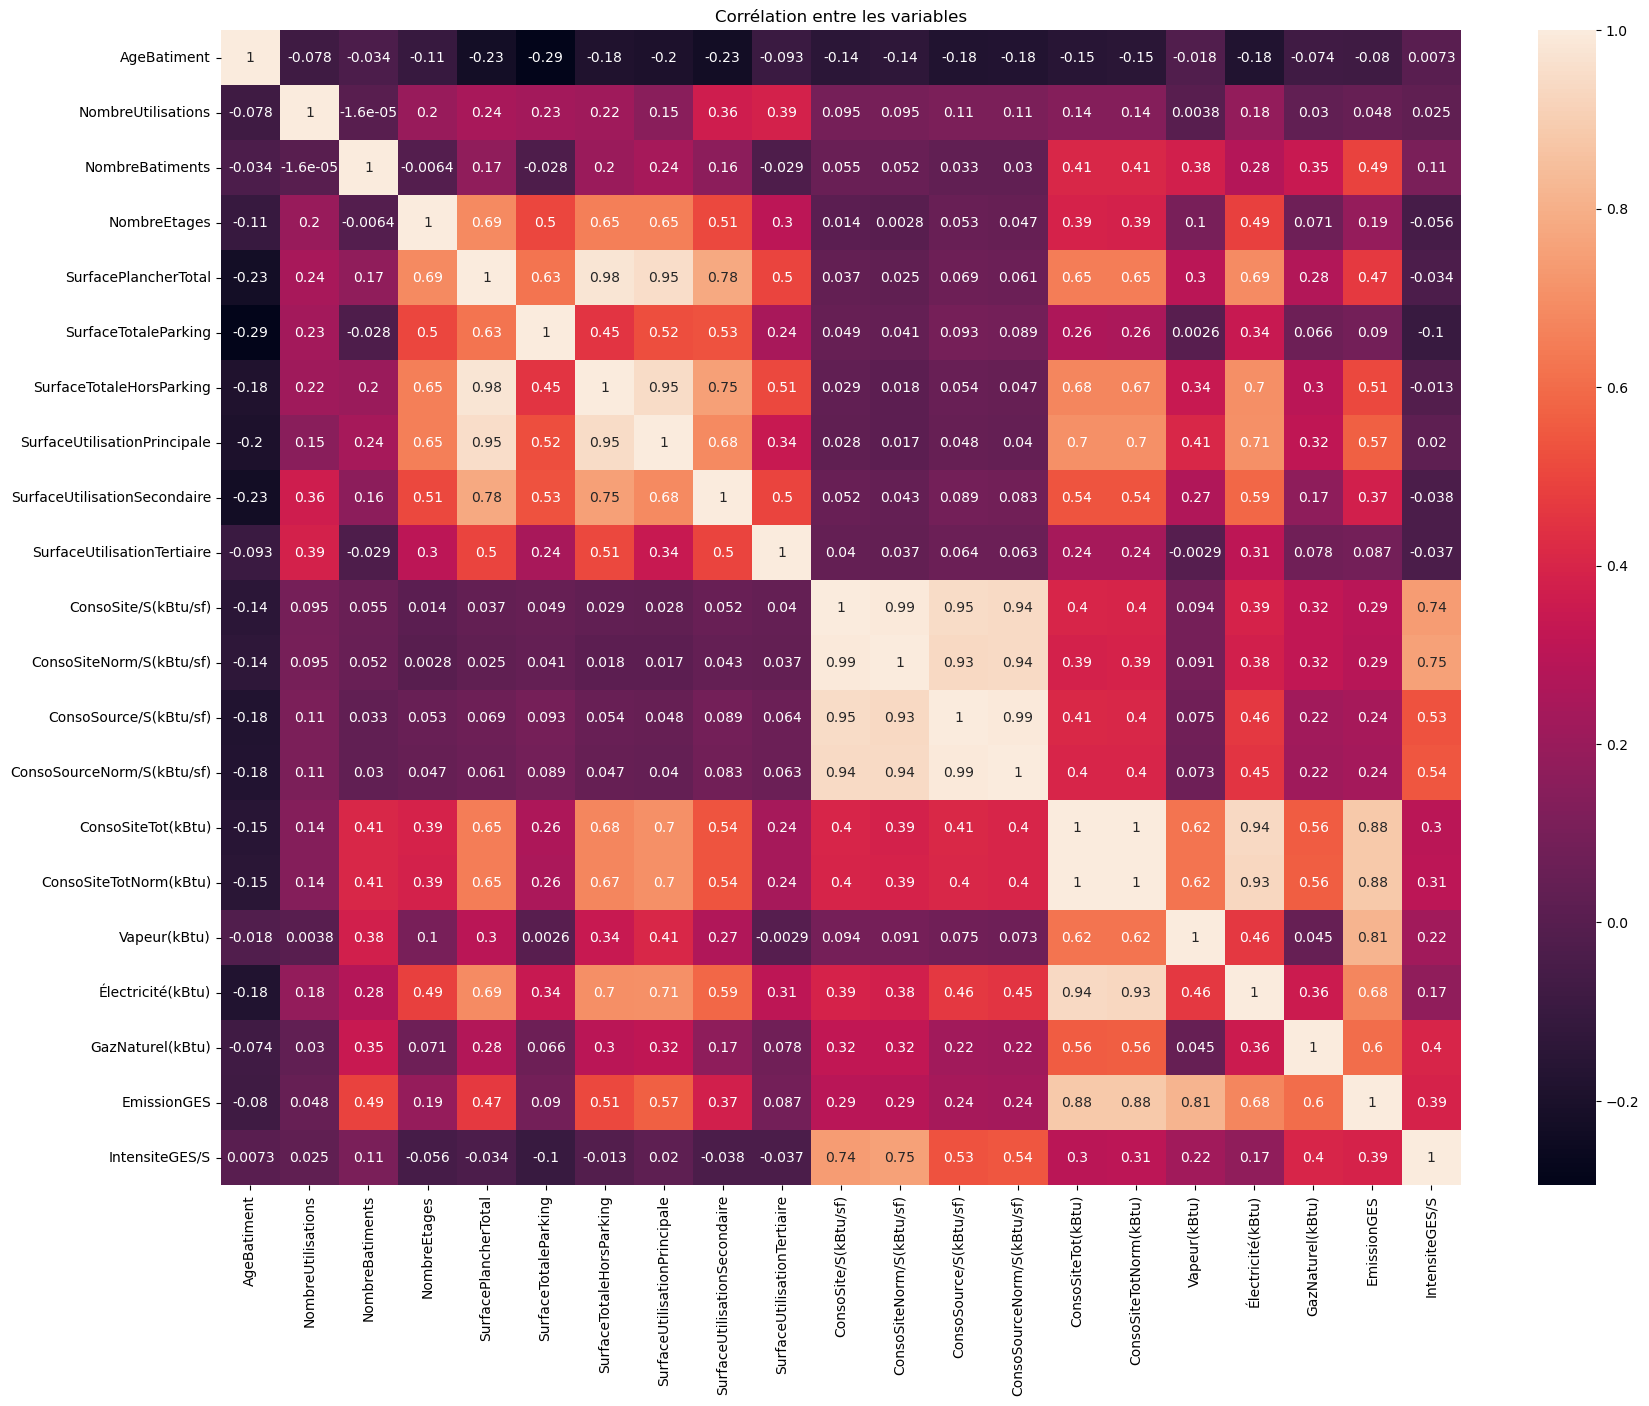

In [75]:
plt.figure(figsize=(20,15))

plt.title("Corrélation entre les variables")

sns.heatmap(data.corr(), annot=True)

plt.show()

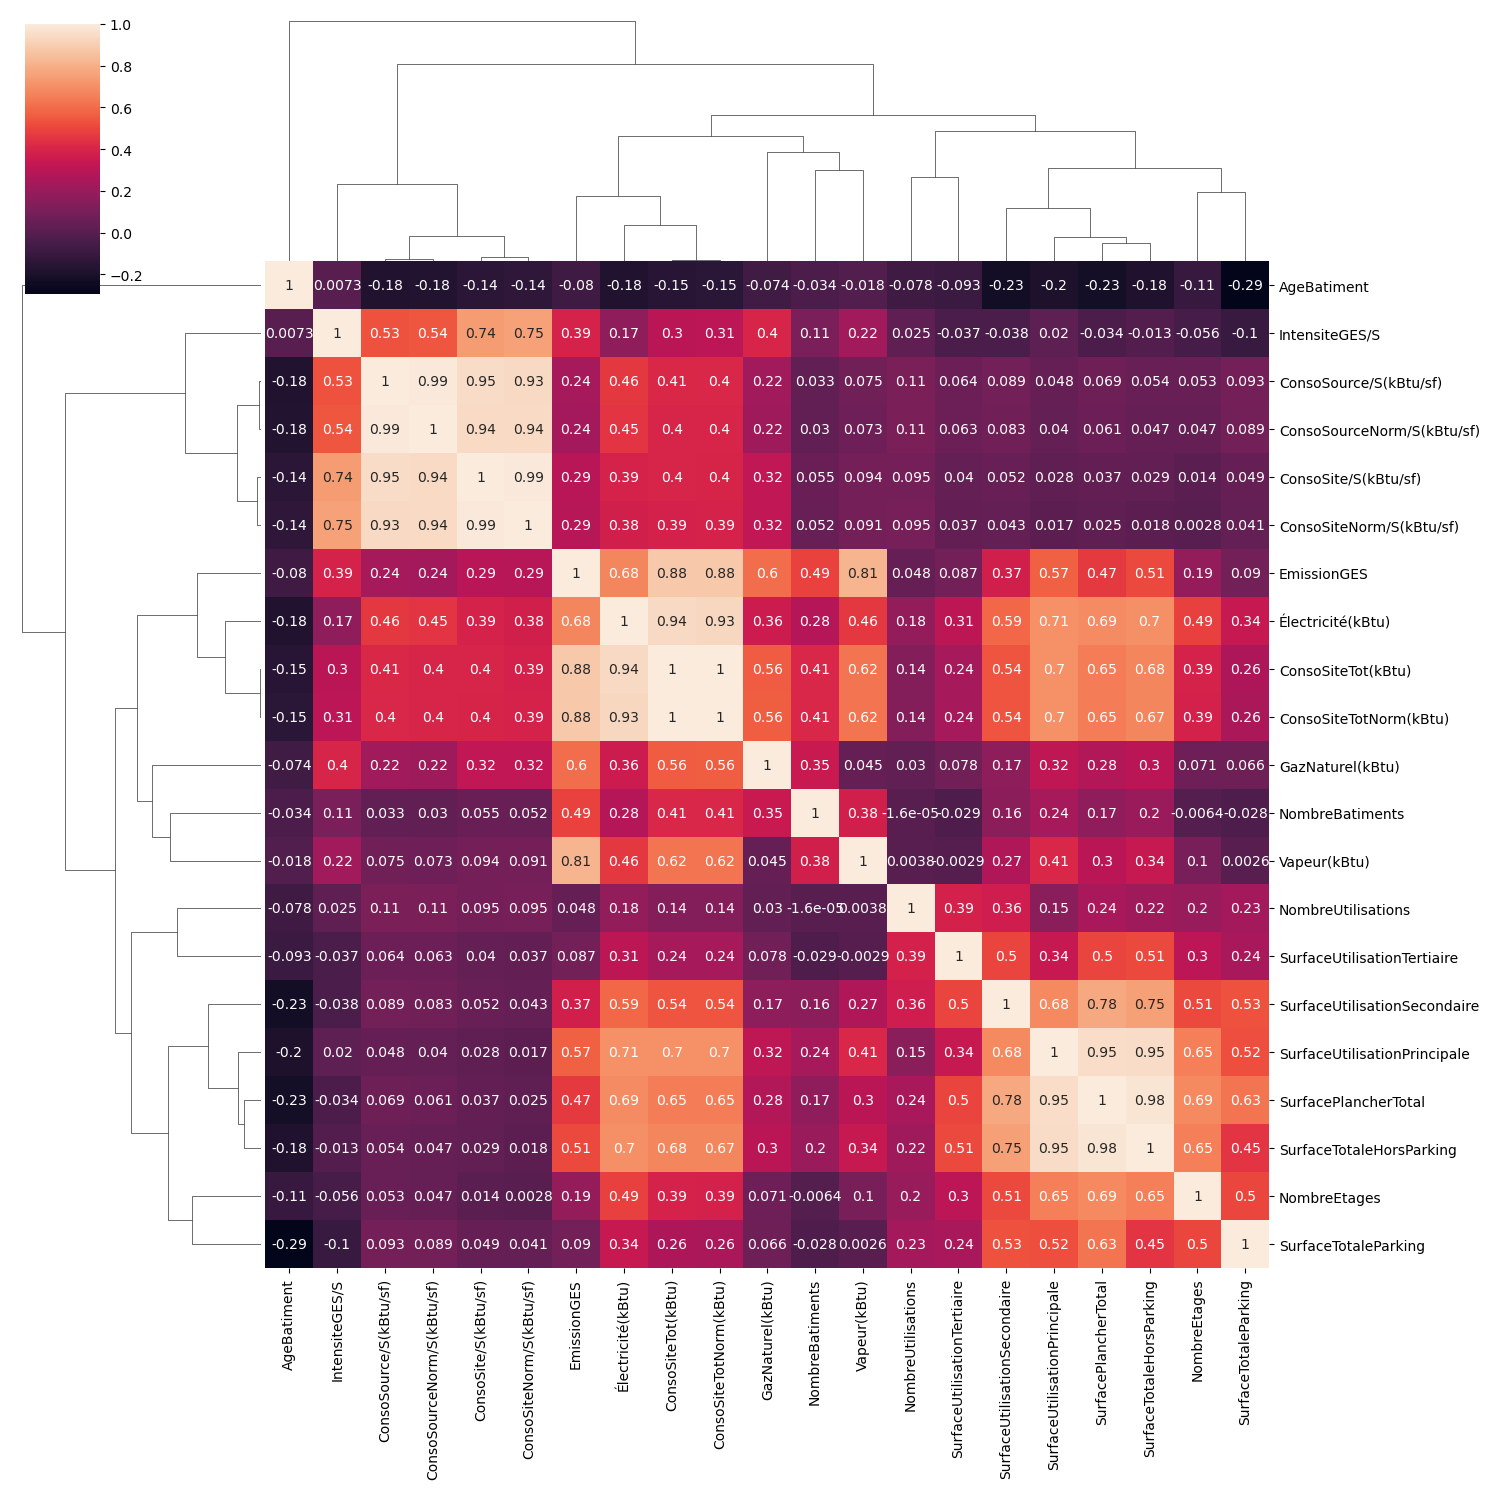

In [76]:
sns.clustermap(data.corr(), annot=True, figsize=(15,15))

plt.show()

## Première évaluation de l'EnergyStarScore

Je fais une première évaluation de l'EnergyStarScore en observant ses liens avec les Emissions de gaz à effet de serre et la quantité d'énergie consommée.

In [77]:
# je créer une copie car je ne garderai pas l'EnergyStarScore dans
# la modélisation
df = data.copy()
df['EnergyStarScore'] = energy_star_score

### Par rapport aux émissions de gaz à effet de serre

<Axes: xlabel='EnergyStarScore', ylabel='IntensiteGES/S'>

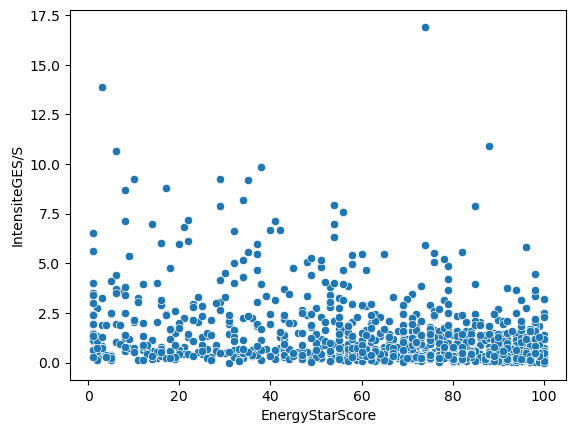

In [78]:
# EnergyStarScore en fonction des émissions des gaz à effet de serre
sns.scatterplot(data=df, x='EnergyStarScore', y='IntensiteGES/S')

<Axes: xlabel='EnergyStarScore', ylabel='EmissionGES'>

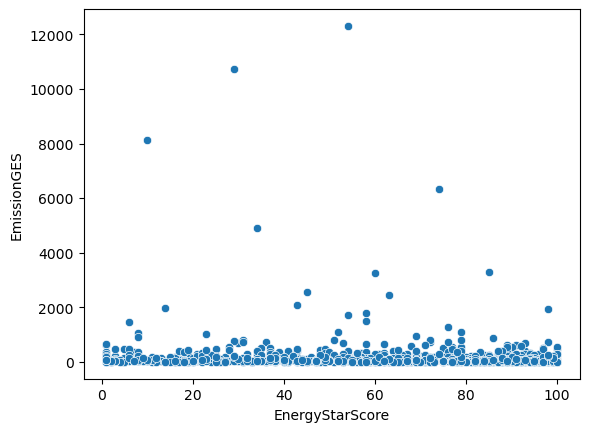

In [79]:
sns.scatterplot(data=df, x='EnergyStarScore', y='EmissionGES')

L'Energy Star Score semble totalement décorrélé des Emissions de Gaz à effet de serre (absolu ou relative).

### Par rapport aux consommations totales d'énergie

<Axes: xlabel='EnergyStarScore', ylabel='ConsoSite/S(kBtu/sf)'>

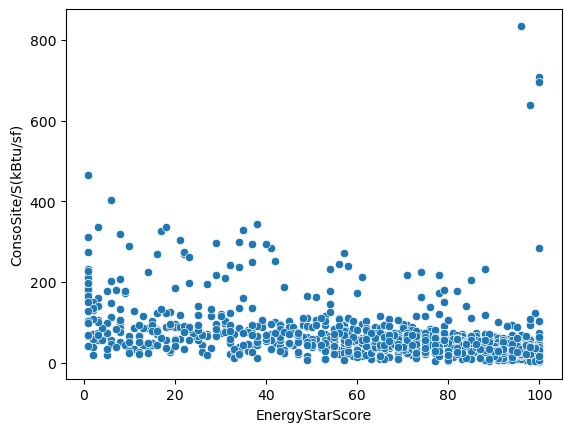

In [80]:
# EnergyStarScore en fonction des consommations d'énergie
sns.scatterplot(data=df, x='EnergyStarScore', y='ConsoSite/S(kBtu/sf)')

<Axes: xlabel='EnergyStarScore', ylabel='ConsoSiteTot(kBtu)'>

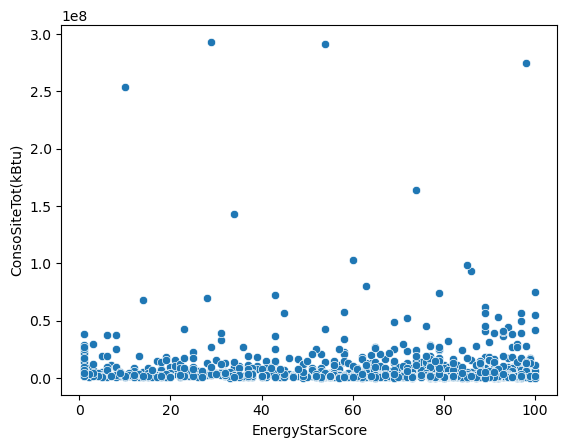

In [81]:
sns.scatterplot(data=df, x='EnergyStarScore', y='ConsoSiteTot(kBtu)')

L'Energy Star Score semble totalement décorrélé des consommations totales d'énergie (absolu ou relative). Ce qui est contre-intuitif.

In [82]:
df.corr()['EnergyStarScore'][['ConsoSite/S(kBtu/sf)', 'IntensiteGES/S']]

ConsoSite/S(kBtu/sf)   -0.330083
IntensiteGES/S         -0.307337
Name: EnergyStarScore, dtype: float64

On observe tout de même une légère corrélation négative entre les variables (environ -0.3 pour les 2 variables par rapport à l'EnergyStarScore) mais le lien entre un bon score et peu de consommations d'énergie ou d'émissions de gaz à effet de serre n'est pas automatique.

### Création de nouvelles variables

In [83]:
data.head()

Quartier  AgeBatiment  NombreUtilisations PremierTypePropriete  \
0  DOWNTOWN           89                   1                Hotel   
1  DOWNTOWN           20                   3                Hotel   
2  DOWNTOWN           47                   1                Hotel   
3  DOWNTOWN           90                   1                Hotel   
4  DOWNTOWN           36                   3                Hotel   

   NombreBatiments  NombreEtages  SurfacePlancherTotal  SurfaceTotaleParking  \
0              1.0            12                 88434                     0   
1              1.0            11                103566                 15064   
2              1.0            41                956110                196718   
3              1.0            10                 61320                     0   
4              1.0            18                175580                 62000   

   SurfaceTotaleHorsParking      ListeUtilisationsBatiment  \
0                     88434                          Hotel   
1                     88502     Hotel, Parking, Restaurant   
2                    759392                          Hotel   
3                     61320                          Hotel   
4                    113580  Hotel, Parking, Swimming Pool   

  UtilisationPrincipale  SurfaceUtilisationPrincipale UtilisationSecondaire  \
0                 Hotel                       88434.0                Aucune   
1                 Hotel                       83880.0               Parking   
2                 Hotel                      756493.0                Aucune   
3                 Hotel                       61320.0                Aucune   
4                 Hotel                      123445.0               Parking   

   SurfaceUtilisationSecondaire UtilisationTertiaire  \
0                           0.0               Aucune   
1                       15064.0           Restaurant   
2                           0.0               Aucune   
3                           0.0               Aucune   
4                       68009.0        Swimming Pool   

   SurfaceUtilisationTertiaire Conformité  ConsoSite/S(kBtu/sf)  \
0                          0.0  Compliant             81.699997   
1                       4622.0  Compliant             94.800003   
2                          0.0  Compliant             96.000000   
3                          0.0  Compliant            110.800003   
4                          0.0  Compliant            114.800003   

   ConsoSiteNorm/S(kBtu/sf)  ConsoSource/S(kBtu/sf)  \
0                 84.300003              182.500000   
1                 97.900002              176.100006   
2                 97.699997              241.899994   
3                113.300003              216.199997   
4                118.699997              211.399994   

   ConsoSourceNorm/S(kBtu/sf)  ConsoSiteTot(kBtu)  ConsoSiteTotNorm(kBtu)  \
0                  189.000000           7226362.5               7456910.0   
1                  179.399994           8387933.0               8664479.0   
2                  244.100006          72587024.0              73937112.0   
3                  224.000000           6794584.0               6946800.5   
4                  215.600006          14172606.0              14656503.0   

   Vapeur(kBtu)  Électricité(kBtu)  GazNaturel(kBtu)  EmissionGES  \
0    2003882.00          3946027.0         1276453.0       249.98   
1          0.00          3242851.0         5145082.0       295.86   
2   21566554.00         49526664.0         1493800.0      2089.28   
3    2214446.25          2768924.0         1811213.0       286.43   
4          0.00          5368607.0         8803998.0       505.01   

   IntensiteGES/S TrancheAge  
0            2.83   [87,116[  
1            2.86     [0,29[  
2            2.19    [29,58[  
3            4.67   [87,116[  
4            2.88    [29,58[

#### Analyse des pertes par rapport aux variables cibles

In [84]:
# création de la variable perte avec ConsoSource = Conso + Pertes
data['Pertes/S(kBtu/sf)'] = data['ConsoSource/S(kBtu/sf)'] - data['ConsoSite/S(kBtu/sf)']

<Axes: >

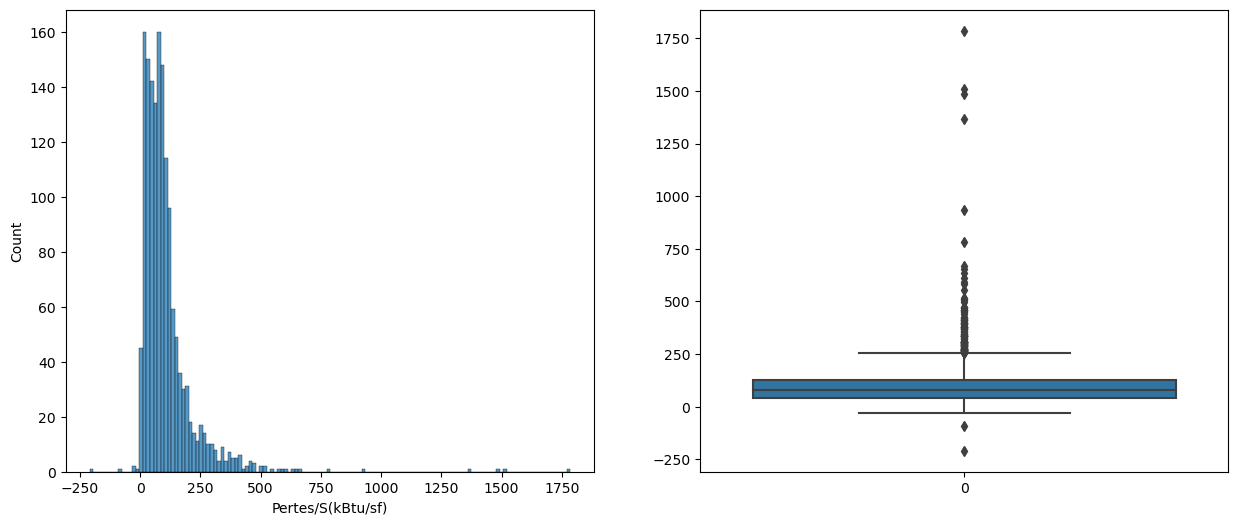

In [85]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.histplot(data['Pertes/S(kBtu/sf)'])
plt.subplot(1,2,2)
sns.boxplot(data['Pertes/S(kBtu/sf)'])

In [86]:
data[data['Pertes/S(kBtu/sf)']<200].shape[0]/data.shape[0]

0.8880890052356021

Environ 90% des bâtiments ont moins de 200 kBtu/sf de Pertes.

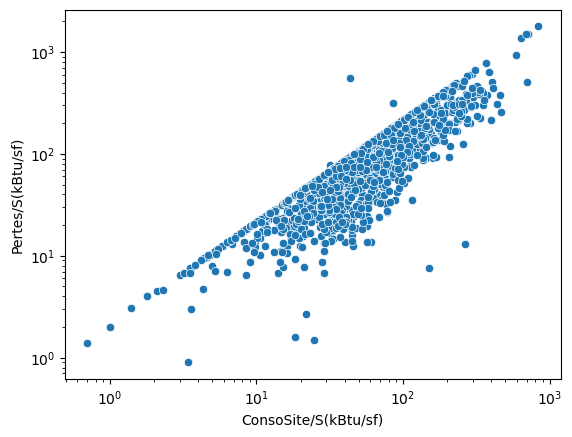

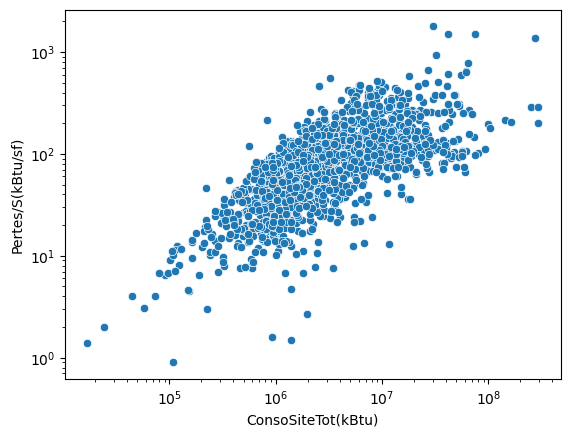

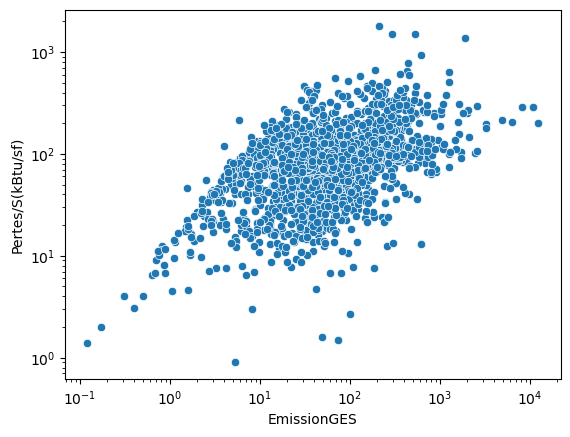

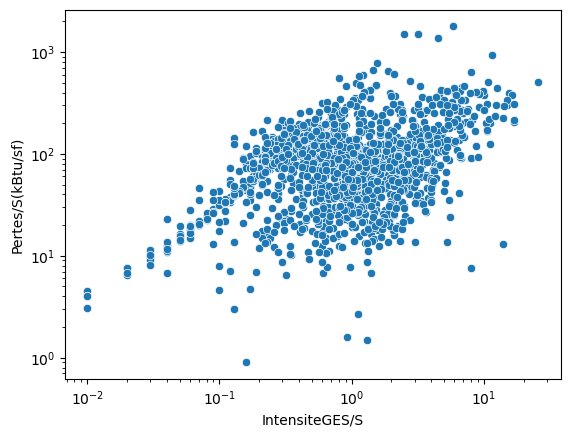

In [87]:
for var in var_cibles:
    sns.scatterplot(data=data, y='Pertes/S(kBtu/sf)', x=var)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [88]:
data.corr()['Pertes/S(kBtu/sf)'][var_cibles]

ConsoSite/S(kBtu/sf)    0.863970
ConsoSiteTot(kBtu)      0.394236
EmissionGES             0.193967
IntensiteGES/S          0.377094
Name: Pertes/S(kBtu/sf), dtype: float64

Les pertes sont très corrélées aux consommations absolues (ConsoSite/S) et assez corrélées aux intensité des GES.  
Cela indique que les batiments qui consomment beaucoup et qui rejettent beaucoup de GES ont aussi beaucoup de pertes (indépendamment de leur surface).

#### Analyse des pertes par rapport à plusieurs variables quantitatives
superficie, nombre batiment, nombre etage, nombre utilisation 

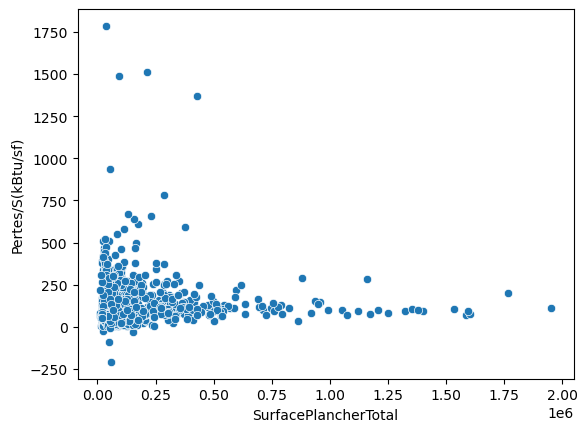

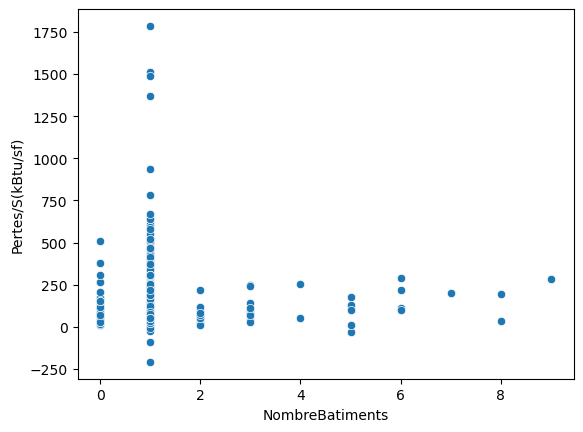

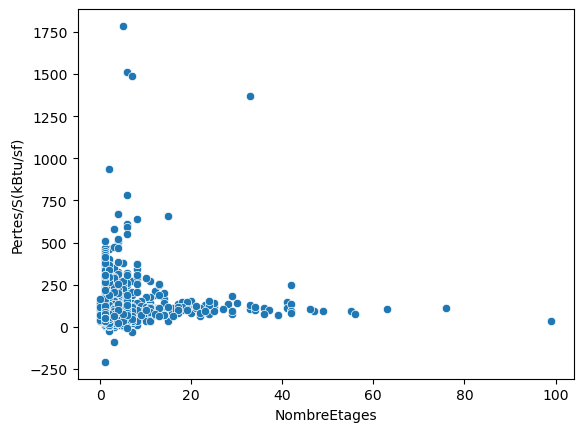

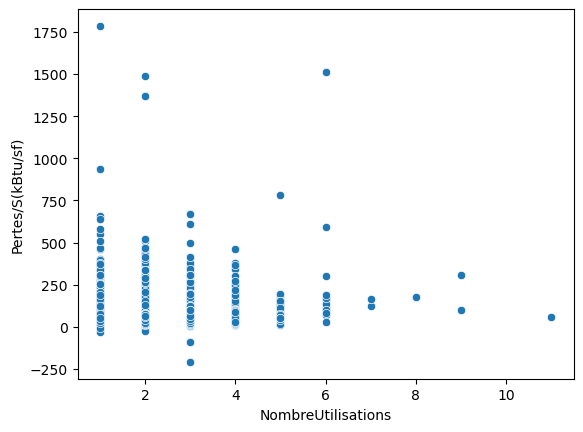

In [89]:
for var in ['SurfacePlancherTotal', 'NombreBatiments', 'NombreEtages', 'NombreUtilisations']:
    sns.scatterplot(data=data, y='Pertes/S(kBtu/sf)', x=var)
    plt.show()

Les pertes semblent assez indépendantes par rapport à ces variables.  
C'est plutôt pour des valeurs faibles de surface, de nombre de batiments, d'étages et de nombre d'utilisations qu'on va recontrer des valeurs élevé de pertes. On a ensuite une convergence vers la médiane.

#### Analyse des pertes par rapport à plusieurs variables qualitatives
au tranche d'age des batiments, conformité, type utilisation, quartier

In [90]:
data.head()

Quartier  AgeBatiment  NombreUtilisations PremierTypePropriete  \
0  DOWNTOWN           89                   1                Hotel   
1  DOWNTOWN           20                   3                Hotel   
2  DOWNTOWN           47                   1                Hotel   
3  DOWNTOWN           90                   1                Hotel   
4  DOWNTOWN           36                   3                Hotel   

   NombreBatiments  NombreEtages  SurfacePlancherTotal  SurfaceTotaleParking  \
0              1.0            12                 88434                     0   
1              1.0            11                103566                 15064   
2              1.0            41                956110                196718   
3              1.0            10                 61320                     0   
4              1.0            18                175580                 62000   

   SurfaceTotaleHorsParking      ListeUtilisationsBatiment  \
0                     88434                          Hotel   
1                     88502     Hotel, Parking, Restaurant   
2                    759392                          Hotel   
3                     61320                          Hotel   
4                    113580  Hotel, Parking, Swimming Pool   

  UtilisationPrincipale  SurfaceUtilisationPrincipale UtilisationSecondaire  \
0                 Hotel                       88434.0                Aucune   
1                 Hotel                       83880.0               Parking   
2                 Hotel                      756493.0                Aucune   
3                 Hotel                       61320.0                Aucune   
4                 Hotel                      123445.0               Parking   

   SurfaceUtilisationSecondaire UtilisationTertiaire  \
0                           0.0               Aucune   
1                       15064.0           Restaurant   
2                           0.0               Aucune   
3                           0.0               Aucune   
4                       68009.0        Swimming Pool   

   SurfaceUtilisationTertiaire Conformité  ConsoSite/S(kBtu/sf)  \
0                          0.0  Compliant             81.699997   
1                       4622.0  Compliant             94.800003   
2                          0.0  Compliant             96.000000   
3                          0.0  Compliant            110.800003   
4                          0.0  Compliant            114.800003   

   ConsoSiteNorm/S(kBtu/sf)  ConsoSource/S(kBtu/sf)  \
0                 84.300003              182.500000   
1                 97.900002              176.100006   
2                 97.699997              241.899994   
3                113.300003              216.199997   
4                118.699997              211.399994   

   ConsoSourceNorm/S(kBtu/sf)  ConsoSiteTot(kBtu)  ConsoSiteTotNorm(kBtu)  \
0                  189.000000           7226362.5               7456910.0   
1                  179.399994           8387933.0               8664479.0   
2                  244.100006          72587024.0              73937112.0   
3                  224.000000           6794584.0               6946800.5   
4                  215.600006          14172606.0              14656503.0   

   Vapeur(kBtu)  Électricité(kBtu)  GazNaturel(kBtu)  EmissionGES  \
0    2003882.00          3946027.0         1276453.0       249.98   
1          0.00          3242851.0         5145082.0       295.86   
2   21566554.00         49526664.0         1493800.0      2089.28   
3    2214446.25          2768924.0         1811213.0       286.43   
4          0.00          5368607.0         8803998.0       505.01   

   IntensiteGES/S TrancheAge  Pertes/S(kBtu/sf)  
0            2.83   [87,116[         100.800003  
1            2.86     [0,29[          81.300003  
2            2.19    [29,58[         145.899994  
3            4.67   [87,116[         105.399994  
4            2.88    [29,58[          96.599991

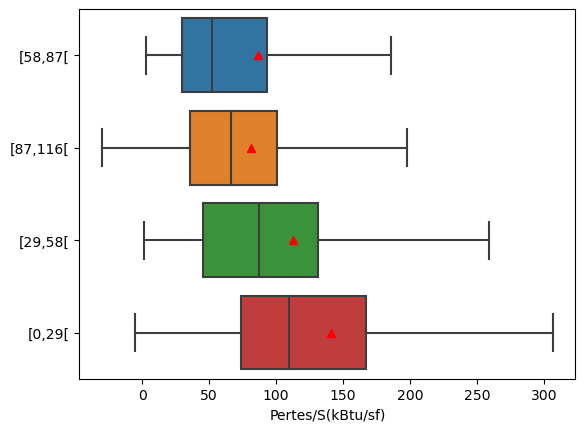

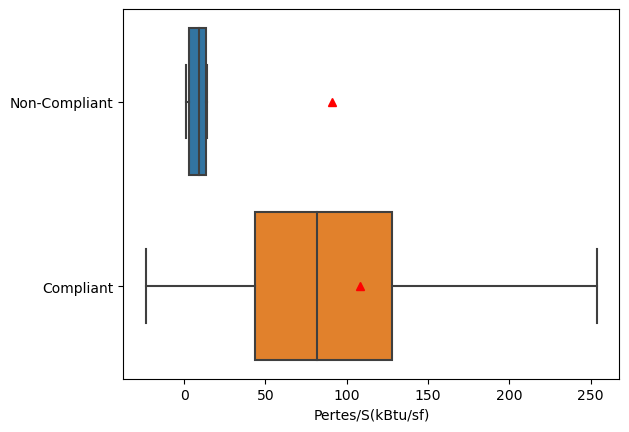

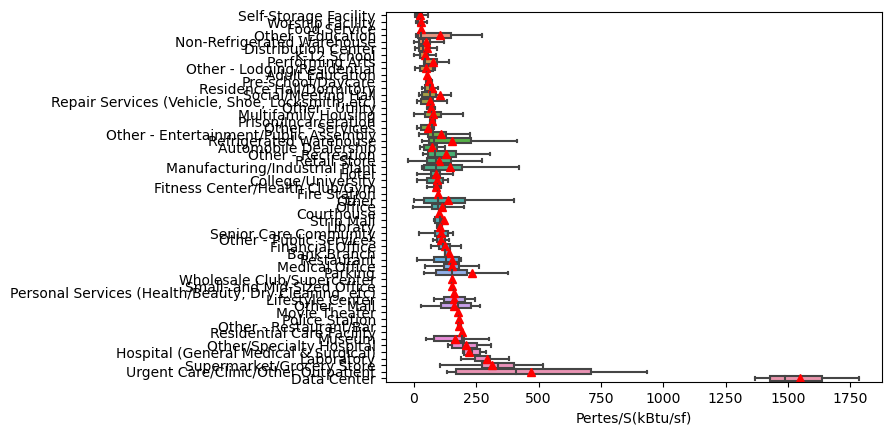

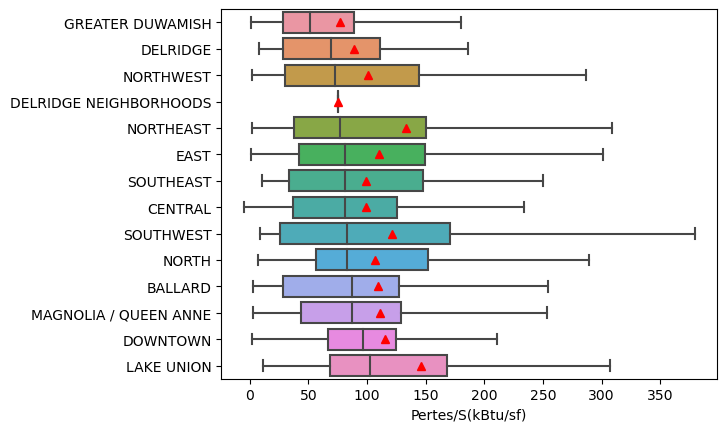

In [91]:
for var in ['TrancheAge', 'Conformité', 'UtilisationPrincipale', 'Quartier']:
    boxplot(data=data, var_quali=var, var_quanti='Pertes/S(kBtu/sf)')
    plt.show()

Pertes plus présentes pour les batiments récents.  
Les batiments enregistrant le plus de pertes sont ceux acceuillant des datacenters, des hopitaux, des cliniques et des supermarchés.  
Les quartiers où il y a les bâtiments avec le plus de pertes sont les quartiers de Lake Union, Downtown et Magnolia.

## Outliers

### Electricié

In [92]:
data = data.drop(data[data['Électricité(kBtu)']<0].index)

In [93]:
np.log(data['Électricité(kBtu)']).sort_values()[:3]

513         -inf
426         -inf
1670    1.098612
Name: Électricité(kBtu), dtype: float64

In [94]:
# outliers électricité
data.loc[np.log(data['Électricité(kBtu)']).sort_values()[:3].index]

Quartier  AgeBatiment  NombreUtilisations  \
513   MAGNOLIA / QUEEN ANNE            8                   3   
426                DOWNTOWN          116                   1   
1670              NORTHWEST           46                   1   

             PremierTypePropriete  NombreBatiments  NombreEtages  \
513   Supermarket / Grocery Store              1.0             1   
426                    Restaurant              1.0             1   
1670                        Other              5.0             1   

      SurfacePlancherTotal  SurfaceTotaleParking  SurfaceTotaleHorsParking  \
513                  57176                     0                     57176   
426                  43728                     0                     43728   
1670                 23166                     0                     23166   

                              ListeUtilisationsBatiment  \
513   Personal Services (Health/Beauty, Dry Cleaning...   
426                                          Restaurant   
1670                                              Other   

          UtilisationPrincipale  SurfaceUtilisationPrincipale  \
513   Supermarket/Grocery Store                       39500.0   
426                  Restaurant                       43728.0   
1670                      Other                       23166.0   

     UtilisationSecondaire  SurfaceUtilisationSecondaire  \
513           Retail Store                       15000.0   
426                 Aucune                           0.0   
1670                Aucune                           0.0   

                                   UtilisationTertiaire  \
513   Personal Services (Health/Beauty, Dry Cleaning...   
426                                              Aucune   
1670                                             Aucune   

      SurfaceUtilisationTertiaire Conformité  ConsoSite/S(kBtu/sf)  \
513                        5500.0  Compliant            208.800003   
426                           0.0  Compliant            263.200012   
1670                          0.0  Compliant            150.000000   

      ConsoSiteNorm/S(kBtu/sf)  ConsoSource/S(kBtu/sf)  \
513                 214.100006                0.000000   
426                 271.100006              276.299988   
1670                157.500000              157.500000   

      ConsoSourceNorm/S(kBtu/sf)  ConsoSiteTot(kBtu)  ConsoSiteTotNorm(kBtu)  \
513                     0.000000         12525174.00              12843856.0   
426                   284.600006         11508035.00              11854450.0   
1670                  165.399994          3475804.25               3648465.5   

      Vapeur(kBtu)  Électricité(kBtu)  GazNaturel(kBtu)  EmissionGES  \
513            0.0                0.0               0.0         0.00   
426            0.0                0.0        11508035.0       611.19   
1670           0.0                3.0         3475801.0       184.60   

      IntensiteGES/S TrancheAge  Pertes/S(kBtu/sf)  
513             0.00     [0,29[        -208.800003  
426            13.98   [87,116[          13.099976  
1670            7.97    [29,58[           7.500000

In [95]:
data = data.drop(np.log(data['Électricité(kBtu)']).sort_values()[:3].index)

### Normalisation de certaines variables

On normalise les variables qui ont une distribution log normale en les transformant au logarithme.  
Voici les variables qu'on va transformer dans la prochaine partie.

In [96]:
var_normal = ['ConsoSite/S(kBtu/sf)',
       'ConsoSiteNorm/S(kBtu/sf)', 'ConsoSource/S(kBtu/sf)',
       'ConsoSourceNorm/S(kBtu/sf)', 'ConsoSiteTot(kBtu)',
       'ConsoSiteTotNorm(kBtu)', 'Vapeur(kBtu)', 'Électricité(kBtu)',
       'GazNaturel(kBtu)', 'EmissionGES', 'IntensiteGES/S']

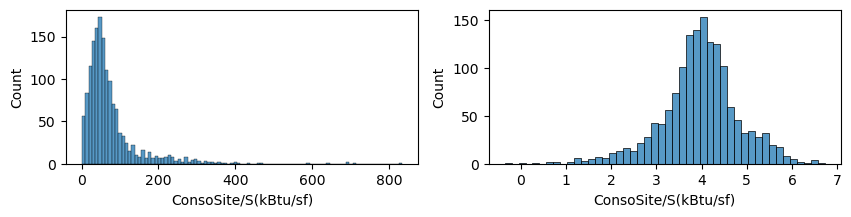

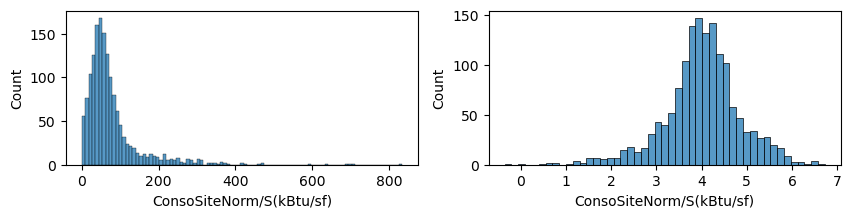

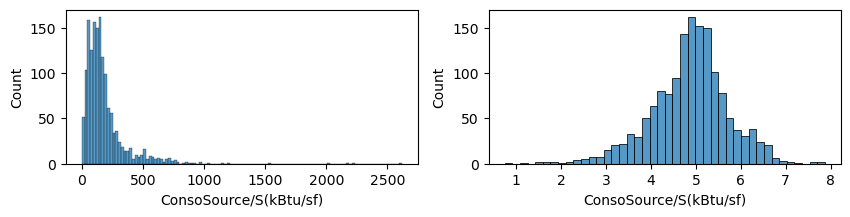

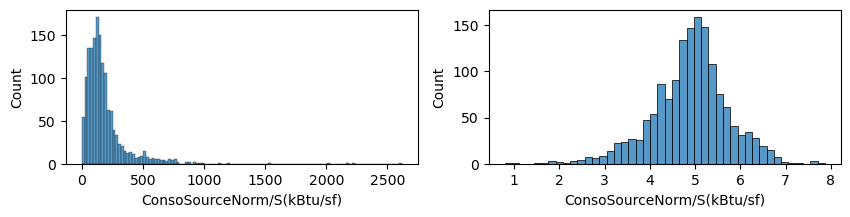

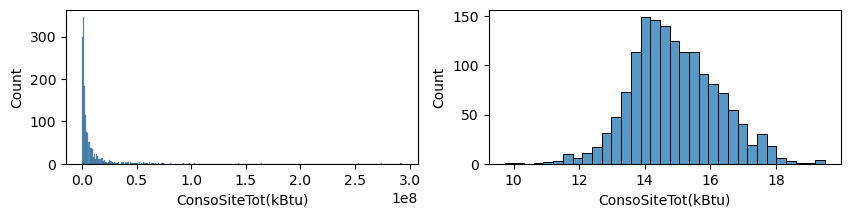

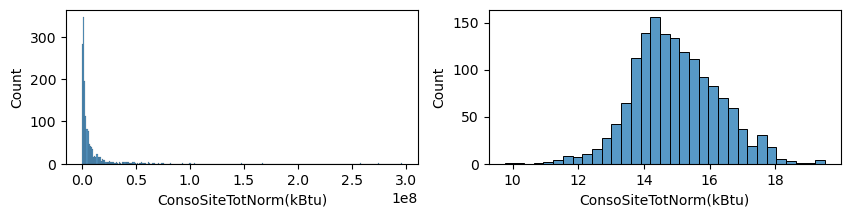

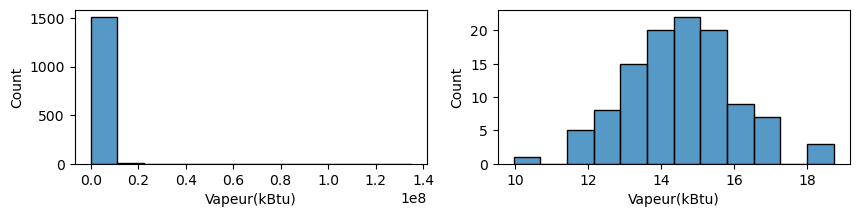

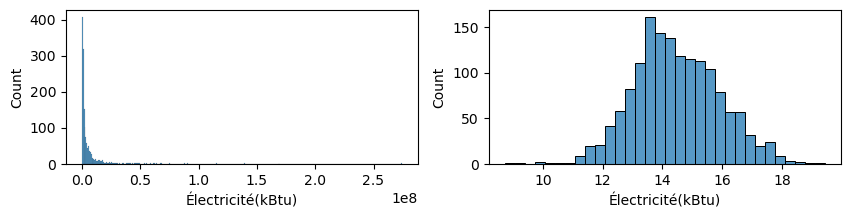

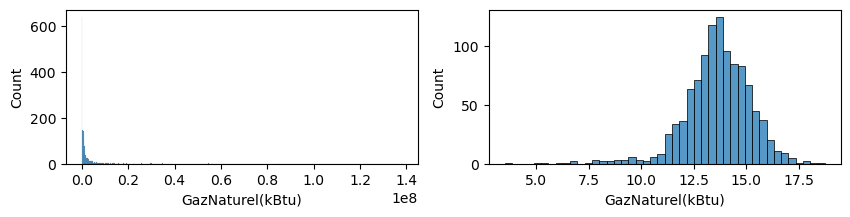

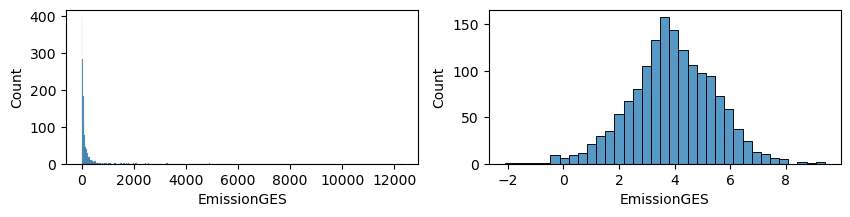

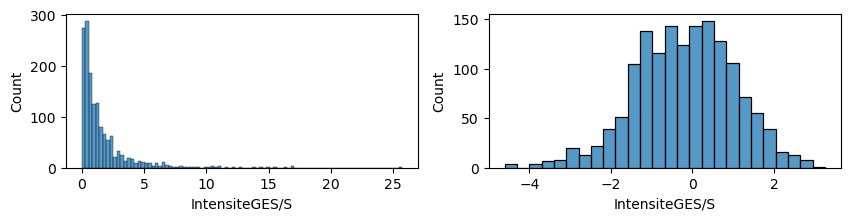

In [97]:
for var in var_normal:
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    sns.histplot(data[var])
    plt.subplot(1,2,2)
    sns.histplot(np.log(data[var]))    
    plt.show()

In [98]:
data.describe()

AgeBatiment  NombreUtilisations  NombreBatiments  NombreEtages  \
count  1524.000000         1524.000000      1524.000000   1524.000000   
mean     54.777559            1.912073         1.034121      4.310367   
std      32.898036            1.148300         0.563863      6.823745   
min       1.000000            1.000000         0.000000      0.000000   
25%      28.000000            1.000000         1.000000      1.000000   
50%      51.000000            2.000000         1.000000      2.000000   
75%      87.000000            2.000000         1.000000      4.000000   
max     116.000000           11.000000         9.000000     99.000000   

       SurfacePlancherTotal  SurfaceTotaleParking  SurfaceTotaleHorsParking  \
count          1.524000e+03           1524.000000              1.524000e+03   
mean           1.118856e+05          13953.870735              9.793170e+04   
std            1.898336e+05          43925.269146              1.659455e+05   
min            1.128500e+04              0.000000              3.636000e+03   
25%            2.880000e+04              0.000000              2.775600e+04   
50%            4.755700e+04              0.000000              4.555800e+04   
75%            1.031415e+05              0.000000              9.356875e+04   
max            1.952220e+06         512608.000000              1.765970e+06   

       SurfaceUtilisationPrincipale  SurfaceUtilisationSecondaire  \
count                  1.524000e+03                   1524.000000   
mean                   9.040492e+04                  19219.378148   
std                    1.548629e+05                  49517.629852   
min                    5.656000e+03                      0.000000   
25%                    2.486475e+04                      0.000000   
50%                    4.143850e+04                      0.000000   
75%                    8.914825e+04                  13623.250000   
max                    1.680937e+06                 441551.000000   

       SurfaceUtilisationTertiaire  ConsoSite/S(kBtu/sf)  \
count                  1524.000000           1524.000000   
mean                   3009.245668             74.384449   
std                   14404.549176             75.649960   
min                       0.000000              0.700000   
25%                       0.000000             34.375001   
50%                       0.000000             53.350000   
75%                       0.000000             83.875002   
max                  303910.000000            834.400024   

       ConsoSiteNorm/S(kBtu/sf)  ConsoSource/S(kBtu/sf)  \
count               1524.000000             1524.000000   
mean                  76.793635              182.774803   
std                   76.604370              190.932395   
min                    0.000000                0.000000   
25%                   36.450000               79.375002   
50%                   55.950001              138.050003   
75%                   87.525000              211.399994   
max                  834.400024             2620.000000   

       ConsoSourceNorm/S(kBtu/sf)  ConsoSiteTot(kBtu)  ConsoSiteTotNorm(kBtu)  \
count                 1524.000000        1.524000e+03            1.524000e+03   
mean                   185.068045        7.708015e+06            7.814482e+06   
std                    190.857327        1.876698e+07            1.892397e+07   
min                      0.000000        1.680890e+04            0.000000e+00   
25%                     81.624998        1.213240e+06            1.280348e+06   
50%                    140.750000        2.641331e+06            2.758547e+06   
75%                    213.049995        7.007642e+06            7.250945e+06   
max                   2620.000000        2.930908e+08            2.966717e+08   

       Vapeur(kBtu)  Électricité(kBtu)  GazNaturel(kBtu)   EmissionGES  \
count  1.524000e+03       1.524000e+03      1.524000e+03   1524.000000   
mean   5.011779e+05       5.483727e+06      1.679579e+06    166.

### Création des variables de proportion

In [99]:
data['ProportionVapeur'] = data['Vapeur(kBtu)']/data['ConsoSiteTot(kBtu)']
data['ProportionElectricité'] = data['Électricité(kBtu)']/data['ConsoSiteTot(kBtu)']
data['ProportionGazNaturel'] = data['GazNaturel(kBtu)']/data['ConsoSiteTot(kBtu)']

### Export Tableau

In [100]:
# creation coordonnées gps
data[df_gps.columns] = df_gps
data.head()

Quartier  AgeBatiment  NombreUtilisations PremierTypePropriete  \
0  DOWNTOWN           89                   1                Hotel   
1  DOWNTOWN           20                   3                Hotel   
2  DOWNTOWN           47                   1                Hotel   
3  DOWNTOWN           90                   1                Hotel   
4  DOWNTOWN           36                   3                Hotel   

   NombreBatiments  NombreEtages  SurfacePlancherTotal  SurfaceTotaleParking  \
0              1.0            12                 88434                     0   
1              1.0            11                103566                 15064   
2              1.0            41                956110                196718   
3              1.0            10                 61320                     0   
4              1.0            18                175580                 62000   

   SurfaceTotaleHorsParking      ListeUtilisationsBatiment  \
0                     88434                          Hotel   
1                     88502     Hotel, Parking, Restaurant   
2                    759392                          Hotel   
3                     61320                          Hotel   
4                    113580  Hotel, Parking, Swimming Pool   

  UtilisationPrincipale  SurfaceUtilisationPrincipale UtilisationSecondaire  \
0                 Hotel                       88434.0                Aucune   
1                 Hotel                       83880.0               Parking   
2                 Hotel                      756493.0                Aucune   
3                 Hotel                       61320.0                Aucune   
4                 Hotel                      123445.0               Parking   

   SurfaceUtilisationSecondaire UtilisationTertiaire  \
0                           0.0               Aucune   
1                       15064.0           Restaurant   
2                           0.0               Aucune   
3                           0.0               Aucune   
4                       68009.0        Swimming Pool   

   SurfaceUtilisationTertiaire Conformité  ConsoSite/S(kBtu/sf)  \
0                          0.0  Compliant             81.699997   
1                       4622.0  Compliant             94.800003   
2                          0.0  Compliant             96.000000   
3                          0.0  Compliant            110.800003   
4                          0.0  Compliant            114.800003   

   ConsoSiteNorm/S(kBtu/sf)  ConsoSource/S(kBtu/sf)  \
0                 84.300003              182.500000   
1                 97.900002              176.100006   
2                 97.699997              241.899994   
3                113.300003              216.199997   
4                118.699997              211.399994   

   ConsoSourceNorm/S(kBtu/sf)  ConsoSiteTot(kBtu)  ConsoSiteTotNorm(kBtu)  \
0                  189.000000           7226362.5               7456910.0   
1                  179.399994           8387933.0               8664479.0   
2                  244.100006          72587024.0              73937112.0   
3                  224.000000           6794584.0               6946800.5   
4                  215.600006          14172606.0              14656503.0   

   Vapeur(kBtu)  Électricité(kBtu)  GazNaturel(kBtu)  EmissionGES  \
0    2003882.00          3946027.0         1276453.0       249.98   
1          0.00          3242851.0         5145082.0       295.86   
2   21566554.00         49526664.0         1493800.0      2089.28   
3    2214446.25          2768924.0         1811213.0       286.43   
4          0.00          5368607.0         8803998.0       505.01   

   IntensiteGES/S TrancheAge  Pertes/S(kBtu/sf)  ProportionVapeur  \
0            2.83   [87,116[         100.800003          0.277302   
1            2.86     [0,29[          81.300003          0.000000   
2            2.19    [29,58[         145.899994          0.297113   
3            4.67   [87,116[      

In [101]:
# export tableau
data.to_csv(folder+'data_tab.csv')

In [102]:
data = data.drop(columns=df_gps.columns)

In [103]:
data.to_csv(folder+'data_2.csv')

In [104]:
data.isna().sum()

Quartier                        0
AgeBatiment                     0
NombreUtilisations              0
PremierTypePropriete            0
NombreBatiments                 0
NombreEtages                    0
SurfacePlancherTotal            0
SurfaceTotaleParking            0
SurfaceTotaleHorsParking        0
ListeUtilisationsBatiment       0
UtilisationPrincipale           0
SurfaceUtilisationPrincipale    0
UtilisationSecondaire           0
SurfaceUtilisationSecondaire    0
UtilisationTertiaire            0
SurfaceUtilisationTertiaire     0
Conformité                      0
ConsoSite/S(kBtu/sf)            0
ConsoSiteNorm/S(kBtu/sf)        0
ConsoSource/S(kBtu/sf)          0
ConsoSourceNorm/S(kBtu/sf)      0
ConsoSiteTot(kBtu)              0
ConsoSiteTotNorm(kBtu)          0
Vapeur(kBtu)                    0
Électricité(kBtu)               0
GazNaturel(kBtu)                0
EmissionGES                     0
IntensiteGES/S                  0
TrancheAge                      0
Pertes/S(kBtu/

# Création du modèle 1

In [105]:
data2 = data.copy()

In [106]:
var_cibles

['ConsoSite/S(kBtu/sf)', 'ConsoSiteTot(kBtu)', 'EmissionGES', 'IntensiteGES/S']

In [107]:
data2.columns

Index(['Quartier', 'AgeBatiment', 'NombreUtilisations', 'PremierTypePropriete',
       'NombreBatiments', 'NombreEtages', 'SurfacePlancherTotal',
       'SurfaceTotaleParking', 'SurfaceTotaleHorsParking',
       'ListeUtilisationsBatiment', 'UtilisationPrincipale',
       'SurfaceUtilisationPrincipale', 'UtilisationSecondaire',
       'SurfaceUtilisationSecondaire', 'UtilisationTertiaire',
       'SurfaceUtilisationTertiaire', 'Conformité', 'ConsoSite/S(kBtu/sf)',
       'ConsoSiteNorm/S(kBtu/sf)', 'ConsoSource/S(kBtu/sf)',
       'ConsoSourceNorm/S(kBtu/sf)', 'ConsoSiteTot(kBtu)',
       'ConsoSiteTotNorm(kBtu)', 'Vapeur(kBtu)', 'Électricité(kBtu)',
       'GazNaturel(kBtu)', 'EmissionGES', 'IntensiteGES/S', 'TrancheAge',
       'Pertes/S(kBtu/sf)', 'ProportionVapeur', 'ProportionElectricité',
       'ProportionGazNaturel'],
      dtype='object')

In [108]:
# on fait d'abord le modèle des consos, on enlève les GES et les colonnes conso, on est pas sensé les avoir
data2 = data2.drop(columns=['EmissionGES', 'IntensiteGES/S', 'ConsoSite/S(kBtu/sf)',
                            'ConsoSiteNorm/S(kBtu/sf)', 'ConsoSiteTotNorm(kBtu)', 'Pertes/S(kBtu/sf)',
                           'ConsoSource/S(kBtu/sf)', 'ConsoSourceNorm/S(kBtu/sf)'])

data2 = data2.drop(columns=[ 'SurfaceTotaleParking', 'SurfaceTotaleHorsParking','SurfacePlancherTotal', 
                           'Vapeur(kBtu)', 'Électricité(kBtu)',
                           'GazNaturel(kBtu)', 'ProportionVapeur', 'ProportionElectricité',
       'ProportionGazNaturel'])


# suppression variables inutiles
data2 = data2.drop(columns=['AgeBatiment', 'PremierTypePropriete', 'ListeUtilisationsBatiment'])

'''data2 = data2.drop(columns=[ 'SurfaceTotaleParking', 'SurfaceTotaleHorsParking',
       'UtilisationPrincipale',
       'SurfaceUtilisationPrincipale', 'UtilisationSecondaire',
       'SurfaceUtilisationSecondaire', 'UtilisationTertiaire',
       'SurfaceUtilisationTertiaire'])'''

"data2 = data2.drop(columns=[ 'SurfaceTotaleParking', 'SurfaceTotaleHorsParking',\n       'UtilisationPrincipale',\n       'SurfaceUtilisationPrincipale', 'UtilisationSecondaire',\n       'SurfaceUtilisationSecondaire', 'UtilisationTertiaire',\n       'SurfaceUtilisationTertiaire'])"

In [109]:
target='ConsoSiteTot(kBtu)'

In [110]:
data2.head()

Quartier  NombreUtilisations  NombreBatiments  NombreEtages  \
0  DOWNTOWN                   1              1.0            12   
1  DOWNTOWN                   3              1.0            11   
2  DOWNTOWN                   1              1.0            41   
3  DOWNTOWN                   1              1.0            10   
4  DOWNTOWN                   3              1.0            18   

  UtilisationPrincipale  SurfaceUtilisationPrincipale UtilisationSecondaire  \
0                 Hotel                       88434.0                Aucune   
1                 Hotel                       83880.0               Parking   
2                 Hotel                      756493.0                Aucune   
3                 Hotel                       61320.0                Aucune   
4                 Hotel                      123445.0               Parking   

   SurfaceUtilisationSecondaire UtilisationTertiaire  \
0                           0.0               Aucune   
1                       15064.0           Restaurant   
2                           0.0               Aucune   
3                           0.0               Aucune   
4                       68009.0        Swimming Pool   

   SurfaceUtilisationTertiaire Conformité  ConsoSiteTot(kBtu) TrancheAge  
0                          0.0  Compliant           7226362.5   [87,116[  
1                       4622.0  Compliant           8387933.0     [0,29[  
2                          0.0  Compliant          72587024.0    [29,58[  
3                          0.0  Compliant           6794584.0   [87,116[  
4                          0.0  Compliant          14172606.0    [29,58[

In [111]:
data2.columns

Index(['Quartier', 'NombreUtilisations', 'NombreBatiments', 'NombreEtages',
       'UtilisationPrincipale', 'SurfaceUtilisationPrincipale',
       'UtilisationSecondaire', 'SurfaceUtilisationSecondaire',
       'UtilisationTertiaire', 'SurfaceUtilisationTertiaire', 'Conformité',
       'ConsoSiteTot(kBtu)', 'TrancheAge'],
      dtype='object')

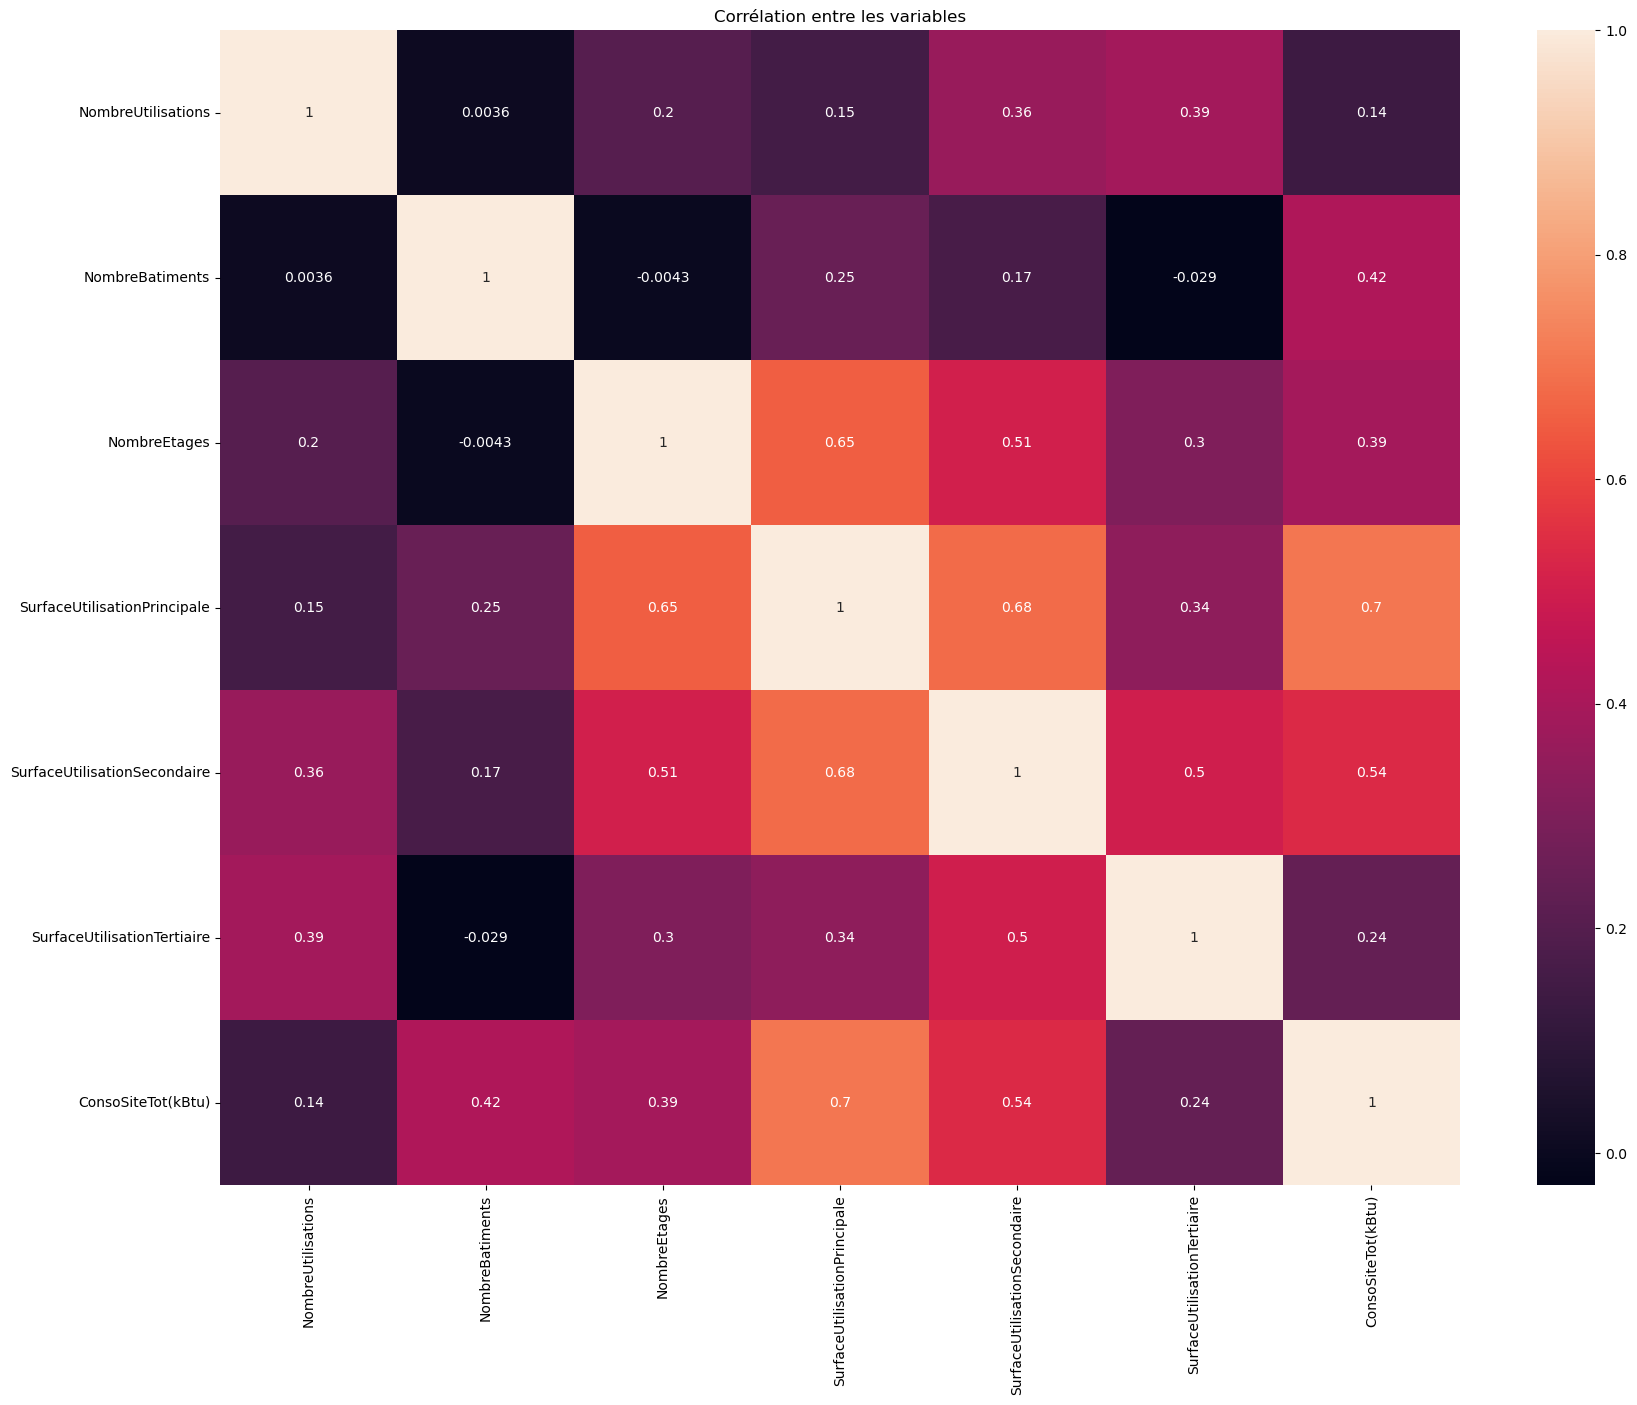

In [112]:
plt.figure(figsize=(20,15))

plt.title("Corrélation entre les variables")

sns.heatmap(data2.corr(), annot=True)

plt.show()

In [113]:
# colonnes categ
var_categ = list(data2.select_dtypes(include='object').columns)

# data categ 2
data_categ = data2.select_dtypes(include='object')
data_categ

Quartier UtilisationPrincipale  \
0                   DOWNTOWN                 Hotel   
1                   DOWNTOWN                 Hotel   
2                   DOWNTOWN                 Hotel   
3                   DOWNTOWN                 Hotel   
4                   DOWNTOWN                 Hotel   
...                      ...                   ...   
3370  DELRIDGE NEIGHBORHOODS    Other - Recreation   
3372                DOWNTOWN    Other - Recreation   
3373   MAGNOLIA / QUEEN ANNE    Other - Recreation   
3374        GREATER DUWAMISH    Other - Recreation   
3375        GREATER DUWAMISH    Other - Recreation   

               UtilisationSecondaire UtilisationTertiaire Conformité  \
0                             Aucune               Aucune  Compliant   
1                            Parking           Restaurant  Compliant   
2                             Aucune               Aucune  Compliant   
3                             Aucune               Aucune  Compliant   
4                            Parking        Swimming Pool  Compliant   
...                              ...                  ...        ...   
3370                          Aucune               Aucune  Compliant   
3372                          Aucune               Aucune  Compliant   
3373  Fitness Center/Health Club/Gym        Swimming Pool  Compliant   
3374  Fitness Center/Health Club/Gym   Pre-school/Daycare  Compliant   
3375  Fitness Center/Health Club/Gym   Pre-school/Daycare  Compliant   

     TrancheAge  
0      [87,116[  
1        [0,29[  
2       [29,58[  
3      [87,116[  
4       [29,58[  
...         ...  
3370    [29,58[  
3372     [0,29[  
3373    [29,58[  
3374     [0,29[  
3375    [58,87[  

[1524 rows x 6 columns]

In [114]:
# colonnes num
var_num = list(data2.drop(columns=target).select_dtypes(exclude='object').columns)

# data num 2
data_num = data2.drop(columns=target).select_dtypes(exclude='object')
data_num

NombreUtilisations  NombreBatiments  NombreEtages  \
0                      1              1.0            12   
1                      3              1.0            11   
2                      1              1.0            41   
3                      1              1.0            10   
4                      3              1.0            18   
...                  ...              ...           ...   
3370                   1              1.0             1   
3372                   1              1.0             1   
3373                   3              1.0             1   
3374                   5              1.0             1   
3375                   5              1.0             1   

      SurfaceUtilisationPrincipale  SurfaceUtilisationSecondaire  \
0                          88434.0                           0.0   
1                          83880.0                       15064.0   
2                         756493.0                           0.0   
3                          61320.0                           0.0   
4                         123445.0                       68009.0   
...                            ...                           ...   
3370                       18261.0                           0.0   
3372                       16000.0                           0.0   
3373                        7583.0                        5574.0   
3374                        6601.0                        6501.0   
3375                        8271.0                        8000.0   

      SurfaceUtilisationTertiaire  
0                             0.0  
1                          4622.0  
2                             0.0  
3                             0.0  
4                             0.0  
...                           ...  
3370                          0.0  
3372                          0.0  
3373                          0.0  
3374                        484.0  
3375                       1108.0  

[1524 rows x 6 columns]

In [115]:
# création du train et test set
data_train, data_test = train_test_split(data2, test_size=0.2)

In [116]:
print(f"Les dimensions du train_set sont {data_train.shape}")
print(f"Les dimensions du test_set sont {data_test.shape}")

Les dimensions du train_set sont (1219, 13)
Les dimensions du test_set sont (305, 13)


In [117]:
def creation_train_test_set(data, target):
    
    # colonnes categ
    var_categ = list(data.select_dtypes(include='object').columns)

    # data categ 2
    data_categ = data.select_dtypes(include='object')
    
    # colonnes num
    var_num = list(data.drop(columns=target).select_dtypes(exclude='object').columns)

    # data num 2
    data_num = data.drop(columns=target).select_dtypes(exclude='object')
    
    # création du train et test set
    data_train, data_test = train_test_split(data, test_size=0.2)
    
    return data_train, data_test, var_categ, data_categ, var_num, data_num

In [118]:
data_train, data_test, var_categ, data_categ, var_num, data_num = creation_train_test_set(data2, target)

## Preprocessing

In [119]:
def preprocessing(data, target, var_categ, var_num):    

    # Encodage
    encoder = OrdinalEncoder()

    data_encoder = encoder.fit_transform(data[var_categ])
    
    # Transformation
    #var_normal2 = ['Vapeur(kBtu)', 'Électricité(kBtu)', 'GazNaturel(kBtu)']
    #data[var_normal2] = np.log(data[var_normal2]).replace(-np.inf, 0)
    
    # Standardisation
    scaler = StandardScaler()

    data_scaler = scaler.fit_transform(data[var_num])

    # concaténation des 2 preprocessing
    #df_scaled = pd.DataFrame(np.concatenate((data_encoder, data_scaler), axis=1), columns=var_categ+var_num)
    df_scaled = pd.DataFrame(np.concatenate((data_encoder, data[var_num]), axis=1), columns=var_categ+var_num)

    y = data[target].values
    X = df_scaled.values
    columns = list(df_scaled.columns)
    
    return X, y, columns

Notes :  
est ce que OrdinalEncoder est correcte, comment utilise t on OneHotEncoder exactement ?  

la standardisation est uniquement faite sur les variables quantitatives, est ce correcte ?  



## Modélisation

In [120]:
def modelisation(data_train, data_test, target):
    
    # creation X_train et y_train
    X_train, y_train, columns = preprocessing(data_train, target, var_categ, var_num)
    # creation X_test et y_test
    X_test, y_test, columns = preprocessing(data_test, target, var_categ, var_num)
    
    # creation de l'estimateur
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    return reg.score(X_test, y_test), reg, X_train, X_test, y_train, y_test, columns

In [121]:
score, reg, X_train, X_test, y_train, y_test, columns = modelisation(data_train, data_test, target)
score

0.5417186262990811

## Evaluation

### Importance de chaque variable sur le modèle

In [125]:
#scaler2 = StandardScaler()

#coef = scaler2.fit_transform(reg.coef_.reshape((reg.coef_.shape[0],1)))

In [126]:
pd.DataFrame(reg.coef_, index=columns, columns=['coefficients'])

coefficients
Quartier                      3.875085e+04
UtilisationPrincipale        -6.822049e+04
UtilisationSecondaire        -4.840269e+04
UtilisationTertiaire         -3.313715e+04
Conformité                   -1.066075e+06
TrancheAge                   -3.252097e+04
NombreUtilisations            7.953163e+05
NombreBatiments               9.063704e+06
NombreEtages                 -1.521246e+05
SurfaceUtilisationPrincipale  7.340926e+01
SurfaceUtilisationSecondaire  4.297742e+01
SurfaceUtilisationTertiaire  -1.631607e+01

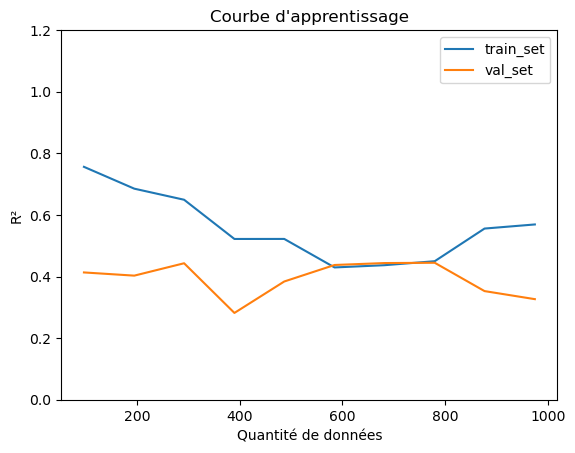

In [127]:
# courbe d'apprentissage
N, train_score, val_score = learning_curve(reg, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)

plt.title("Courbe d'apprentissage")
plt.plot(N, train_score.mean(axis=1), label='train_set')
plt.plot(N, val_score.mean(axis=1), label='val_set')
plt.xlabel("Quantité de données")
plt.ylabel("R²")
plt.ylim((0,1.2))
plt.legend()
plt.show()

#### Vérification de la stabilité du modèle

0.5251823082267495
0.513209853010115


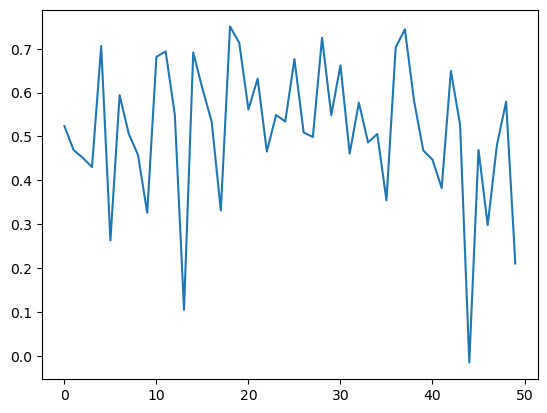

In [128]:
score_iteration = []

for i in range(50):
    data_train, data_test, var_categ, data_categ, var_num, data_num = creation_train_test_set(data2, target)
    score, reg, X_train, X_test, y_train, y_test, columns = modelisation(data_train, data_test, target)
    score_iteration.append(score)
    
plt.plot(range(len(score_iteration)), score_iteration)

print(np.median(np.array(score_iteration)))
print(np.array(score_iteration).mean())

#### Fonction évaluation

In [129]:
def evaluation(reg, X_train, y_train, columns):
    
    scaler2 = StandardScaler()

    coef = scaler2.fit_transform(reg.coef_.reshape((reg.coef_.shape[0],1)))
    
    print(pd.DataFrame(coef, index=columns, columns=['coefficients']))
    
    
    # courbe d'apprentissage
    N, train_score, val_score = learning_curve(reg, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)

    plt.title("Courbe d'apprentissage")
    plt.plot(N, train_score.mean(axis=1), label='train_set')
    plt.plot(N, val_score.mean(axis=1), label='val_set')
    plt.xlabel("Quantité de données")
    plt.ylabel("R²")
    plt.ylim((0,1.2))
    plt.legend()
    plt.show()
    
    # Prédiction
    y_pred = reg.predict(X_test)
    
    # Erreur Quadratique moyenne, Erreur absolue moyenne, Erreur absolue médiane 
    print("L'Erreur Quadratique Moyenne est :",mean_squared_error(y_test, y_pred))
    print("L'Erreur Absolue Moyenne est :",mean_absolute_error(y_test, y_pred))
    print("L'Erreur Absolue Médiane est :",median_absolute_error(y_test, y_pred))

                              coefficients
Quartier                         -0.388622
UtilisationPrincipale            -0.408732
UtilisationSecondaire            -0.409595
UtilisationTertiaire             -0.400305
Conformité                        0.630800
TrancheAge                       -0.411139
NombreUtilisations               -0.123987
NombreBatiments                   3.174362
NombreEtages                     -0.469068
SurfaceUtilisationPrincipale     -0.397897
SurfaceUtilisationSecondaire     -0.397915
SurfaceUtilisationTertiaire      -0.397904


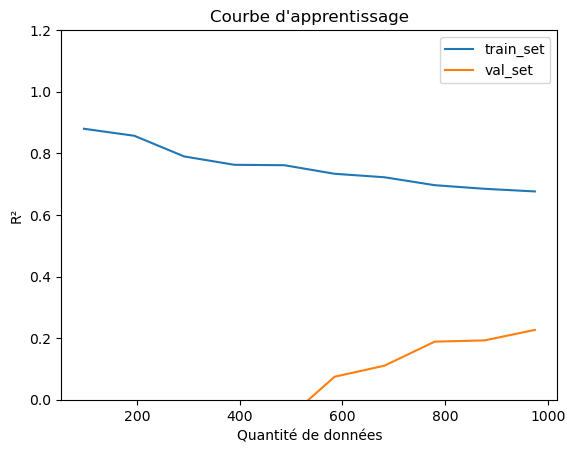

L'Erreur Quadratique Moyenne est : 349309392343377.3
L'Erreur Absolue Moyenne est : 5884991.333747997
L'Erreur Absolue Médiane est : 2102657.202021001


In [130]:
evaluation(reg, X_train, y_train, columns)

### Régression avec stats model

In [131]:
data_train, data_test, var_categ, data_categ, var_num, data_num = creation_train_test_set(data2, target)
score, reg, X_train, X_test, y_train, y_test, columns = modelisation(data_train, data_test, target)

# ajout de la colonne de biais
df_X_train = pd.DataFrame(X_train, columns=columns)
df_X_test = pd.DataFrame(X_test, columns=columns)
X_train_sm = sm.add_constant(df_X_train)
X_test_sm = sm.add_constant(df_X_test)

results = sm.OLS(y_train, X_train_sm).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     147.4
Date:                Thu, 10 Aug 2023   Prob (F-statistic):          1.85e-226
Time:                        08:09:25   Log-Likelihood:                -21677.
No. Observations:                1219   AIC:                         4.338e+04
Df Residuals:                    1206   BIC:                         4.345e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -1.007e+07   1.78e+06     -5.654      0.000   -1.36e+07   -6.57e+06
Quartier                      6.443e+04   1.32e+05      0.487      0.626   -1.95e+05    3.24e+05
UtilisationPrincipale        -5.099e+04   3.08e+04     -1.655      0.098   -1.11e+05    9445.722
UtilisationSecondaire        -2.842e+04   3.31e+04     -0.859      0.390   -9.33e+04    3.65e+04
UtilisationTertiaire         -5.064e+04   5.55e+04     -0.912      0.362    -1.6e+05    5.83e+04
Conformité                   -3.169e+06   3.49e+06     -0.909      0.363      -1e+07    3.67e+06
TrancheAge                   -3.274e+04   3.47e+05     -0.094      0.925   -7.14e+05    6.49e+05
NombreUtilisations            5.962e+05   5.55e+05      1.074      0.283   -4.93e+05    1.69e+06
NombreBatiments               1.121e+07   7.35e+05     15.258      0.000    9.77e+06    1.27e+07
NombreEtages                 -1.722e+05    7.3e+04     -2.360      0.018   -3.15e+05    -2.9e+04
SurfaceUtilisationPrincipale    79.5411      3.985     19.959      0.000      71.722      87.360
SurfaceUtilisationSecondaire    29.8876     11.969      2.497      0.013       6.406      53.369
SurfaceUtilisationTertiaire     -7.4489     29.392     -0.253      0.800     -65.114      50.216
==============================================================================
Omnibus:                     1779.909   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1064659.367
Skew:                           8.086   Prob(JB):                         0.00
Kurtosis:                     146.874   Cond. No.                     1.71e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Calcul des VIF

Les VIF servent à définir les variables trop corrélées avec les autres variables et les écarter.  
avec VIF = 1/(1-R²) où on calcul la régression linéaire de chaque variable par rapport aux (chaque variable devient la variable cible).  
Couramment, on gardera les VIF > 5.

In [132]:
vif = [variance_inflation_factor(X_train_sm, i) for i in range(X_train_sm.shape[1])]
df_vif = pd.DataFrame(vif, index=X_train_sm.columns, columns=['VIF'])
df_vif

VIF
const                         23.402424
Quartier                       1.119792
UtilisationPrincipale          1.056913
UtilisationSecondaire          1.744982
UtilisationTertiaire           2.068376
Conformité                     1.017825
TrancheAge                     1.127597
NombreUtilisations             3.004523
NombreBatiments                1.189990
NombreEtages                   1.815543
SurfaceUtilisationPrincipale   2.704535
SurfaceUtilisationSecondaire   2.591194
SurfaceUtilisationTertiaire    1.521792

#### Score sur jeu de test

In [133]:
X_test_sm = sm.add_constant(X_test)

y_pred = results.predict(X_test_sm)

r_squared = r2_score(y_test, y_pred)

r_squared

0.1177079286062348

#### Importances des variables

In [134]:
results.tvalues

const                           -5.654138
Quartier                         0.487388
UtilisationPrincipale           -1.655299
UtilisationSecondaire           -0.859143
UtilisationTertiaire            -0.912092
Conformité                      -0.909381
TrancheAge                      -0.094271
NombreUtilisations               1.073689
NombreBatiments                 15.258311
NombreEtages                    -2.359568
SurfaceUtilisationPrincipale    19.959390
SurfaceUtilisationSecondaire     2.497149
SurfaceUtilisationTertiaire     -0.253433
dtype: float64

#### Stabilité du modèle

0.44496383439244547
0.42775591599610474


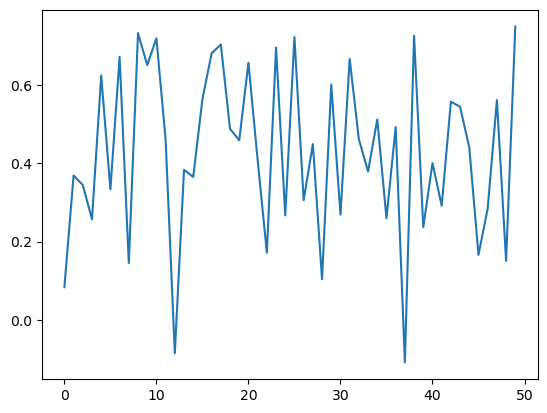

In [135]:
score_iteration = []

for i in range(50):
    
    data_train, data_test, var_categ, data_categ, var_num, data_num = creation_train_test_set(data2, target)
    score, reg, X_train, X_test, y_train, y_test, columns = modelisation(data_train, data_test, target)

    # ajout de la colonne de biais
    df_X_train = pd.DataFrame(X_train, columns=columns)
    df_X_test = pd.DataFrame(X_test, columns=columns)
    X_train_sm = sm.add_constant(df_X_train)
    X_test_sm = sm.add_constant(df_X_test)

    results = sm.OLS(y_train, X_train_sm).fit()

    X_test_sm = sm.add_constant(X_test)

    y_pred = results.predict(X_test_sm)

    r_squared = r2_score(y_test, y_pred)
    
    score_iteration.append(r_squared)
    
plt.plot(range(len(score_iteration)), score_iteration)

print(np.median(np.array(score_iteration)))
print(np.array(score_iteration).mean())

#### Analyse des résidus

248628517.80317


ShapiroResult(statistic=0.4727126359939575, pvalue=0.0)

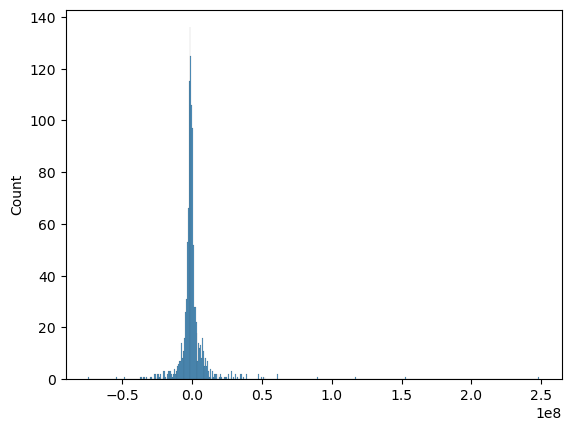

In [136]:
print(results.resid.max())

sns.histplot(results.resid)

shapiro(results.resid)

Il semblerait que les résidus ne suivent pas une loi normale.

In [137]:
st.skewtest(results.resid)

SkewtestResult(statistic=35.55353222813487, pvalue=7.327419447214497e-277)

In [138]:
st.kurtosistest(results.resid)

KurtosistestResult(statistic=23.164465140461935, pvalue=1.0393053542684066e-118)

# Création du modèle 2

In [139]:
data.columns

Index(['Quartier', 'AgeBatiment', 'NombreUtilisations', 'PremierTypePropriete',
       'NombreBatiments', 'NombreEtages', 'SurfacePlancherTotal',
       'SurfaceTotaleParking', 'SurfaceTotaleHorsParking',
       'ListeUtilisationsBatiment', 'UtilisationPrincipale',
       'SurfaceUtilisationPrincipale', 'UtilisationSecondaire',
       'SurfaceUtilisationSecondaire', 'UtilisationTertiaire',
       'SurfaceUtilisationTertiaire', 'Conformité', 'ConsoSite/S(kBtu/sf)',
       'ConsoSiteNorm/S(kBtu/sf)', 'ConsoSource/S(kBtu/sf)',
       'ConsoSourceNorm/S(kBtu/sf)', 'ConsoSiteTot(kBtu)',
       'ConsoSiteTotNorm(kBtu)', 'Vapeur(kBtu)', 'Électricité(kBtu)',
       'GazNaturel(kBtu)', 'EmissionGES', 'IntensiteGES/S', 'TrancheAge',
       'Pertes/S(kBtu/sf)', 'ProportionVapeur', 'ProportionElectricité',
       'ProportionGazNaturel'],
      dtype='object')

In [140]:
data3 = data.copy()
data3.head()

Quartier  AgeBatiment  NombreUtilisations PremierTypePropriete  \
0  DOWNTOWN           89                   1                Hotel   
1  DOWNTOWN           20                   3                Hotel   
2  DOWNTOWN           47                   1                Hotel   
3  DOWNTOWN           90                   1                Hotel   
4  DOWNTOWN           36                   3                Hotel   

   NombreBatiments  NombreEtages  SurfacePlancherTotal  SurfaceTotaleParking  \
0              1.0            12                 88434                     0   
1              1.0            11                103566                 15064   
2              1.0            41                956110                196718   
3              1.0            10                 61320                     0   
4              1.0            18                175580                 62000   

   SurfaceTotaleHorsParking      ListeUtilisationsBatiment  \
0                     88434                          Hotel   
1                     88502     Hotel, Parking, Restaurant   
2                    759392                          Hotel   
3                     61320                          Hotel   
4                    113580  Hotel, Parking, Swimming Pool   

  UtilisationPrincipale  SurfaceUtilisationPrincipale UtilisationSecondaire  \
0                 Hotel                       88434.0                Aucune   
1                 Hotel                       83880.0               Parking   
2                 Hotel                      756493.0                Aucune   
3                 Hotel                       61320.0                Aucune   
4                 Hotel                      123445.0               Parking   

   SurfaceUtilisationSecondaire UtilisationTertiaire  \
0                           0.0               Aucune   
1                       15064.0           Restaurant   
2                           0.0               Aucune   
3                           0.0               Aucune   
4                       68009.0        Swimming Pool   

   SurfaceUtilisationTertiaire Conformité  ConsoSite/S(kBtu/sf)  \
0                          0.0  Compliant             81.699997   
1                       4622.0  Compliant             94.800003   
2                          0.0  Compliant             96.000000   
3                          0.0  Compliant            110.800003   
4                          0.0  Compliant            114.800003   

   ConsoSiteNorm/S(kBtu/sf)  ConsoSource/S(kBtu/sf)  \
0                 84.300003              182.500000   
1                 97.900002              176.100006   
2                 97.699997              241.899994   
3                113.300003              216.199997   
4                118.699997              211.399994   

   ConsoSourceNorm/S(kBtu/sf)  ConsoSiteTot(kBtu)  ConsoSiteTotNorm(kBtu)  \
0                  189.000000           7226362.5               7456910.0   
1                  179.399994           8387933.0               8664479.0   
2                  244.100006          72587024.0              73937112.0   
3                  224.000000           6794584.0               6946800.5   
4                  215.600006          14172606.0              14656503.0   

   Vapeur(kBtu)  Électricité(kBtu)  GazNaturel(kBtu)  EmissionGES  \
0    2003882.00          3946027.0         1276453.0       249.98   
1          0.00          3242851.0         5145082.0       295.86   
2   21566554.00         49526664.0         1493800.0      2089.28   
3    2214446.25          2768924.0         1811213.0       286.43   
4          0.00          5368607.0         8803998.0       505.01   

   IntensiteGES/S TrancheAge  Pertes/S(kBtu/sf)  ProportionVapeur  \
0            2.83   [87,116[         100.800003          0.277302   
1            2.86     [0,29[          81.300003          0.000000   
2            2.19    [29,58[         145.899994          0.297113   
3            4.67   [87,116[      

In [141]:
# on fait d'abord le modèle des consos, on enlève les GES et les colonnes conso, on est pas sensé les avoir
data3 = data3.drop(columns=['IntensiteGES/S', 'ConsoSite/S(kBtu/sf)',
                            'ConsoSiteNorm/S(kBtu/sf)', 'ConsoSiteTotNorm(kBtu)', 'Pertes/S(kBtu/sf)',
                           'ConsoSource/S(kBtu/sf)', 'ConsoSourceNorm/S(kBtu/sf)',
                           'ConsoSiteTot(kBtu)'])

data3 = data3.drop(columns=[ 'SurfaceTotaleParking', 'SurfaceTotaleHorsParking','SurfacePlancherTotal', 
                           'Vapeur(kBtu)', 'Électricité(kBtu)',
                           'GazNaturel(kBtu)', 'ProportionVapeur', 'ProportionElectricité',
       'ProportionGazNaturel'])

# suppression variables inutiles
data3 = data3.drop(columns=['AgeBatiment', 'PremierTypePropriete', 'ListeUtilisationsBatiment'])

'''data3 = data3.drop(columns=[ 'SurfaceTotaleParking', 'SurfaceTotaleHorsParking',
       'UtilisationPrincipale',
       'SurfaceUtilisationPrincipale', 'UtilisationSecondaire',
       'SurfaceUtilisationSecondaire', 'UtilisationTertiaire',
       'SurfaceUtilisationTertiaire'])
'''
target = 'EmissionGES'

data3

Quartier  NombreUtilisations  NombreBatiments  \
0                   DOWNTOWN                   1              1.0   
1                   DOWNTOWN                   3              1.0   
2                   DOWNTOWN                   1              1.0   
3                   DOWNTOWN                   1              1.0   
4                   DOWNTOWN                   3              1.0   
...                      ...                 ...              ...   
3370  DELRIDGE NEIGHBORHOODS                   1              1.0   
3372                DOWNTOWN                   1              1.0   
3373   MAGNOLIA / QUEEN ANNE                   3              1.0   
3374        GREATER DUWAMISH                   5              1.0   
3375        GREATER DUWAMISH                   5              1.0   

      NombreEtages UtilisationPrincipale  SurfaceUtilisationPrincipale  \
0               12                 Hotel                       88434.0   
1               11                 Hotel                       83880.0   
2               41                 Hotel                      756493.0   
3               10                 Hotel                       61320.0   
4               18                 Hotel                      123445.0   
...            ...                   ...                           ...   
3370             1    Other - Recreation                       18261.0   
3372             1    Other - Recreation                       16000.0   
3373             1    Other - Recreation                        7583.0   
3374             1    Other - Recreation                        6601.0   
3375             1    Other - Recreation                        8271.0   

               UtilisationSecondaire  SurfaceUtilisationSecondaire  \
0                             Aucune                           0.0   
1                            Parking                       15064.0   
2                             Aucune                           0.0   
3                             Aucune                           0.0   
4                            Parking                       68009.0   
...                              ...                           ...   
3370                          Aucune                           0.0   
3372                          Aucune                           0.0   
3373  Fitness Center/Health Club/Gym                        5574.0   
3374  Fitness Center/Health Club/Gym                        6501.0   
3375  Fitness Center/Health Club/Gym                        8000.0   

     UtilisationTertiaire  SurfaceUtilisationTertiaire Conformité  \
0                  Aucune                          0.0  Compliant   
1              Restaurant                       4622.0  Compliant   
2                  Aucune                          0.0  Compliant   
3                  Aucune                          0.0  Compliant   
4           Swimming Pool                          0.0  Compliant   
...                   ...                          ...        ...   
3370               Aucune                          0.0  Compliant   
3372               Aucune                          0.0  Compliant   
3373        Swimming Pool                          0.0  Compliant   
3374   Pre-school/Daycare                        484.0  Compliant   
3375   Pre-school/Daycare                       1108.0  Compliant   

      EmissionGES TrancheAge  
0          249.98   [87,116[  
1          295.86     [0,29[  
2         2089.28    [29,58[  
3          286.43   [87,116[  
4          505.01    [29,58[  
...           ...        ...  
3370        20.33    [29,58[  
3372        32.17     [0,29[  
3373       223.54    [29,58[  
3374        22.11     [0,29[  
3375        41.27    [58,87[  

[1524 rows x 13 columns]

In [142]:
# creation du train set et test set
data_train, data_test, var_categ, data_categ, var_num, data_num = creation_train_test_set(data3, target)

In [143]:
# score R²
score, reg, X_train, X_test, y_train, y_test, columns = modelisation(data_train, data_test, target)
score

-1.0923322909195945

                              coefficients
Quartier                         -0.271222
UtilisationPrincipale            -0.275770
UtilisationSecondaire            -0.260025
UtilisationTertiaire             -0.246540
Conformité                       -0.571908
TrancheAge                       -0.068343
NombreUtilisations               -0.276543
NombreBatiments                   3.289145
NombreEtages                     -0.542692
SurfaceUtilisationPrincipale     -0.258676
SurfaceUtilisationSecondaire     -0.258699
SurfaceUtilisationTertiaire      -0.258727


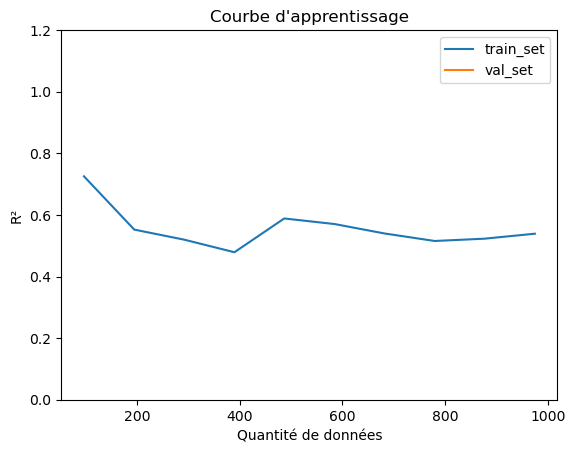

L'Erreur Quadratique Moyenne est : 145028.3632935975
L'Erreur Absolue Moyenne est : 176.81150903547817
L'Erreur Absolue Médiane est : 71.82848937307585


In [144]:
# évaluation du modèle
evaluation(reg, X_train, y_train, columns)

#### Vérification de la stabilité du modèle

0.2994822821081069
0.04232900008162698


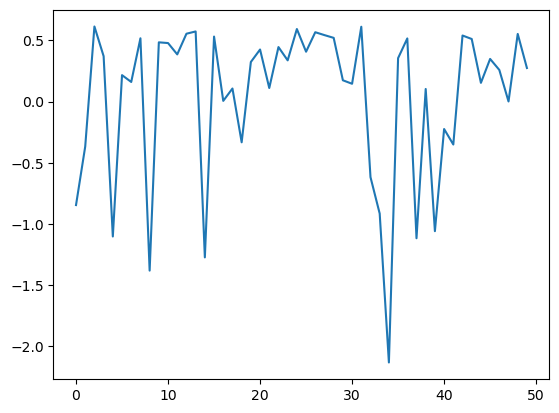

In [145]:
score_iteration = []

for i in range(50):
    data_train, data_test, var_categ, data_categ, var_num, data_num = creation_train_test_set(data3, target)
    score, reg, X_train, X_test, y_train, y_test, columns = modelisation(data_train, data_test, target)
    score_iteration.append(score)
    
plt.plot(range(len(score_iteration)), score_iteration)

print(np.median(np.array(score_iteration)))
print(np.array(score_iteration).mean())

### Régression avec stats model

In [146]:
data_train, data_test, var_categ, data_categ, var_num, data_num = creation_train_test_set(data3, target)
score, reg, X_train, X_test, y_train, y_test, columns = modelisation(data_train, data_test, target)

# ajout de la colonne de biais
df_X_train = pd.DataFrame(X_train, columns=columns)
df_X_test = pd.DataFrame(X_test, columns=columns)
X_train_sm = sm.add_constant(df_X_train)
X_test_sm = sm.add_constant(df_X_test)

results = sm.OLS(y_train, X_train_sm).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     66.61
Date:                Thu, 10 Aug 2023   Prob (F-statistic):          4.82e-124
Time:                        08:09:32   Log-Likelihood:                -9069.3
No. Observations:                1219   AIC:                         1.816e+04
Df Residuals:                    1206   BIC:                         1.823e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         -218.0310     55.157     -3.953      0.000    -326.245    -109.817
Quartier                         1.7900      4.268      0.419      0.675      -6.584      10.164
UtilisationPrincipale           -1.6962      0.976     -1.738      0.082      -3.611       0.218
UtilisationSecondaire           -1.0878      1.013     -1.074      0.283      -3.076       0.900
UtilisationTertiaire             0.4526      1.768      0.256      0.798      -3.017       3.922
Conformité                    -167.1974    132.533     -1.262      0.207    -427.217      92.823
TrancheAge                      15.8529     11.193      1.416      0.157      -6.106      37.812
NombreUtilisations               7.9888     17.402      0.459      0.646     -26.153      42.131
NombreBatiments                260.0641     24.956     10.421      0.000     211.103     309.025
NombreEtages                   -17.2488      2.350     -7.341      0.000     -21.859     -12.639
SurfaceUtilisationPrincipale     0.0021      0.000     17.213      0.000       0.002       0.002
SurfaceUtilisationSecondaire     0.0010      0.000      2.522      0.012       0.000       0.002
SurfaceUtilisationTertiaire     -0.0031      0.001     -3.301      0.001      -0.005      -0.001
==============================================================================
Omnibus:                     1608.375   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           565020.799
Skew:                           6.790   Prob(JB):                         0.00
Kurtosis:                     107.594   Cond. No.                     2.08e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Calcul VIF

In [147]:
vif = [variance_inflation_factor(X_train_sm, i) for i in range(X_train_sm.shape[1])]
df_vif = pd.DataFrame(vif, index=X_train_sm.columns, columns=['VIF'])
df_vif

VIF
const                         21.614695
Quartier                       1.104233
UtilisationPrincipale          1.051397
UtilisationSecondaire          1.700307
UtilisationTertiaire           2.060351
Conformité                     1.015350
TrancheAge                     1.112355
NombreUtilisations             2.946107
NombreBatiments                1.082802
NombreEtages                   1.945817
SurfaceUtilisationPrincipale   2.604085
SurfaceUtilisationSecondaire   2.680597
SurfaceUtilisationTertiaire    1.587423

#### Score sur jeu de test

In [148]:
X_test_sm = sm.add_constant(X_test)

y_pred = results.predict(X_test_sm)

r_squared = r2_score(y_test, y_pred)

r_squared

0.6591731267473955

#### Importances des variables

In [149]:
results.tvalues

const                           -3.952934
Quartier                         0.419362
UtilisationPrincipale           -1.738255
UtilisationSecondaire           -1.073543
UtilisationTertiaire             0.255978
Conformité                      -1.261557
TrancheAge                       1.416365
NombreUtilisations               0.459067
NombreBatiments                 10.421109
NombreEtages                    -7.341074
SurfaceUtilisationPrincipale    17.212761
SurfaceUtilisationSecondaire     2.521760
SurfaceUtilisationTertiaire     -3.301349
dtype: float64

#### Analyse des résidus

ShapiroResult(statistic=0.5052961111068726, pvalue=0.0)

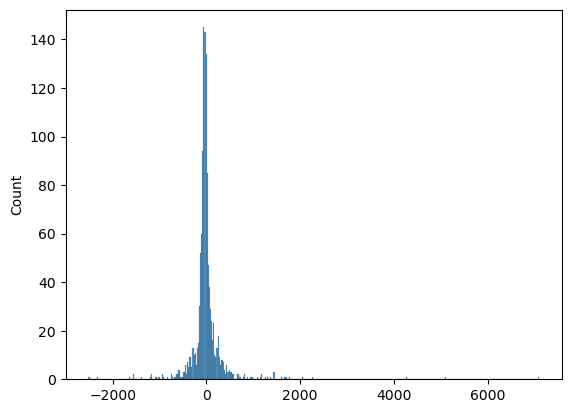

In [150]:
sns.histplot(results.resid)

shapiro(results.resid)

Les résidus ne suivent pas une loi normale, régression pas acceptable.

#### Stabilité du modèle

0.23253606548007322
-0.08007605367126142


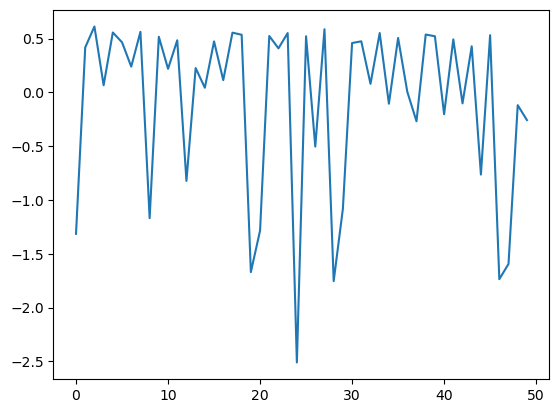

In [151]:
score_iteration = []

for i in range(50):
    
    data_train, data_test, var_categ, data_categ, var_num, data_num = creation_train_test_set(data3, target)
    score, reg, X_train, X_test, y_train, y_test, columns = modelisation(data_train, data_test, target)

    # ajout de la colonne de biais
    df_X_train = pd.DataFrame(X_train, columns=columns)
    df_X_test = pd.DataFrame(X_test, columns=columns)
    X_train_sm = sm.add_constant(df_X_train)
    X_test_sm = sm.add_constant(df_X_test)

    results = sm.OLS(y_train, X_train_sm).fit()

    X_test_sm = sm.add_constant(X_test)

    y_pred = results.predict(X_test_sm)

    r_squared = r2_score(y_test, y_pred)
    
    score_iteration.append(r_squared)
    
plt.plot(range(len(score_iteration)), score_iteration)

print(np.median(np.array(score_iteration)))
print(np.array(score_iteration).mean())

### Notes

Supprimer les variables corrélées entre elles --> garder uniquement la + importante